# Import packages

In [1]:
import gc
import os
import time
import datetime
from dateutil import relativedelta
from tqdm.notebook import tqdm
import numpy as np
import talib
from talib import MA_Type
import pandas as pd
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [2]:
# path_price = './stock-price/price/'
path_price = './price_usa_web/price_web/'
# path_price = './data_price_us_invest/'
list_file_price = [os.path.join(path_price, filename) for filename in os.listdir(path_price) if os.path.isfile(os.path.join(path_price, filename))]

# DataLoader
### Technical Indicators & News Sentiment

In [3]:
def make_label(df, dropna=False, stock=None):
    list_stock = df['symbol'].unique().tolist()
    if len(list_stock) > 1:
        raise ValueError('There are more than one stock in this file', stock) 
    if len(list_stock) < 1:
        raise ValueError('There are no stock in this file', stock) 
    if stock != list_stock[0]:
        raise ValueError(f'The stock value is not match: value "{list_stock[0]}" vs "{stock}"')
    
    if dropna:
        df.dropna(inplace=True)
        
    if df.groupby('Date').size().reset_index(name='count').query('count > 1').shape[0] > 0:
        raise ValueError(f'The stock value is duplicate: "{stock}"')
    
#     df['Adj Close'] = df['Close']
        
    df = df.sort_values(by='Date', ascending=True)
    
#     for lag in list(range(1, 3+1)):
#         df['tmp'] = df['Adj Close'].pct_change(periods=lag).shift(-lag)
#         df[f'label_next{lag}'] = (df['tmp'] >= 0.01).astype('int')
#         del df['tmp']
    
    df['adjClose_next10_max'] = df.groupby('symbol')['Adj Close'].transform(lambda x: x.rolling(10).max().shift(-10))
    df['label_next10_max'] = (df['adjClose_next10_max'] / df['Adj Close'] - 1 >= 0.01).astype('int')
    
#     df['adjClose_next3to10_max'] = df.groupby('symbol')['Adj Close'].transform(lambda x: x.rolling(7).max().shift(-9))
#     df['label_next3to10_max'] = (df['adjClose_next3to10_max'] / df['Adj Close'] - 1 >= 0.01).astype('int')
    
    return df

# def get_info(df, stock=None, get_info='old_price'):
#     list_cols_info = ['country', 'industry', 'sector', 'exchange', 'market']
    
#     if get_info == 'yahoo':
#         msft = yf.Ticker(stock)
#         for key in list_cols_info:
#             df[key] = msft.info.get(key)
            
#     if get_info == 'old_price':
#         df_info = pd.read_csv(f'{path_info}{stock}.csv')[list_cols_info].iloc[0, :]
        
#         for key in list_cols_info:
#             df[key] = df_info[key]
        
#     return df
        
def make_pct_change(df):
    df = df.sort_values(by='Date', ascending=True)
    
#     for lag_day in list(range(1, 31)) + list(range(40, 101, 10)) + [200,]:
#         df[f'pct_change_lag{lag_day}'] = df['Adj Close'].pct_change(lag_day)
    
    for lag_day in list(range(1, 16)) + [20, 30, 40]:
        df[f'pct_change_price_lag{lag_day}'] = df['Adj Close'].pct_change(lag_day)
        
    return df

def make_ext_features(df):
    df = df.sort_values(by='Date', ascending=True)
    
    df['ext_feat_OpenClose'] = df['Close'] / df['Open'] - 1
    df['ext_feat_upOrDownInDay'] = (df['ext_feat_OpenClose'] > 0).astype('int')
    
    df['ext_feat_OpenHigh'] = df['High'] / df['Open'] - 1
    df['ext_feat_OpenLow'] = df['Low'] / df['Open'] - 1
    
    df['ext_feat_CloseHigh'] = df['High'] / df['Close'] - 1
    df['ext_feat_CloseLow'] = df['Low'] / df['Close'] - 1
    
    df['ext_feat_HighLow'] = df['High'] / df['Low'] - 1
    
    for lag_day in [5, 10, 20, 30]:
        df[f'ext_feat_countUpDays_{lag_day}'] = df['ext_feat_upOrDownInDay'].rolling(lag_day).sum()

    return df

def make_technical_features(df, dropna=False):
    if dropna:
        df.dropna(inplace=True)
        
    df = df.sort_values(by='Date', ascending=True)
    
    for timeperiod in [20, 50]:
        df[f'ta_SMA{timeperiod}'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.SMA(x, timeperiod=timeperiod)) 

    for timeperiod in [20, 50]:
        df[f'ta_EMA{timeperiod}'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.EMA(x, timeperiod=timeperiod)) 
    
    upper, middle, lower = talib.BBANDS(df['Adj Close'], timeperiod=5, matype=MA_Type.T3)
    df['ta_BBANDS_upper'] = upper
    df['ta_BBANDS_middle'] = middle
    df['ta_BBANDS_lower'] = lower

#     df['ta_BBANDS_isBreakUpper'] = (df['Adj Close'] > df['ta_BBANDS_upper']).astype('int')
#     df['ta_BBANDS_isBreakLower'] = (df['Adj Close'] < df['ta_BBANDS_lower']).astype('int')
#     df['ta_BBANDS_isHigherPart'] = (df['Adj Close'] >= df['ta_BBANDS_middle']).astype('int')
    
#     macd, macdsignal, macdhist = talib.MACD(df['Adj Close'])
#     df['ta_MACD_macd'] = macd
#     df['ta_MACD_macdsignal'] = macdsignal
#     df['ta_MACD_macdhist'] = macdhist
#     df['ta_MACD_macd_positive'] = (df['ta_MACD_macd'] >= 0).astype('int')
#     df['ta_MACD_macd_over_signal'] = (df['ta_MACD_macd'] >= df['ta_MACD_macdsignal']).astype('int')

    df['ta_RSI'] = talib.RSI(df['Adj Close'], timeperiod=14)
#     df['ta_RSI_overbought'] = (df['ta_RSI'] >= 70).astype('int')
#     df['ta_RSI_oversold'] = (df['ta_RSI'] <= 30).astype('int')
#     df['ta_RSI_upperPart'] = (df['ta_RSI'] >= 50).astype('int')

#     df['ta_RSI_SMA3'] = df.groupby('symbol')['ta_RSI'].transform(lambda x: talib.SMA(x, timeperiod=3))
#     df['ta_RSI_SMA3_overbought'] = (df['ta_RSI'] >= 70).astype('int')
#     df['ta_RSI_SMA3_oversold'] = (df['ta_RSI'] <= 30).astype('int')
#     df['ta_RSI_SMA3_upperPart'] = (df['ta_RSI'] >= 50).astype('int')

#     df['ta_RSI_SMA5'] = df.groupby('symbol')['ta_RSI'].transform(lambda x: talib.SMA(x, timeperiod=5))
#     df['ta_RSI_SMA5_overbought'] = (df['ta_RSI'] >= 70).astype('int')
#     df['ta_RSI_SMA5_oversold'] = (df['ta_RSI'] <= 30).astype('int')
#     df['ta_RSI_SMA5_upperPart'] = (df['ta_RSI'] >= 50).astype('int')

    slowk, slowd = talib.STOCH(df['High'], df['Low'], df['Close'])
    df['ta_STOCH_slowk'] = slowk
    df['ta_STOCH_slowd'] = slowd
#     df['ta_STOCH_overbought'] = (df['ta_STOCH_slowk'] >= 80).astype('int')
#     df['ta_STOCH_oversold'] = (df['ta_STOCH_slowk'] <= 20).astype('int')
#     df['ta_STOCH_koverd'] = (df['ta_STOCH_slowk'] >= df['ta_STOCH_slowd']).astype('int')

    df['ta_MFI'] = talib.MFI(df['High'], df['Low'], df['Close'], df['Volume'])
#     df['ta_MFI_overbought'] = (df['ta_MFI'] >= 80).astype('int')
#     df['ta_MFI_oversold'] = (df['ta_MFI'] <= 20).astype('int')

    df['ta_OBV'] = talib.OBV(df['Adj Close'], df['Volume'])
#     df['ta_OBV_SMA3'] = df.groupby('symbol')['ta_OBV'].transform(lambda x: talib.SMA(x, timeperiod=3))
#     df['ta_OBV_SMA5'] = df.groupby('symbol')['ta_OBV'].transform(lambda x: talib.SMA(x, timeperiod=5))
#     df['ta_OBV_SMA10'] = df.groupby('symbol')['ta_OBV'].transform(lambda x: talib.SMA(x, timeperiod=10))
#     df['ta_OBV_SMA20'] = df.groupby('symbol')['ta_OBV'].transform(lambda x: talib.SMA(x, timeperiod=20))
#     df['ta_OBV_SMA50'] = df.groupby('symbol')['ta_OBV'].transform(lambda x: talib.SMA(x, timeperiod=50))
#     df['ta_OBV_upTrend3'] = (df['ta_OBV'] >= df['ta_OBV_SMA3']).astype('int')
#     df['ta_OBV_upTrend5'] = (df['ta_OBV'] >= df['ta_OBV_SMA5']).astype('int')
#     df['ta_OBV_upTrend10'] = (df['ta_OBV'] >= df['ta_OBV_SMA10']).astype('int')
#     df['ta_OBV_upTrend20'] = (df['ta_OBV'] >= df['ta_OBV_SMA20']).astype('int')
#     df['ta_OBV_upTrend50'] = (df['ta_OBV'] >= df['ta_OBV_SMA50']).astype('int')

    df['ta_AD'] = talib.AD(df['High'], df['Low'], df['Close'], df['Volume'])
#     df['ta_AD_SMA3'] = df.groupby('symbol')['ta_AD'].transform(lambda x: talib.SMA(x, timeperiod=3))
#     df['ta_AD_SMA5'] = df.groupby('symbol')['ta_AD'].transform(lambda x: talib.SMA(x, timeperiod=5))
#     df['ta_AD_SMA10'] = df.groupby('symbol')['ta_AD'].transform(lambda x: talib.SMA(x, timeperiod=10))
#     df['ta_AD_upTrend3'] = (df['ta_AD'] >= df['ta_AD_SMA3']).astype('int')
#     df['ta_AD_upTrend5'] = (df['ta_AD'] >= df['ta_AD_SMA5']).astype('int')
#     df['ta_AD_upTrend10'] = (df['ta_AD'] >= df['ta_AD_SMA10']).astype('int')

#     df['ta_MINUS_DI'] = talib.MINUS_DI(df['High'], df['Low'], df['Close'])
#     df['ta_PLUS_DI'] = talib.PLUS_DI(df['High'], df['Low'], df['Close'])
#     df['ta_DI_uptrend'] = (df['ta_PLUS_DI'] > df['ta_MINUS_DI']).astype('int')
#     df['ta_DI_downtrend'] = (df['ta_PLUS_DI'] < df['ta_MINUS_DI']).astype('int')

    df['ta_ADX'] = talib.ADX(df['High'], df['Low'], df['Close'])
#     df['ta_ADX_over25'] = (df['ta_ADX'] > 25).astype('int')
#     df['ta_ADX_uptrend'] = ((df['ta_ADX'] > 25) & (df['ta_PLUS_DI'] > df['ta_MINUS_DI'])).astype('int')
#     df['ta_ADX_downtrend'] = ((df['ta_ADX'] > 25) & (df['ta_PLUS_DI'] < df['ta_MINUS_DI'])).astype('int')

#     df['ta_WILLR'] = talib.WILLR(df['High'], df['Low'], df['Close'])
#     df['ta_WILLR_overbought'] = (df['ta_WILLR'] >= -20).astype('int')
#     df['ta_WILLR_oversold'] = (df['ta_WILLR'] <= -80).astype('int')

#     df['ta_CCI'] = talib.CCI(df['High'], df['Low'], df['Close'])
#     df['ta_CCI_overbought'] = (df['ta_CCI'] >= 100).astype('int')
#     df['ta_CCI_oversold'] = (df['ta_CCI'] <= -100).astype('int')

    df['ta_ATR'] = talib.ATR(df['High'], df['Low'], df['Close'])

#     df['ta_ULTOSC'] = talib.ULTOSC(df['High'], df['Low'], df['Close'])
#     df['ta_ULTOSC_overbought'] = (df['ta_ULTOSC'] >= 70).astype('int')
#     df['ta_ULTOSC_oversold'] = (df['ta_ULTOSC'] <= 30).astype('int')
#     df['ta_ULTOSC_upperPart'] = (df['ta_ULTOSC'] >= 50).astype('int')

    df['ta_ROC'] = talib.ROC(df['Adj Close'], timeperiod=10)
#     df['ta_ROC_higherPart'] = (df['ta_ROC'] >= 0).astype('int')
    
#     aroondown, aroonup = talib.AROON(df['High'], df['Low'])
#     df['ta_AROON_aroondown'] = aroondown
#     df['ta_AROON_aroonup'] = aroonup
#     df['ta_AROON_aroonup_uptrend'] = (df['ta_AROON_aroonup'] >= 70).astype('int')
#     df['ta_AROON_aroonup_downtrend'] = (df['ta_AROON_aroonup'] <= 30).astype('int')
#     df['ta_AROON_aroondown_downtrend'] = (df['ta_AROON_aroondown'] >= 70).astype('int')
#     df['ta_AROON_aroondown_uptrend'] = (df['ta_AROON_aroondown'] <= 30).astype('int')
#     df['ta_AROON_aroonup_over_aroondown'] = (df['ta_AROON_aroonup'] >= df['ta_AROON_aroondown']).astype('int')

    return df

In [4]:
list100 = pd.read_csv('list_sp100.csv')['symbol'].unique()
df_info = pd.read_csv('list_sp100.csv')

In [5]:
df = None
filter_start_time = '2008-01-01'
filter_end_time = None

for file in tqdm(list_file_price):
    basename = os.path.basename(file)
    os.path.splitext(basename)
    file_name, file_extension = os.path.splitext(basename)
    if file_extension != '.csv':
        continue
    
    if file_name not in list100:
        continue
    
    df_price = pd.read_csv(file)#[select_col]
    
    min_date = df_price['Date'].min()
    if min_date >= '2015':
        print(f'ignored {file_name} since the min_date is {min_date}')
        continue
    
    df_price = df_price[df_price['Date'] >= filter_start_time]
    if filter_end_time is not None:
        df_price = df_price[df_price['Date'] <= filter_end_time]
        
    if len(df_price) <= 300:
        continue
    
    df_price['Date'] = pd.to_datetime(df_price['Date'])
    df_price['symbol'] = file_name
    
    df_price = df_price.merge(df_info, on='symbol', how='left')
    
    df_price = make_label(df_price, dropna=True, stock=file_name)
#     try:
#         df_price = get_info(df_price, stock=file_name)
#     except:
#         print(f'failed to get stock info {file_name}. Retrying with yahoo service...')
#         df_price = get_info(df_price, stock=file_name, get_info='yahoo')
        
    
    df_price = make_pct_change(df_price)
    df_price = make_ext_features(df_price)

    df_price = make_technical_features(df_price)
    
    if df is None:
        df = df_price.copy()
    else:
        df = pd.concat([df, df_price], axis=0)
    
    del df_price
    gc.collect()

  0%|          | 0/498 [00:00<?, ?it/s]

ignored DOW since the min_date is 2019-03-20
ignored KHC since the min_date is 2015-07-06
ignored PYPL since the min_date is 2015-07-06


In [6]:
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,company_name,sector,adjClose_next10_max,label_next10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC
0,2008-01-02,7.116786,7.152143,6.876786,6.958571,5.974743,1079178800,AAPL,Apple Inc.,Information Technology,5.977503,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022231,0,0.004968,-0.033723,0.027818,-0.011753,0.040042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.079179e+09,-4.381155e+08,NaN,NaN,NaN
1,2008-01-03,6.978929,7.049643,6.881786,6.961786,5.977503,842066400,AAPL,Apple Inc.,Information Technology,5.521210,0,0.000462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002456,0,0.010133,-0.013919,0.012620,-0.011491,0.024391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.921245e+09,-4.775307e+08,NaN,NaN,NaN
2,2008-01-04,6.837500,6.892857,6.388929,6.430357,5.521210,1455832000,AAPL,Apple Inc.,Information Technology,5.501277,0,-0.076335,-0.075908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.059546,0,0.008096,-0.065605,0.071924,-0.006443,0.078875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.654132e+08,-1.693994e+09,NaN,NaN,NaN


In [7]:
df.shape

(324551, 57)

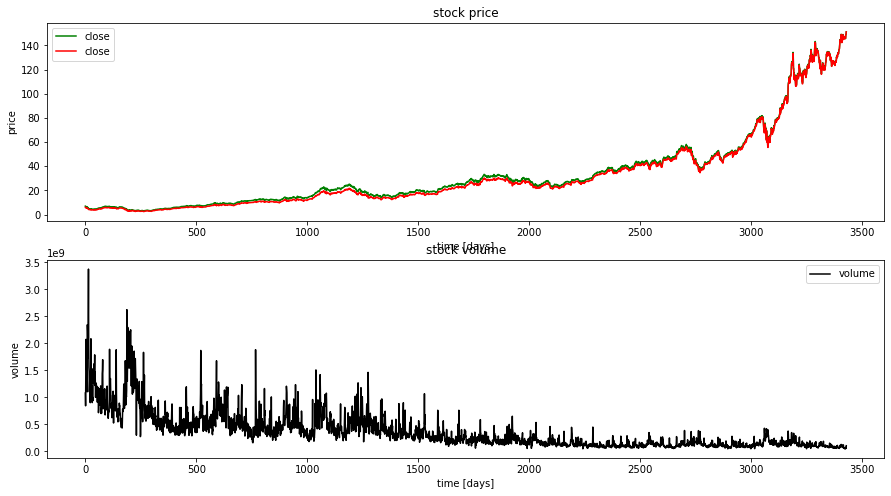

In [8]:
plt.figure(figsize=(15, 8));
plt.subplot(2,1,1);
symbol='AAPL'
# plt.plot(df[df.symbol == symbol].Open.values, color='red', label='open')
plt.plot(df[df.symbol == symbol].Close.values, color='green', label='close')
plt.plot(df[df.symbol == symbol]['Adj Close'].values, color='red', label='close')
# plt.plot(df[df.symbol == symbol].Low.values, color='blue', label='low')
# plt.plot(df[df.symbol == symbol].High.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(2,1,2);
plt.plot(df[df.symbol == symbol].Volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

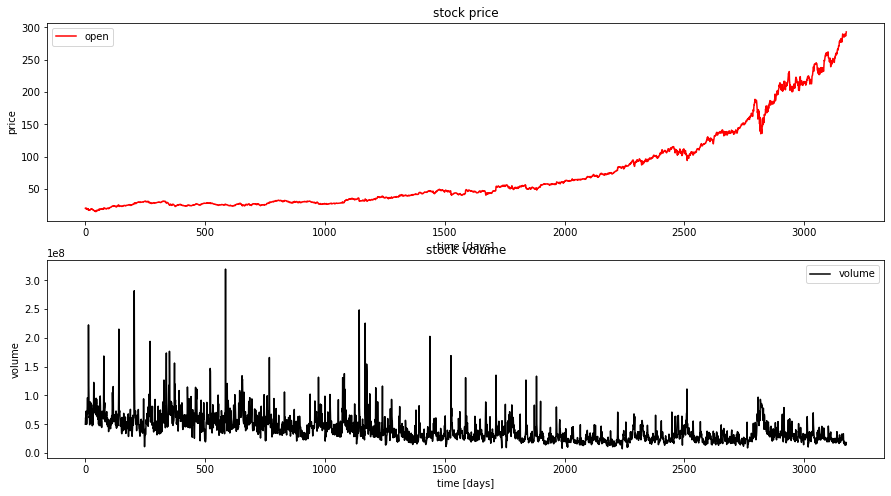

In [13]:
plt.figure(figsize=(15, 8));
plt.subplot(2,1,1);
symbol='MSFT'
plt.plot(df[(df.symbol == symbol)].Close.values, color='red', label='open')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(2,1,2);
plt.plot(df[df.symbol == symbol].Volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324551 entries, 0 to 3429
Data columns (total 56 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Date                     324551 non-null  datetime64[ns]
 1   Open                     324551 non-null  float64       
 2   High                     324551 non-null  float64       
 3   Low                      324551 non-null  float64       
 4   Close                    324551 non-null  float64       
 5   Adj Close                324551 non-null  float64       
 6   Volume                   324551 non-null  int64         
 7   symbol                   324551 non-null  object        
 8   sector                   324551 non-null  object        
 9   adjClose_next10_max      323591 non-null  float64       
 10  label_next10_max         324551 non-null  int32         
 11  pct_change_price_lag1    324455 non-null  float64       
 12  pct_change_price_l

In [7]:
df.shape

(324551, 69)

In [8]:
df.isna().sum()

Date                          0
Open                          0
High                          0
Low                           0
Close                         0
Adj Close                     0
Volume                        0
symbol                        0
adjClose_next10_max         960
label_next10_max              0
pct_change_price_lag1        96
pct_change_price_lag2       192
pct_change_price_lag3       288
pct_change_price_lag4       384
pct_change_price_lag5       480
pct_change_price_lag6       576
pct_change_price_lag7       672
pct_change_price_lag8       768
pct_change_price_lag9       864
pct_change_price_lag10      960
pct_change_price_lag11     1056
pct_change_price_lag12     1152
pct_change_price_lag13     1248
pct_change_price_lag14     1344
pct_change_price_lag15     1440
pct_change_price_lag20     1920
pct_change_price_lag30     2880
pct_change_price_lag40     3840
ext_feat_OpenClose            0
ext_feat_upOrDownInDay        0
ext_feat_OpenHigh             0
ext_feat

In [25]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,pct_change_next1,pct_change_next3,label_t3,country,industry,sector,exchange,market,pct_change_lag1,pct_change_lag2,pct_change_lag3,pct_change_lag4,pct_change_lag5,pct_change_lag6,pct_change_lag7,pct_change_lag8,pct_change_lag9,pct_change_lag10,pct_change_lag11,pct_change_lag12,pct_change_lag13,pct_change_lag14,pct_change_lag15,pct_change_lag16,pct_change_lag17,pct_change_lag18,pct_change_lag19,pct_change_lag20,pct_change_lag21,pct_change_lag22,pct_change_lag23,pct_change_lag24,pct_change_lag25,pct_change_lag26,pct_change_lag27,pct_change_lag28,pct_change_lag29,pct_change_lag30,ext_features_close_pct_change_01,ext_features_close_pct_change_12,ext_features_close_pct_change_23,ext_features_close_pct_change_34,ext_features_close_pct_change_45,ext_features_high_open_00,ext_features_high_open_01,ext_features_high_open_02,ext_features_high_open_03,ext_features_high_open_04,ext_features_high_open_05,ext_features_high_open_11,ext_features_high_open_22,ext_features_high_open_33,ext_features_high_open_44,ext_features_high_open_55,ext_features_low_open_00,ext_features_low_open_11,ext_features_low_open_22,ext_features_low_open_33,ext_features_low_open_44,ext_features_low_open_55,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_MINUS_DI,ta_PLUS_DI,ta_ADX,ta_WILLR,ta_CCI,ta_ATR,ta_ULTOSC,ta_ROC,ta_AROON_aroondown,ta_AROON_aroonup
1007,2009-01-02,11.158798,11.659514,11.094421,11.616595,10.629845,4236220,A,0.033867,0.122537,1,United States,Diagnostics & Research,Healthcare,NYQ,us_market,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4236220.0,3.592735e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008,2009-01-05,11.530758,12.224607,11.444921,12.010014,10.989847,7171321,A,0.079810,0.092912,1,United States,Diagnostics & Research,Healthcare,NYQ,us_market,0.033867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033306,NaN,NaN,NaN,NaN,0.058433,0.091223,NaN,NaN,NaN,NaN,0.043894,NaN,NaN,NaN,NaN,-0.007472,-0.005786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11407541.0,6.816531e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1009,2009-01-06,12.231760,13.383405,12.081545,12.968526,11.866942,11834210,A,0.005516,0.021511,1,United States,Diagnostics & Research,Healthcare,NYQ,us_market,0.079810,0.116380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076785,0.033306,NaN,NaN,NaN,0.089980,0.148997,0.181787,NaN,NaN,NaN,0.058433,0.043894,NaN,NaN,NaN,-0.012357,-0.007472,-0.005786,NaN,NaN,NaN,11.162211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23241751.0,1.110805e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,2009-01-07,12.768240,13.204578,12.653791,13.040057,11.932395,9974171,A,0.006582,0.015908,1,United States,Diagnostics & Research,Healthcare,NYQ,us_market,0.005516,0.085765,0.122537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005501,0.076785,0.033306,NaN,NaN,0.033603,0.076528,0.135546,0.168335,NaN,NaN,0.089980,0.058433,0.043894,NaN,NaN,-0.009004,-0.012357,-0.007472,-0.005786,NaN,NaN,11.596395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33215922.0,1.512362e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1011,2009-01-08,12.989986,13.218884,12.732475,13.125894,12.010939,6242909,A,0.009264,0.038692,1,United States,Diagnostics & Research,Healthcare,NYQ,us_market,0.006582,0.012134,0.092912,0.129926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [13]:
df.shape

(324551, 56)

In [10]:
df.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,label_next1,label_next2,label_next3,adjClose_next10_max,label_next10_max,adjClose_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_SMA100,ta_EMA3,ta_EMA5,ta_EMA10,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_MINUS_DI,ta_PLUS_DI
754,2008-01-02,7.116786,7.152143,6.876786,6.958571,5.974743,1079178800,AAPL,0,0,0,5.977503,0,5.501277,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022231,0,0.004968,-0.033723,0.027818,-0.011753,0.040042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.079179e+09,-4.381155e+08,NaN,NaN


In [8]:
df['month'] = df['Date'].dt.month
df['quarter'] = df['Date'].dt.quarter
df['year'] = df['Date'].dt.year

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,company_name,sector,adjClose_next10_max,label_next10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter,year
0,2008-01-02,7.116786,7.152143,6.876786,6.958571,5.974743,1079178800,AAPL,Apple Inc.,Information Technology,5.977503,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022231,0,0.004968,-0.033723,0.027818,-0.011753,0.040042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.079179e+09,-4.381155e+08,NaN,NaN,NaN,1,1,2008
1,2008-01-03,6.978929,7.049643,6.881786,6.961786,5.977503,842066400,AAPL,Apple Inc.,Information Technology,5.521210,0,0.000462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002456,0,0.010133,-0.013919,0.012620,-0.011491,0.024391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.921245e+09,-4.775307e+08,NaN,NaN,NaN,1,1,2008
2,2008-01-04,6.837500,6.892857,6.388929,6.430357,5.521210,1455832000,AAPL,Apple Inc.,Information Technology,5.501277,0,-0.076335,-0.075908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.059546,0,0.008096,-0.065605,0.071924,-0.006443,0.078875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.654132e+08,-1.693994e+09,NaN,NaN,NaN,1,1,2008
3,2008-01-07,6.473214,6.557143,6.079643,6.344286,5.447309,2072193200,AAPL,Apple Inc.,Information Technology,5.501277,0,-0.013385,-0.088698,-0.088277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.019917,0,0.012966,-0.060800,0.033551,-0.041714,0.078541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.606780e+09,-1.469260e+09,NaN,NaN,NaN,1,1,2008
4,2008-01-08,6.433571,6.516429,6.100000,6.116071,5.251360,1523816000,AAPL,Apple Inc.,Information Technology,5.501277,1,-0.035972,-0.048875,-0.121479,-0.121073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.049351,0,0.012879,-0.051848,0.065460,-0.002628,0.068267,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.130596e+09,-2.875461e+09,NaN,NaN,NaN,1,1,2008


In [8]:
df['Date'].min()

Timestamp('2008-01-02 00:00:00')

In [9]:
df['Date'].max()

Timestamp('2021-08-16 00:00:00')

In [9]:
df = df[df['Date'] >= '2010-01-01']
df.dropna(inplace=True)
df.isna().sum()

Date                       0
Open                       0
High                       0
Low                        0
Close                      0
Adj Close                  0
Volume                     0
symbol                     0
company_name               0
sector                     0
adjClose_next10_max        0
label_next10_max           0
pct_change_price_lag1      0
pct_change_price_lag2      0
pct_change_price_lag3      0
pct_change_price_lag4      0
pct_change_price_lag5      0
pct_change_price_lag6      0
pct_change_price_lag7      0
pct_change_price_lag8      0
pct_change_price_lag9      0
pct_change_price_lag10     0
pct_change_price_lag11     0
pct_change_price_lag12     0
pct_change_price_lag13     0
pct_change_price_lag14     0
pct_change_price_lag15     0
pct_change_price_lag20     0
pct_change_price_lag30     0
pct_change_price_lag40     0
ext_feat_OpenClose         0
ext_feat_upOrDownInDay     0
ext_feat_OpenHigh          0
ext_feat_OpenLow           0
ext_feat_Close

In [11]:
df.isna().sum().sum()

0

In [19]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,label_next1,label_next2,label_next3,adjClose_next10_max,label_next10_max,adjClose_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_SMA100,ta_SMA200,ta_EMA20,ta_EMA50,ta_EMA100,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_MINUS_DI,ta_PLUS_DI,ta_ADX,ta_WILLR,ta_CCI,ta_ATR,ta_ULTOSC,ta_ROC,ta_AROON_aroondown,ta_AROON_aroonup,month,quarter
count,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06,1.367770e+06
mean,1.741515e-02,1.746623e-02,1.742267e-02,1.749460e-02,1.637334e-02,2.907401e-03,2.353890e-01,3.181244e-01,3.638726e-01,8.942657e+01,7.235836e-01,8.889038e+01,6.620631e-01,7.747920e-04,1.532754e-03,2.305362e-03,3.065210e-03,3.814936e-03,4.565508e-03,5.299368e-03,6.050359e-03,6.796157e-03,7.550955e-03,8.298013e-03,9.058842e-03,9.826977e-03,1.059268e-02,1.136465e-02,1.517256e-02,2.273812e-02,3.030979e-02,3.406029e-04,5.124692e-01,1.106502e-02,-1.114813e-02,1.084857e-02,-1.136838e-02,2.260165e-02,1.537024e+01,1.640114e-02,1.656994e-02,1.678741e-02,1.698072e-02,1.722582e-02,1.703697e-02,1.746408e-02,1.691587e-02,1.704287e-02,1.713860e-02,1.609544e-02,1.658205e-02,1.646808e-02,4.205208e-01,4.183161e-01,2.204645e-03,5.344753e+01,5.415656e+01,5.415458e+01,5.286953e+01,2.628765e+08,2.863085e+08,2.193034e+01,2.388312e+01,2.394599e+01,-4.378167e+01,1.597811e+01,2.140944e+00,5.212399e+01,7.550955e-01,4.368918e+01,5.542746e+01,6.425559e+00,2.476533e+00
std,3.215536e-02,3.228974e-02,3.212262e-02,3.230583e-02,3.233468e-02,1.042806e-02,4.242418e-01,4.657482e-01,4.811128e-01,1.756580e+02,4.472253e-01,1.745938e+02,4.730071e-01,1.958083e-02,2.718064e-02,3.346718e-02,3.846562e-02,4.261567e-02,4.629597e-02,4.935740e-02,5.252453e-02,5.538027e-02,5.826286e-02,6.106186e-02,6.386211e-02,6.664749e-02,6.922923e-02,7.176452e-02,8.219419e-02,9.975689e-02,1.143861e-01,1.581204e-02,4.998447e-01,1.201278e-02,1.200852e-02,1.212838e-02,1.145689e-02,1.674767e-02,2.813476e+00,3.238276e-02,3.271485e-02,3.311984e-02,3.346379e-02,3.383896e-02,3.332117e-02,3.390110e-02,3.334835e-02,3.349458e-02,3.351831e-02,3.184460e-02,3.273197e-02,3.243872e-02,3.726628e+00,3.481338e+00,1.163401e+00,1.192615e+01,2.511031e+01,2.321130e+01,1.587170e+01,9.800144e+08,1.619175e+09,7.720940e+00,7.385315e+00,9.575288e+00,2.999729e+01,1.083616e+02,4.723254e+00,1.012172e+01,5.826286e+00,3.601325e+01,3.633802e+01,3.409718e+00,1.110153e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.

In [10]:
list_col_price = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
list_col_price_ta = [col for col in df.columns if 'ta_SMA' in col or 'ta_EMA' in col or 'ta_BBANDS' in col]

scaler = MinMaxScaler()
scaler.fit(df[list_col_price + list_col_price_ta])
df[list_col_price + list_col_price_ta] = scaler.transform(df[list_col_price + list_col_price_ta])

In [11]:
list_prefix = ['ta_MACD_macd', 'ta_OBV', 'ta_AD', 'ta_CCI']

for prefix in list_prefix:
    list_col_scale = [col for col in df.columns if prefix in col]
    
    if len(list_col_scale) == 0:
        continue
        
    scaler = StandardScaler()
    scaler.fit(df[list_col_scale])
    df[list_col_scale] = scaler.transform(df[list_col_scale])
    print(f'done {list_col_scale}')

done ['ta_OBV']
done ['ta_AD', 'ta_ADX']


In [14]:
df.max()

Date                       2021-08-02 00:00:00
Open                                       1.0
High                                       1.0
Low                                        1.0
Close                                      1.0
Adj Close                                  1.0
Volume                                     1.0
symbol                                     XOM
label_next1                                  1
label_next2                                  1
label_next3                                  1
adjClose_next10_max                3731.409912
label_next10_max                             1
adjClose_next3to10_max             3731.409912
label_next3to10_max                          1
pct_change_price_lag1                 0.439739
pct_change_price_lag2                 0.642069
pct_change_price_lag3                 0.733565
pct_change_price_lag4                 0.900326
pct_change_price_lag5                 0.847815
pct_change_price_lag6                 0.772009
pct_change_pr

In [18]:
df.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,label_next1,label_next2,label_next3,adjClose_next10_max,label_next10_max,adjClose_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_SMA100,ta_EMA3,ta_EMA5,ta_EMA10,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_MINUS_DI,ta_PLUS_DI,month,quarter,year
1259,2010-01-04,0.001455,0.001432,0.001468,0.001454,0.001213,0.262483,AAPL,0,0,0,6.594175,0,6.500339,0,0.015565,0.011199,0.023482,0.011342,0.023776,0.058932,0.068128,0.079605,0.095073,0.115449,0.097319,0.102179,0.086456,0.099348,0.089498,0.089221,0.039086,0.121587,0.002717,1,0.005013,-0.00492,0.00229,-0.007616,0.009982,2.0,7.0,10.0,13.0,0.001191,0.001184,0.001147,0.001096,0.001114,0.001005,0.001195,0.001185,0.001161,0.001125,0.001066,0.001143,0.00118,0.001202,-0.099228,-0.117247,0.032627,67.302512,81.375554,78.038721,80.785168,1.221413,3.754204,15.726457,33.834532,1,1,2010


In [12]:
train_cols = ['Open', 'High', 'Low', 'Close', 
              'Adj Close', 'Volume',
              'month', 'quarter', 'year'
             ]

category_cols = ['symbol',]

ta_cols = [col for col in df.columns if 'ta_' in col]
ext_feature_cols = [col for col in df.columns if 'ext_feat_' in col]
pct_change_lag_cols = [col for col in df.columns if 'pct_change_price_lag' in col]

label = 'label_next10_max'

In [13]:
for col in category_cols:
    le = preprocessing.LabelEncoder()
    df['encode_' + col] = le.fit_transform(df[col])
    train_cols.append('encode_' + col)
    print(f'processed column {col}')

processed column symbol


In [14]:
df.dropna(inplace=True)
df.isna().sum().sum()

0

In [16]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,company_name,sector,adjClose_next10_max,label_next10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter,year,encode_symbol
505,2010-01-04,0.001455,0.001432,0.001468,0.001454,0.001213,0.262483,AAPL,Apple Inc.,Information Technology,6.594175,0,0.015565,0.011199,0.023482,0.011342,0.023776,0.058932,0.068128,0.079605,0.095073,0.115449,0.097319,0.102179,0.086456,0.099348,0.089498,0.089221,0.039086,0.121587,0.002717,1,0.005013,-0.004920,0.002290,-0.007616,0.009982,2.0,7.0,10.0,13.0,0.001096,0.001114,0.001125,0.001066,0.001143,0.001180,0.001202,67.302512,81.375554,78.038721,80.785168,1.222138,3.755990,-0.270175,0.149661,11.544894,1,1,2010,0
506,2010-01-05,0.001466,0.001442,0.001476,0.001458,0.001216,0.319992,AAPL,Apple Inc.,Information Technology,6.594175,0,0.001729,0.017321,0.012947,0.025251,0.013090,0.025545,0.060762,0.069974,0.081471,0.096965,0.117377,0.099216,0.104084,0.088334,0.101248,0.108939,0.069174,0.104881,-0.001025,0,0.004613,-0.006291,0.005644,-0.005271,0.010973,2.0,6.0,10.0,13.0,0.001105,0.001116,0.001134,0.001072,0.001160,0.001191,0.001208,67.650234,81.695276,78.837235,81.246614,1.521895,3.750165,-0.135253,0.144940,9.696543,1,1,2010,0
507,2010-01-06,0.001464,0.001438,0.001452,0.001425,0.001188,0.293546,AAPL,Apple Inc.,Information Technology,6.594175,1,-0.015906,-0.014205,0.001139,-0.003166,0.008943,-0.003024,0.009233,0.043889,0.052955,0.064269,0.079517,0.099604,0.081731,0.086522,0.071023,0.116539,0.055272,0.085572,-0.015906,0,0.003965,-0.016933,0.020192,-0.001043,0.021257,2.0,5.0,10.0,12.0,0.001114,0.001117,0.001139,0.001076,0.001159,0.001197,0.001221,61.190556,70.667228,77.912686,79.144460,1.246911,3.609146,-0.102180,0.146016,6.426904,1,1,2010,0
508,2010-01-07,0.001438,0.001408,0.001435,0.001421,0.001185,0.253659,AAPL,Apple Inc.,Information Technology,6.594175,1,-0.001849,-0.017726,-0.016028,-0.000712,-0.005009,0.007078,-0.004868,0.007367,0.041959,0.051008,0.062301,0.077521,0.097571,0.079731,0.084513,0.109074,0.022829,0.045269,-0.005525,0,0.001181,-0.012751,0.006743,-0.007266,0.014112,1.0,4.0,9.0,11.0,0.001123,0.001119,0.001143,0.001080,0.001162,0.001198,0.001219,60.479105,47.770731,66.711078,72.445008,1.009293,3.614184,-0.129382,0.143112,5.100786,1,1,2010,0
509,2010-01-08,0.001425,0.001408,0.001436,0.001435,0.001196,0.237965,AAPL,Apple Inc.,Information Technology,6.594175,1,0.006648,0.004787,-0.011195,-0.009486,0.005932,0.001606,0.013773,0.001748,0.014064,0.048887,0.057995,0.069364,0.084685,0.104868,0.086910,0.071688,0.036881,0.044339,0.007989,1,0.008084,-0.005896,0.000094,-0.013775,0.014063,2.0,4.0,9.0,12.0,0.001129,0.001121,0.001149,0.001084,0.001158,0.001196,0.001220,62.178750,34.911379,51.116446,78.095069,1.232210,3.739225,-0.154641,0.140390,4.888671,1,1,2010,0


In [15]:
df_list_date = pd.DataFrame(df['Date'].unique(), columns=['Date'])

In [16]:
# def calc_cum_effect(series, num_day=0):
#     result = series
#     if num_day > 0:
#         for i in range(1, num_day + 1):
#             result += 1/i * series.shift(i, fill_value=0)
#     return result

df_stock_news = pd.read_csv('./exported_data/news_sentiment_analysis/us_stock_news_sentiment_analysis.csv')
df_stock_news['Date'] = pd.to_datetime(df_stock_news['Date'])

stock_news_cols = [col for col in df_stock_news.columns if col not in ['symbol', 'Date']]

df_stock_news = df_list_date.merge(df_stock_news, on='Date', how='outer')
df_stock_news = df_stock_news.sort_values(by=['symbol', 'Date'])
df_stock_news.fillna(0, inplace=True)

# for col in stock_news_cols:
#     if '_pos' in col or '_neg' in col or '_compound' in col or '_total' in col:
#         df_stock_news[col] = df_stock_news \
#             .groupby('symbol')[col].transform(calc_cum_effect)

df_stock_news.head()

,Date,symbol,stocks_daily_sentiment_score_lm,stocks_daily_sentiment_score_vader
16134,2015-11-16,A,-1.0,1.0
22684,2016-07-28,A,-1.0,0.0
22782,2016-08-01,A,-1.0,1.0
23276,2016-08-18,A,0.0,1.0
26058,2016-11-15,A,0.0,0.0


In [17]:
df_political_news = pd.read_csv('./exported_data/news_sentiment_analysis/us_political_news_sentiment_analysis.csv')
df_political_news['Date'] = pd.to_datetime(df_political_news['Date'])
political_news_cols = [col for col in df_political_news.columns if col not in ['symbol', 'Date']]

df_political_news = df_list_date.merge(df_political_news, on='Date', how='outer')
df_political_news = df_political_news.sort_values(by=['Date'])
df_political_news.fillna(0, inplace=True)

# for col in political_news_cols:
#     if '_pos' in col or '_neg' in col or '_compound' in col or '_total' in col:
#         df_political_news[col] = df_political_news[col].transform(calc_cum_effect)
        
df_political_news.head()

,Date,politic_daily_sentiment_score_vader
2915,2005-01-02,-1.0
2916,2005-01-03,0.0
2917,2005-01-05,-1.0
2918,2005-01-06,-1.0
2919,2005-01-07,-1.0


In [31]:
# df_indicator_news = pd.read_csv('./exported_data/economic_indicator_news_sentiment_analysis.csv')
# df_indicator_news['Date'] = pd.to_datetime(df_indicator_news['Date'])
# indicator_news_cols = [col for col in df_indicator_news.columns if col not in ['symbol', 'Date']]

# df_indicator_news = df_list_date.merge(df_indicator_news, on='Date', how='outer')
# df_indicator_news = df_indicator_news.sort_values(by=['Date'])
# df_indicator_news.fillna(0, inplace=True)

# for col in indicator_news_cols:
#     if '_pos' in col or '_neg' in col or '_compound' in col or '_total' in col:
#         df_indicator_news[col] = df_indicator_news[col].transform(calc_cum_effect)
        
# df_indicator_news.head()

,Date,economy_indicator_news_in_day,economy_indicator_news_vader_neg,economy_indicator_news_vader_pos,economy_indicator_news_vader_neu,economy_indicator_news_vader_compound,economy_indicator_news_wordnet_pos,economy_indicator_news_wordnet_neg,economy_indicator_news_wordnet_obj,economy_indicator_news_wordnet_total
0,2010-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,company_name,sector,adjClose_next10_max,label_next10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter,year,encode_symbol
0,2010-01-04,0.001455,0.001432,0.001468,0.001454,0.001213,0.262483,AAPL,Apple Inc.,Information Technology,6.594175,0,0.015565,0.011199,0.023482,0.011342,0.023776,0.058932,0.068128,0.079605,0.095073,0.115449,0.097319,0.102179,0.086456,0.099348,0.089498,0.089221,0.039086,0.121587,0.002717,1,0.005013,-0.004920,0.002290,-0.007616,0.009982,2.0,7.0,10.0,13.0,0.001096,0.001114,0.001125,0.001066,0.001143,0.001180,0.001202,67.302512,81.375554,78.038721,80.785168,1.222138,3.755990,-0.270175,0.149661,11.544894,1,1,2010,0
1,2010-01-05,0.001466,0.001442,0.001476,0.001458,0.001216,0.319992,AAPL,Apple Inc.,Information Technology,6.594175,0,0.001729,0.017321,0.012947,0.025251,0.013090,0.025545,0.060762,0.069974,0.081471,0.096965,0.117377,0.099216,0.104084,0.088334,0.101248,0.108939,0.069174,0.104881,-0.001025,0,0.004613,-0.006291,0.005644,-0.005271,0.010973,2.0,6.0,10.0,13.0,0.001105,0.001116,0.001134,0.001072,0.001160,0.001191,0.001208,67.650234,81.695276,78.837235,81.246614,1.521895,3.750165,-0.135253,0.144940,9.696543,1,1,2010,0
2,2010-01-06,0.001464,0.001438,0.001452,0.001425,0.001188,0.293546,AAPL,Apple Inc.,Information Technology,6.594175,1,-0.015906,-0.014205,0.001139,-0.003166,0.008943,-0.003024,0.009233,0.043889,0.052955,0.064269,0.079517,0.099604,0.081731,0.086522,0.071023,0.116539,0.055272,0.085572,-0.015906,0,0.003965,-0.016933,0.020192,-0.001043,0.021257,2.0,5.0,10.0,12.0,0.001114,0.001117,0.001139,0.001076,0.001159,0.001197,0.001221,61.190556,70.667228,77.912686,79.144460,1.246911,3.609146,-0.102180,0.146016,6.426904,1,1,2010,0
3,2010-01-07,0.001438,0.001408,0.001435,0.001421,0.001185,0.253659,AAPL,Apple Inc.,Information Technology,6.594175,1,-0.001849,-0.017726,-0.016028,-0.000712,-0.005009,0.007078,-0.004868,0.007367,0.041959,0.051008,0.062301,0.077521,0.097571,0.079731,0.084513,0.109074,0.022829,0.045269,-0.005525,0,0.001181,-0.012751,0.006743,-0.007266,0.014112,1.0,4.0,9.0,11.0,0.001123,0.001119,0.001143,0.001080,0.001162,0.001198,0.001219,60.479105,47.770731,66.711078,72.445008,1.009293,3.614184,-0.129382,0.143112,5.100786,1,1,2010,0
4,2010-01-08,0.001425,0.001408,0.001436,0.001435,0.001196,0.237965,AAPL,Apple Inc.,Information Technology,6.594175,1,0.006648,0.004787,-0.011195,-0.009486,0.005932,0.001606,0.013773,0.001748,0.014064,0.048887,0.057995,0.069364,0.084685,0.104868,0.086910,0.071688,0.036881,0.044339,0.007989,1,0.008084,-0.005896,0.000094,-0.013775,0.014063,2.0,4.0,9.0,12.0,0.001129,0.001121,0.001149,0.001084,0.001158,0.001196,0.001220,62.178750,34.911379,51.116446,78.095069,1.232210,3.739225,-0.154641,0.140390,4.888671,1,1,2010,0


In [18]:
df = df.merge(df_stock_news, on=['symbol', 'Date'], how='left')
# df[stock_news_cols] = df[stock_news_cols].fillna(0)

df = df.merge(df_political_news, on=['Date'], how='left')
# df[political_news_cols] = df[political_news_cols].fillna(0)

# df = df.merge(df_indicator_news, on=['Date'], how='left')
# df[indicator_news_cols] = df[indicator_news_cols].fillna(0)

# df = df.merge(df_stock_market_news, on=['Date'], how='left')
# df[stock_market_news_cols] = df[stock_market_news_cols].fillna(0)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,company_name,sector,adjClose_next10_max,label_next10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter,year,encode_symbol,stocks_daily_sentiment_score_lm,stocks_daily_sentiment_score_vader,politic_daily_sentiment_score_vader
0,2010-01-04,0.001455,0.001432,0.001468,0.001454,0.001213,0.262483,AAPL,Apple Inc.,Information Technology,6.594175,0,0.015565,0.011199,0.023482,0.011342,0.023776,0.058932,0.068128,0.079605,0.095073,0.115449,0.097319,0.102179,0.086456,0.099348,0.089498,0.089221,0.039086,0.121587,0.002717,1,0.005013,-0.004920,0.002290,-0.007616,0.009982,2.0,7.0,10.0,13.0,0.001096,0.001114,0.001125,0.001066,0.001143,0.001180,0.001202,67.302512,81.375554,78.038721,80.785168,1.222138,3.755990,-0.270175,0.149661,11.544894,1,1,2010,0,NaN,NaN,1.0
1,2010-01-05,0.001466,0.001442,0.001476,0.001458,0.001216,0.319992,AAPL,Apple Inc.,Information Technology,6.594175,0,0.001729,0.017321,0.012947,0.025251,0.013090,0.025545,0.060762,0.069974,0.081471,0.096965,0.117377,0.099216,0.104084,0.088334,0.101248,0.108939,0.069174,0.104881,-0.001025,0,0.004613,-0.006291,0.005644,-0.005271,0.010973,2.0,6.0,10.0,13.0,0.001105,0.001116,0.001134,0.001072,0.001160,0.001191,0.001208,67.650234,81.695276,78.837235,81.246614,1.521895,3.750165,-0.135253,0.144940,9.696543,1,1,2010,0,NaN,NaN,0.0
2,2010-01-06,0.001464,0.001438,0.001452,0.001425,0.001188,0.293546,AAPL,Apple Inc.,Information Technology,6.594175,1,-0.015906,-0.014205,0.001139,-0.003166,0.008943,-0.003024,0.009233,0.043889,0.052955,0.064269,0.079517,0.099604,0.081731,0.086522,0.071023,0.116539,0.055272,0.085572,-0.015906,0,0.003965,-0.016933,0.020192,-0.001043,0.021257,2.0,5.0,10.0,12.0,0.001114,0.001117,0.001139,0.001076,0.001159,0.001197,0.001221,61.190556,70.667228,77.912686,79.144460,1.246911,3.609146,-0.102180,0.146016,6.426904,1,1,2010,0,NaN,NaN,1.0
3,2010-01-07,0.001438,0.001408,0.001435,0.001421,0.001185,0.253659,AAPL,Apple Inc.,Information Technology,6.594175,1,-0.001849,-0.017726,-0.016028,-0.000712,-0.005009,0.007078,-0.004868,0.007367,0.041959,0.051008,0.062301,0.077521,0.097571,0.079731,0.084513,0.109074,0.022829,0.045269,-0.005525,0,0.001181,-0.012751,0.006743,-0.007266,0.014112,1.0,4.0,9.0,11.0,0.001123,0.001119,0.001143,0.001080,0.001162,0.001198,0.001219,60.479105,47.770731,66.711078,72.445008,1.009293,3.614184,-0.129382,0.143112,5.100786,1,1,2010,0,NaN,NaN,1.0
4,2010-01-08,0.001425,0.001408,0.001436,0.001435,0.001196,0.237965,AAPL,Apple Inc.,Information Technology,6.594175,1,0.006648,0.004787,-0.011195,-0.009486,0.005932,0.001606,0.013773,0.001748,0.014064,0.048887,0.057995,0.069364,0.084685,0.104868,0.086910,0.071688,0.036881,0.044339,0.007989,1,0.008084,-0.005896,0.000094,-0.013775,0.014063,2.0,4.0,9.0,12.0,0.001129,0.001121,0.001149,0.001084,0.001158,0.001196,0.001220,62.178750,34.911379,51.116446,78.095069,1.232210,3.739225,-0.154641,0.140390,4.888671,1,1,2010,0,NaN,NaN,-1.0


In [19]:
df[stock_news_cols] = df[stock_news_cols].fillna(0)
df[political_news_cols] = df[political_news_cols].fillna(0)

In [32]:
df.isna().sum()

Date                                   0
Open                                   0
High                                   0
Low                                    0
Close                                  0
Adj Close                              0
Volume                                 0
symbol                                 0
company_name                           0
sector                                 0
adjClose_next10_max                    0
label_next10_max                       0
pct_change_price_lag1                  0
pct_change_price_lag2                  0
pct_change_price_lag3                  0
pct_change_price_lag4                  0
pct_change_price_lag5                  0
pct_change_price_lag6                  0
pct_change_price_lag7                  0
pct_change_price_lag8                  0
pct_change_price_lag9                  0
pct_change_price_lag10                 0
pct_change_price_lag11                 0
pct_change_price_lag12                 0
pct_change_price

In [33]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,adjClose_next10_max,label_next10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter,year,encode_symbol,stock_news_in_day,stock_news_vader_neg,stock_news_vader_pos,stock_news_vader_neu,stock_news_vader_compound,stock_news_lm_pos,stock_news_lm_neg,stock_news_lm_polar,stock_news_lm_subject,political_news_in_day,political_news_vader_neg,political_news_vader_pos,political_news_vader_neu,political_news_vader_compound
count,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,2.778970e+05,2.778970e+05,2.778970e+05,2.778970e+05,2.778970e+05,2.778970e+05,277897.000000,277897.000000,277897.000000,277897.00000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000,277897.000000
mean,0.033752,0.033803,0.033838,0.033859,0.031683,0.007587,124.038806,0.711433,0.000747,0.001474,0.002214,0.002945,0.003671,0.004398,0.005111,0.005839,0.006560,0.007291,0.008011,0.008740,0.009475,0.010205,0.010939,0.014591,0.021852,0.029180,0.000263,0.511215,0.009731,-0.009810,0.009561,-0.009981,0.019834,2.556249,5.112380,10.221827,15.328705,0.032299,0.033520,0.032573,0.033108,0.031349,0.031744,0.031358,53.672663,5.428410e+01,5.428434e+01,5.277092e+01,-1.633970e-15,1.125197e-15,3.869163e-16,2.764004,0.729146,6.423833,2.47595,2015.334401,47.650187,0.692336,0.037297,0.054502,0.600536,0.076978,0.000198,0.018377,-0.371101,0.018576,9.196713,1.071913,0.708551,7.416266,-0.651616
std,0.064217,0.064385,0.064329,0.064431,0.064644,0.021646,249.648403,0.453097,0.017536,0.024093,0.029628,0.034030,0.037735,0.041049,0.043797,0.046700,0.049244,0.051868,0.054340,0.056751,0.059174,0.061386,0.063549,0.072964,0.088871,0.102464,0.013786,0.499875,0.010339,0.010414,0.010319,0.010014,0.014065,1.107246,1.577749,2.265832,2.810368,0.065790,0.068089,0.066357,0.067277,0.064135,0.064775,0.063811,11.807794,2.494396e+01,2.303524e+01,1.561155e+01,1.000002e+00,1.000002e+00,1.000002e+00,6.080304,5.186772,3.409540,1.11012,3.338606,27.671330,2.064162,0.130448,0.181286,1.792245,0.569999,0.002763,0.064665,1.211020,0.065192,6.192261,0.825210,0.662346,5.090169,1.394472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.214512,0.000000,-0.365884,-0.369779,-0.499610,-0.461972,-0.557438,-0.596913,-0.577031,-0.622711,-0.627530,-0.640117,-0.654881,-0.664418,-0.662219,-0.671553,-0.666579,-0.712422,-0.720074,-0.699250,-0.226827,0.000000,0.000000,-0.364077,0.000000,-0.351934,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.817433,-1.657933e-1

In [29]:
df.isna().sum().sum()

0

In [20]:
train_date_start = '2010-01-01'
valid_date_start = '2019-10-01' #'2021-01-01'
test_date_start = '2021-05-01' #'2021-05-01'
test_date_end = '2021-07-31'

# sector = 'Technology'  & (df['sector']==sector)

data_train = df[(df["Date"] >= train_date_start) & (df["Date"] < valid_date_start)]
data_valid = df[(df["Date"] >= valid_date_start) & (df["Date"] < test_date_start)]

# data_train_valid = df[(df["Date"] >= train_date_start) & (df["Date"] < test_date_start)]
data_test = df[(df["Date"] >= test_date_start) & (df["Date"] <= test_date_end)]

data_train = shuffle(data_train).reset_index(drop=True)
# data_train_valid = shuffle(data_train_valid).reset_index(drop=True)

In [21]:
print('train shape', data_train.shape)
print('valid shape', data_valid.shape)
# print('train valid shape', data_train_valid.shape)
print('test shape', data_test.shape)

# print(f'valid ratio {data_valid.shape[0] / (data_valid.shape[0] + data_train.shape[0])}')

train shape (233449, 64)
valid shape (38304, 64)
test shape (6048, 64)


In [61]:
df.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,label_next1,label_next2,label_next3,adjClose_next10_max,label_next10_max,adjClose_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_SMA100,ta_EMA3,ta_EMA5,ta_EMA10,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_MINUS_DI,ta_PLUS_DI,month,quarter,year,encode_symbol,stock_news_in_day,stock_news_vader_neg,stock_news_vader_pos,stock_news_vader_neu,stock_news_vader_compound,stock_news_wordnet_pos,stock_news_wordnet_neg,stock_news_wordnet_obj,stock_news_wordnet_total,political_news_in_day,political_news_vader_neg,political_news_vader_pos,political_news_vader_neu,political_news_vader_compound,political_news_wordnet_pos,political_news_wordnet_neg,political_news_wordnet_obj,political_news_wordnet_total
0,2010-01-04,0.001455,0.001432,0.001468,0.001454,0.001213,0.262483,AAPL,0,0,0,6.594175,0,6.500339,0,0.015565,0.011199,0.023482,0.011342,0.023776,0.058932,0.068128,0.079605,0.095073,0.115449,0.097319,0.102179,0.086456,0.099348,0.089498,0.089221,0.039086,0.121587,0.002717,1,0.005013,-0.00492,0.00229,-0.007616,0.009982,2.0,7.0,10.0,13.0,0.001191,0.001184,0.001147,0.001096,0.001114,0.001005,0.001195,0.001185,0.001161,0.001125,0.001066,0.001143,0.00118,0.001202,-0.099228,-0.117247,0.032627,67.302512,81.375554,78.038721,80.785168,1.221413,3.754204,15.726457,33.834532,1,1,2010,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.938,2.062,0.9321,0.25,0.0,8.75,0.25


In [62]:
data_prediction.head(2)

,symbol,Date,Open,High,Low,Close,Adj Close,Volume,label_next10_max,predict_label_next10_max_xgboost
2851,AAPL,2021-05-03,0.034705,0.034955,0.035096,0.034946,0.034879,0.039944,0,0.71840
2852,AAPL,2021-05-04,0.034478,0.034270,0.033708,0.033688,0.033626,0.073134,1,0.73659


In [36]:
# label = 'label_next3'
label

'label_next10_max'

In [134]:
# print('train valid shape', data_train_valid.shape)
# print('test shape', data_test.shape)

NameError: name 'data_train_valid' is not defined

In [125]:
# X_train_val = data_train_valid[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols +
#                                  stock_news_cols + stock_market_news_cols +
#                                  political_news_cols + indicator_news_cols]

# X_train_val = data_train_valid[train_cols + pct_change_lag_cols + ta_cols + sp500_index_cols]

# y_train_val = data_train_valid[[label]]

In [126]:
# y_train_val[y_train_val[label] == 1].shape[0] / y_train_val[y_train_val[label] == 0].shape[0]

1.826386588740611

In [127]:
# X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, 
#                                                       test_size=0.15, stratify=y_train_val, 
#                                                       random_state=2021)

In [32]:
political_news_cols

['political_news_in_day',
 'political_news_vader_neg',
 'political_news_vader_pos',
 'political_news_vader_neu',
 'political_news_vader_compound',
 'political_news_wordnet_pos',
 'political_news_wordnet_neg',
 'political_news_wordnet_total']

In [40]:
[col for col in dir() if 'col' in col]

['category_cols',
 'col',
 'ext_feature_cols',
 'list_col_price',
 'list_col_price_ta',
 'list_col_scale',
 'pct_change_lag_cols',
 'political_news_cols',
 'stock_news_cols',
 'ta_cols',
 'train_cols']

In [28]:
# X_train = data_train[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols +
#                      stock_news_cols + stock_market_news_cols +
#                      political_news_cols + indicator_news_cols]

# X_train = data_train[train_cols + pct_change_lag_cols + ta_cols + ext_feature_cols]
X_train = data_train[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols]
# X_train = data_train[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols 
#                      + stock_news_cols + political_news_cols]

y_train = data_train[[label]]

In [29]:
# X_valid = data_valid[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols +
#                      stock_news_cols + stock_market_news_cols +
#                      political_news_cols + indicator_news_cols]

# X_valid = data_valid[train_cols + pct_change_lag_cols + ta_cols + ext_feature_cols]
X_valid = data_valid[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols]
# X_valid = data_valid[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols 
#                      + stock_news_cols + political_news_cols]

y_valid = data_valid[[label]]

In [30]:
# X_test = data_test[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols +
#                    stock_news_cols + stock_market_news_cols + 
#                    political_news_cols + indicator_news_cols]

# X_test = data_test[train_cols + pct_change_lag_cols + ta_cols + ext_feature_cols]
X_test = data_test[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols]
# X_test = data_test[train_cols +  ext_feature_cols + pct_change_lag_cols 
#                    + ta_cols + stock_news_cols + political_news_cols]

y_test = data_test[[label]]

In [74]:
{'bagging_fraction': 0.4,
 'feature_fraction': 0.19,
 'lambda_l1': 0.18631127390631108,
 'lambda_l2': 0.5449412634798939,
 'learning_rate': 0.09,
 'max_depth': 7,
 'min_data_in_leaf': 95.0,
 'num_leaves': 12.0}

{'bagging_fraction': 0.4,
 'feature_fraction': 0.19,
 'lambda_l1': 0.18631127390631108,
 'lambda_l2': 0.5449412634798939,
 'learning_rate': 0.09,
 'max_depth': 7,
 'min_data_in_leaf': 95.0,
 'num_leaves': 12.0}

In [29]:
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid, reference=dtrain)

params = {
    "objective": "binary", # ,"regression"
    "boosting_type": "gbdt",
    "learning_rate": 0.09,
    "num_leaves": 12,
    "feature_fraction": 0.19,
    "bagging_fraction" : 0.4,
#     "bagging_freq" : 0,
    "max_depth" : 7,
    "verbosity": -1,
#     "drop_rate": 0.1,
#     "is_unbalance": True,
#     "max_drop": 50,
#     "min_child_samples": 10,
#     "min_child_weight": 150,
    "lambda_l1" : 0.18631127390631108,
    "lambda_l2" : 0.5449412634798939,
    "min_data_in_leaf": 95,
    "num_threads" : -1,
    "metric" : "binary_logloss"
}

model = lgb.train(params=params, 
                  train_set=dtrain, 
                  num_boost_round=1000, 
                  valid_sets=[dtrain, dvalid], 
                  verbose_eval=10,
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.600855	valid_1's binary_logloss: 0.55949
[20]	training's binary_logloss: 0.596444	valid_1's binary_logloss: 0.561674
[30]	training's binary_logloss: 0.59315	valid_1's binary_logloss: 0.562674
[40]	training's binary_logloss: 0.590378	valid_1's binary_logloss: 0.562211
[50]	training's binary_logloss: 0.588281	valid_1's binary_logloss: 0.561453
[60]	training's binary_logloss: 0.586038	valid_1's binary_logloss: 0.562022
[70]	training's binary_logloss: 0.583733	valid_1's binary_logloss: 0.563175
[80]	training's binary_logloss: 0.581477	valid_1's binary_logloss: 0.565679
[90]	training's binary_logloss: 0.579773	valid_1's binary_logloss: 0.566061
[100]	training's binary_logloss: 0.578153	valid_1's binary_logloss: 0.566277
[110]	training's binary_logloss: 0.57671	valid_1's binary_logloss: 0.56685
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.599853	valid_1's binary_logloss: 0.

In [33]:
y_train_pred = model.predict(X_train)
prediction_train = pd.DataFrame(y_train_pred, columns=['lightGBM'])

y_valid_pred = model.predict(X_valid)
prediction_valid = pd.DataFrame(y_valid_pred, columns=['lightGBM'])

y_test_pred = model.predict(X_test)
prediction_test = pd.DataFrame(y_test_pred, columns=['lightGBM'])

f1 score: 0.8597757366098056
accuracy score: 0.7544903926482874
              precision    recall  f1-score   support

           0       0.01      0.24      0.01       286
           1       0.99      0.76      0.86     38018

    accuracy                           0.75     38304
   macro avg       0.50      0.50      0.44     38304
weighted avg       0.99      0.75      0.85     38304



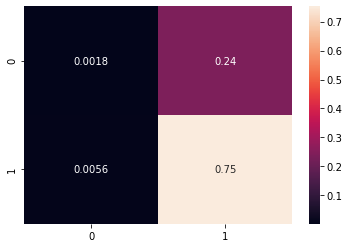

In [30]:
threshold = 0.65
y_valid_pred = (model.predict(X_valid) >= threshold).astype('int')

print(f'f1 score: {f1_score(y_valid, y_valid_pred)}')
print(f'accuracy score: {accuracy_score(y_valid, y_valid_pred)}')
print(classification_report(y_valid_pred, y_valid))

cm = confusion_matrix(y_valid, y_valid_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

f1 score: 0.8219633943427621
accuracy score: 0.699239417989418
              precision    recall  f1-score   support

           0       0.65      0.02      0.03      1833
           1       0.70      1.00      0.82      4215

    accuracy                           0.70      6048
   macro avg       0.68      0.51      0.43      6048
weighted avg       0.69      0.70      0.58      6048



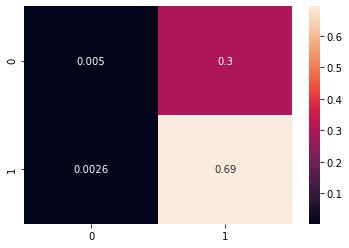

In [31]:
threshold = 0.65
y_pred = (model.predict(X_test) >= threshold).astype('int')

print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

In [ ]:
prediction_valid = pd.DataFrame()

In [100]:
data_test['predict_political_news_lightgbm'] = model.predict(X_test)

<ipython-input-100-780746dc9544>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['predict_political_news_lightgbm'] = model.predict(X_test)


In [52]:
data_test['predict_historical_data_lightgbm'].describe()

count    6048.000000
mean        0.700456
std         0.021103
min         0.666308
25%         0.686594
50%         0.696659
75%         0.707678
max         0.777539
Name: predict_historical_data_lightgbm, dtype: float64

In [56]:
threshold = 0.65
y_pred = (model.predict(X_test) >= threshold).astype('int')

print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

<ipython-input-56-c800d0237547>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['predict'] = y_pred


In [53]:
label

'label_next10_max'

In [75]:
list_cols_training = train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols + \
                       stock_news_cols + stock_market_news_cols + \
                       political_news_cols + indicator_news_cols

In [79]:
kf = KFold(n_splits=5)

params = {
    "objective": "binary", # ,"regression"
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
#     "num_leaves": 50,
#     "max_bin": 32,
    "feature_fraction": 0.55,
    "bagging_fraction" : 0.55,
#     "bagging_freq" : 0,
#     "max_depth" : 20,
#     "verbosity": 100,
#     "drop_rate": 0.1,
#     "is_unbalance": False,
#     "max_drop": 50,
#     "min_child_samples": 10,
#     "min_child_weight": 150,
#     "lambda_l1" : 10.,
#     "lambda_l2" : 10.,
#     "min_split_gain": 0,
    "num_threads" : -1,
    "metric" : "binary_logloss"
    # "metric" : "rmse"
}

models = []

for fold, (train_index, _) in enumerate(kf.split(data_train)):
    X_train = data_train.iloc[train_index][list_cols_training]
    y_train = data_train.iloc[train_index][label]
    
#     X_valid = data_train_valid.iloc[valid_index][list_cols_training]
#     y_valid = data_train_valid.iloc[valid_index][label]
    
    dtrain = lgb.Dataset(X_train, y_train)
    dvalid = lgb.Dataset(X_valid, y_valid, reference=dtrain)
    
    print('*' * 50)
    print(f'training with fold {fold}')
    
    model = lgb.train(params=params, 
                      train_set=dtrain, 
                      num_boost_round=5000, 
                      valid_sets=[dtrain, dvalid], 
                      verbose_eval=20,
                      early_stopping_rounds=50)
     
    models.append(model)

**************************************************
training with fold 0
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 382576, number of negative: 672145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.260142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29046
[LightGBM] [Info] Number of data points in the train set: 1054721, number of used features: 129
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.362727 -> initscore=-0.563547
[LightGBM] [Info] Start training from score -0.563547
Training until validation scores don't improve for 50 rounds
[20]	training's binary_logloss: 0.63542	valid_1's binary_logloss: 0.69144
[40]	training's binary_logloss: 0.622267	valid_1's binary_logloss: 0.693279
[60]	training's binary_logloss: 0.61355	valid_1's bina

In [83]:
preds = []

threshold = 0.45

for model in models:
    pred = model.predict(X_valid)
    preds.append(pred)
    
y_pred = (np.array(preds).T.mean(axis=1) >= threshold).astype('int')

print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.98      0.72     22971
           1       0.49      0.03      0.05     17783

    accuracy                           0.56     40754
   macro avg       0.53      0.50      0.38     40754
weighted avg       0.53      0.56      0.43     40754



In [88]:
preds = []
threshold = 0.4

for model in models:
    pred = model.predict(X_test)
    preds.append(pred)
    
y_pred = (np.array(preds).T.mean(axis=1) >= threshold).astype('int')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.88      0.76     20404
           1       0.43      0.17      0.24     10912

    accuracy                           0.63     31316
   macro avg       0.55      0.52      0.50     31316
weighted avg       0.58      0.63      0.58     31316



In [89]:
tmp = pd.DataFrame(y_pred, columns=['label']).groupby('label').size().reset_index()
tmp['percent'] = tmp[0] / tmp[0].sum()
tmp

,label,0,percent
0,0,27000,0.862179
1,1,4316,0.137821


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

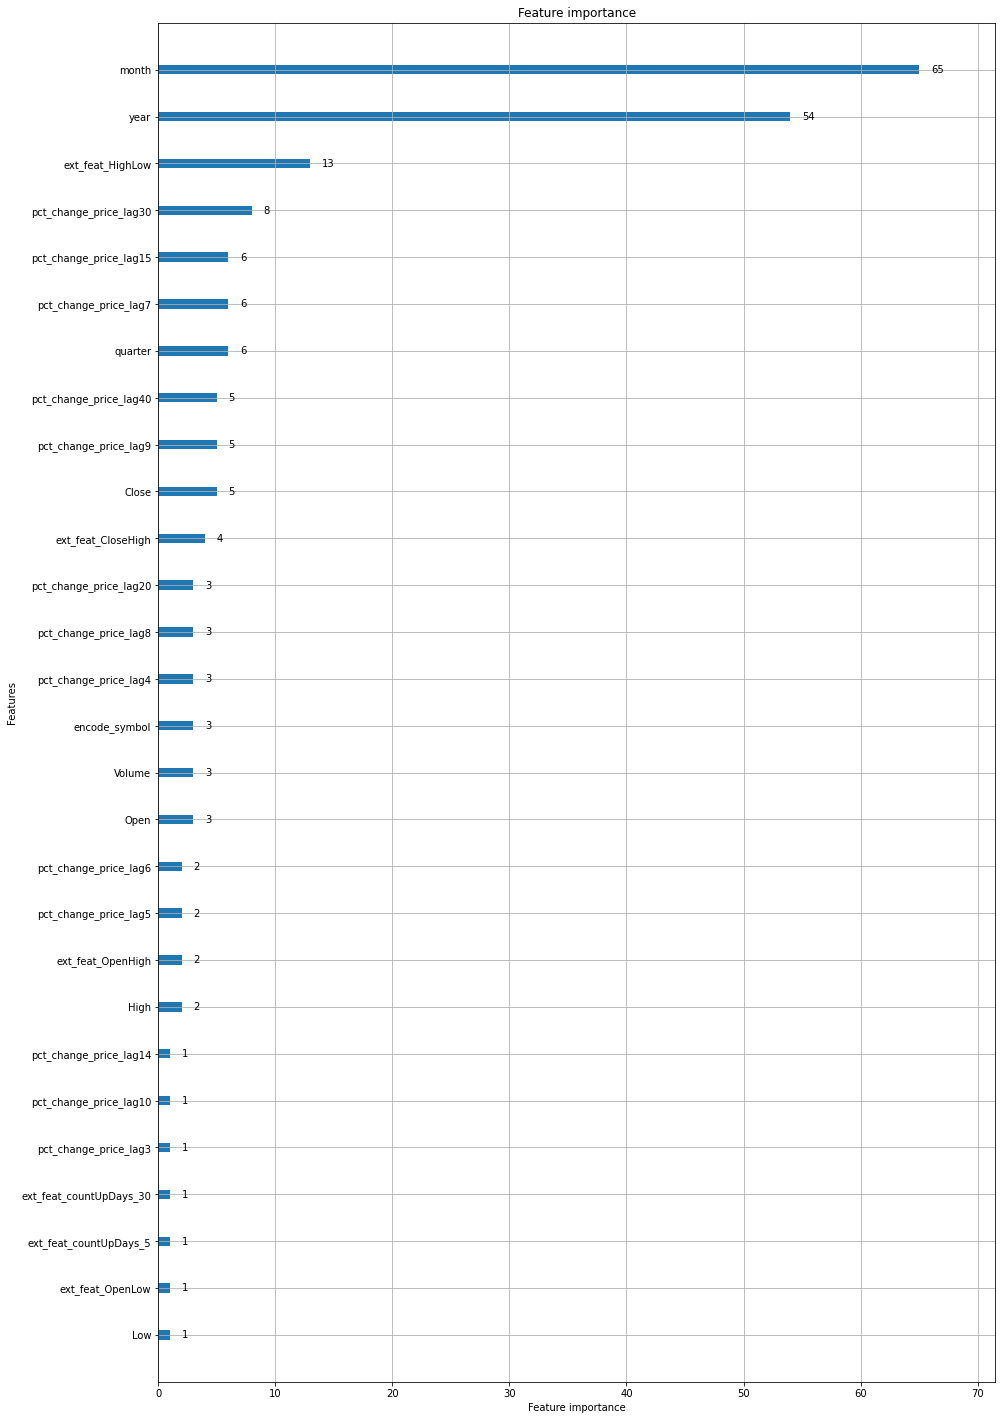

In [54]:
fig, ax = plt.subplots(figsize=(15, 25))
lgb.plot_importance(model, ax=ax)

In [74]:
# train_valid_date_start = '2015-01-01'
# # valid_date_start = '2020-01-01'
# test_date_start = '2021-04-01'
# test_date_end = '2021-07-31'

# data_train_valid = df[(df["Date"] >= train_valid_date_start) & (df["Date"] < test_date_start)]
# data_test = df[(df["Date"] >= test_date_start) & (df["Date"] <= test_date_end)]

In [90]:
list_cols_training = train_cols + pct_change_lag_cols + ta_cols + \
                       stock_news_cols + stock_market_news_cols + \
                       political_news_cols + indicator_news_cols

label = ['label']

In [78]:
# X_train_val = data_train_valid[list_cols_training]
# y_train_val = data_train_valid[label]

# X_test = data_test[list_cols_training]
# y_test = data_test[label]

In [79]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, 
                                                      test_size=0.2, stratify=y_train_val, 
                                                      random_state=1000)

In [77]:
{'bagging_fraction': 0.4,
 'feature_fraction': 0.19,
 'lambda_l1': 0.18631127390631108,
 'lambda_l2': 0.5449412634798939,
 'learning_rate': 0.09,
 'max_depth': 7,
 'min_data_in_leaf': 95.0,
 'num_leaves': 12.0}

{'bagging_fraction': 0.4,
 'feature_fraction': 0.19,
 'lambda_l1': 0.18631127390631108,
 'lambda_l2': 0.5449412634798939,
 'learning_rate': 0.09,
 'max_depth': 7,
 'min_data_in_leaf': 95.0,
 'num_leaves': 12.0}

In [ ]:
def objective(space):
    print("Training with params: ")
    print(space)
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "boosting_type": "gbdt",
        "n_estimators": 10000,
        "early_stopping_round": 100,
        "device": "gpu",
        "gpu_platform_id": 0,
        "gpu_device_id": 0,
        "learning_rate" : space['learning_rate'],
        "max_depth" : int(space['max_depth']),
        "num_leaves": int(space['num_leaves']),
        "feature_fraction" : space['feature_fraction'],
        "bagging_fraction" : space['bagging_fraction'],
        "lambda_l1" : space['lambda_l1'],
        "lambda_l2" : space['lambda_l2'],
        "min_data_in_leaf" : int(space['min_data_in_leaf']),
        "verbose" : -1
    }
    
    dtrain = lgb.Dataset(X_train, y_train)
    dvalid = lgb.Dataset(X_valid, y_valid, reference=dtrain)
    
    classifier = lgb.train(params=params, 
                           train_set=dtrain, 
                           valid_sets=[dtrain, dvalid], 
                           verbose_eval=50)

    threshold = 0.65
    y_pred = (classifier.predict(X_test) >= threshold).astype('int')
    score = f1_score(y_test, y_pred)
    print("\tScore {0}\n\n".format(score))
    
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}

space = {
    'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.1, 0.01),
    'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 10, 100, 1),
    'feature_fraction' : hp.quniform('feature_fraction', 0.1, 1, 0.01),
    'bagging_fraction': hp.quniform('bagging_fraction', 0.1, 1, 0.01),
    'num_leaves': hp.quniform('num_leaves', 5, 100, 1),
    'lambda_l1': hp.uniform('lambda_l1', 0.0, 1.0),
    'lambda_l2': hp.uniform('lambda_l2', 0.0, 1.0),
}

best = fmin(fn=objective, 
            space=space,
            algo=tpe.suggest,  
            max_evals=300)

# Test The Predictive Value of News Sentiment

# Stock Prediction for Sectors

In [34]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,company_name,sector,adjClose_next10_max,label_next10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter,year,encode_symbol,stock_news_in_day,stock_news_vader_neg,stock_news_vader_pos,stock_news_vader_neu,stock_news_vader_compound,stock_news_lm_pos,stock_news_lm_neg,stock_news_lm_polar,stock_news_lm_subject,political_news_in_day,political_news_vader_neg,political_news_vader_pos,political_news_vader_neu,political_news_vader_compound
0,2010-01-04,0.001455,0.001432,0.001468,0.001454,0.001213,0.262483,AAPL,Apple Inc.,Information Technology,6.594175,0,0.015565,0.011199,0.023482,0.011342,0.023776,0.058932,0.068128,0.079605,0.095073,0.115449,0.097319,0.102179,0.086456,0.099348,0.089498,0.089221,0.039086,0.121587,0.002717,1,0.005013,-0.004920,0.002290,-0.007616,0.009982,2.0,7.0,10.0,13.0,0.001096,0.001114,0.001125,0.001066,0.001143,0.001180,0.001202,67.302512,81.375554,78.038721,80.785168,1.222138,3.755990,-0.270175,0.149661,11.544894,1,1,2010,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.000,0.248,2.752,0.5106
1,2010-01-05,0.001466,0.001442,0.001476,0.001458,0.001216,0.319992,AAPL,Apple Inc.,Information Technology,6.594175,0,0.001729,0.017321,0.012947,0.025251,0.013090,0.025545,0.060762,0.069974,0.081471,0.096965,0.117377,0.099216,0.104084,0.088334,0.101248,0.108939,0.069174,0.104881,-0.001025,0,0.004613,-0.006291,0.005644,-0.005271,0.010973,2.0,6.0,10.0,13.0,0.001105,0.001116,0.001134,0.001072,0.001160,0.001191,0.001208,67.650234,81.695276,78.837235,81.246614,1.521895,3.750165,-0.135253,0.144940,9.696543,1,1,2010,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.000,0.000,4.000,0.0000
2,2010-01-06,0.001464,0.001438,0.001452,0.001425,0.001188,0.293546,AAPL,Apple Inc.,Information Technology,6.594175,1,-0.015906,-0.014205,0.001139,-0.003166,0.008943,-0.003024,0.009233,0.043889,0.052955,0.064269,0.079517,0.099604,0.081731,0.086522,0.071023,0.116539,0.055272,0.085572,-0.015906,0,0.003965,-0.016933,0.020192,-0.001043,0.021257,2.0,5.0,10.0,12.0,0.001114,0.001117,0.001139,0.001076,0.001159,0.001197,0.001221,61.190556,70.667228,77.912686,79.144460,1.246911,3.609146,-0.102180,0.146016,6.426904,1,1,2010,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.000,0.990,3.010,0.6794
3,2010-01-07,0.001438,0.001408,0.001435,0.001421,0.001185,0.253659,AAPL,Apple Inc.,Information Technology,6.594175,1,-0.001849,-0.017726,-0.016028,-0.000712,-0.005009,0.007078,-0.004868,0.007367,0.041959,0.051008,0.062301,0.077521,0.097571,0.079731,0.084513,0.109074,0.022829,0.045269,-0.005525,0,0.001181,-0.012751,0.006743,-0.007266,0.014112,1.0,4.0,9.0,11.0,0.001123,0.001119,0.001143,0.001080,0.001162,0.001198,0.001219,60.479105,47.770731,66.711078,72.445008,1.009293,3.614184,-0.129382,0.143112,5.100786,1,1,2010,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.214,0.866,3.920,0.8167
4,2010-01-08,0.001425,0.001408,0.001436,0.001435,0.001196,0.237965,AAPL,Apple Inc.,Information Technology,6.594175,1,0.006648,0.004787,-0.011195,-0.009486,0.005932,0.001606,0.013773,0.001748,0.014064,0.048887,0.057995,0.069364,0.084685,0.104868,0.086910,0.071688,0.036881,0.044339,0.007989,1,0.008084,-0.005896,0.000094,-0.013775,0.014063,2.0,4.0,9.0,12.0,0.001129,0.001121,0.001149,0.001084,0.001158,0.001196,0.001220,62

In [35]:
df['sector'].unique()

array(['Information Technology', 'Health Care', 'Financials',
       'Real Estate', 'Consumer Discretionary', 'Industrials',
       'Communication Services', 'Consumer Staples', 'Energy',
       'Materials', 'Utilities'], dtype=object)

In [38]:
def write_log(log, text_write):
    print(log)
    text_write += log + '\n'
    return text_write

In [46]:
train_date_start = '2010-01-01'
valid_date_start = '2019-10-01'
test_date_start = '2021-05-01'
test_date_end = '2021-07-31'

count = 0
threshold = 0.65
text_write = ''
for sector in df['sector'].unique():
    data_train = df[(df["Date"] >= train_date_start) & (df["Date"] < valid_date_start) & (df['sector']==sector)]
    data_valid = df[(df["Date"] >= valid_date_start) & (df["Date"] < test_date_start)  & (df['sector']==sector)]
    data_test = df[(df["Date"] >= test_date_start) & (df["Date"] <= test_date_end)  & (df['sector']==sector)]
    
    list_cols_train = train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols  \
                         + political_news_cols \
                         + stock_news_cols 
    
    X_train = data_train[list_cols_train]
    y_train = data_train[label]

    X_valid = data_valid[list_cols_train]
    y_valid = data_valid[label]

    X_test = data_test[list_cols_train]
    y_test = data_test[label]
    
    text_write = write_log('*' * 50, text_write)
    text_write = write_log(f'start mode with sector "{sector}"', text_write)
    text_write = write_log(f'start training date: "{train_date_start}"', text_write)
    text_write = write_log(f'start validation date: "{valid_date_start}"', text_write)
    text_write = write_log(f'start test date: "{test_date_start}"', text_write)
    text_write = write_log(f'end test date: "{test_date_end}"', text_write)
    text_write = write_log('list cols training: train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_cols', text_write)
    
    # model here
    params = {'objective':'binary:logistic',
              'max_depth': 6, # default 6
    #           'alpha': 10,
              'gamma' : 0.44,
              'subsample' : 0.73,
              'colsample_bytree' : 0.23, 
              'min_child_weight' : 6,
              'learning_rate': 0.03,
              'eval_metric' : 'logloss',
              'n_estimators' : 1000,
              'verbosity' : 0,
             }    

    model = XGBClassifier(**params) 
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              early_stopping_rounds=100,
              verbose=20)

    y_pred_raw = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_raw >= threshold).astype('int')

    text_write = write_log(f'threshold: {threshold}', text_write)
    text_write = write_log(f'f1 score: {f1_score(y_test, y_pred)}', text_write)
    text_write = write_log(f'accuracy score: {accuracy_score(y_test, y_pred)}', text_write)
    text_write = write_log(classification_report(y_test, y_pred), text_write)

    count += 1
    
with open('./exported_data/us_ket qua tinh theo tung sector_20211011.txt', 'a') as f:
    f.write(text_write)

**************************************************
start mode with sector "Information Technology"
start training date: "2010-01-01"
start validation date: "2019-10-01"
start test date: "2021-05-01"
end test date: "2021-07-31"
list cols training: train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_cols
[0]	validation_0-logloss:0.68620	validation_1-logloss:0.68449


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.60258	validation_1-logloss:0.59356
[40]	validation_0-logloss:0.56835	validation_1-logloss:0.56037
[60]	validation_0-logloss:0.55134	validation_1-logloss:0.54698
[80]	validation_0-logloss:0.54001	validation_1-logloss:0.54372
[100]	validation_0-logloss:0.53170	validation_1-logloss:0.54387
[120]	validation_0-logloss:0.52442	validation_1-logloss:0.54663
[140]	validation_0-logloss:0.51751	validation_1-logloss:0.54778
[160]	validation_0-logloss:0.51148	validation_1-logloss:0.54957
[180]	validation_0-logloss:0.50527	validation_1-logloss:0.55215
[192]	validation_0-logloss:0.50241	validation_1-logloss:0.55149
threshold: 0.65
f1 score: 0.6560449859418932
accuracy score: 0.5518925518925519
              precision    recall  f1-score   support

           0       0.25      0.63      0.36       162
           1       0.85      0.53      0.66       657

    accuracy                           0.55       819
   macro avg       0.55      0.58      0.51       819
weighted avg

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.62375	validation_1-logloss:0.62645
[40]	validation_0-logloss:0.59681	validation_1-logloss:0.60476
[60]	validation_0-logloss:0.58230	validation_1-logloss:0.59929
[80]	validation_0-logloss:0.57250	validation_1-logloss:0.59488
[100]	validation_0-logloss:0.56449	validation_1-logloss:0.59338
[120]	validation_0-logloss:0.55724	validation_1-logloss:0.59566
[140]	validation_0-logloss:0.54890	validation_1-logloss:0.59714
[160]	validation_0-logloss:0.54193	validation_1-logloss:0.60047
[180]	validation_0-logloss:0.53729	validation_1-logloss:0.60316
[200]	validation_0-logloss:0.53094	validation_1-logloss:0.60444
threshold: 0.65
f1 score: 0.6214788732394366
accuracy score: 0.544973544973545
              precision    recall  f1-score   support

           0       0.34      0.59      0.43       273
           1       0.76      0.53      0.62       672

    accuracy                           0.54       945
   macro avg       0.55      0.56      0.53       945
weighted avg 

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.60904	validation_1-logloss:0.60159
[40]	validation_0-logloss:0.57518	validation_1-logloss:0.56787
[60]	validation_0-logloss:0.55685	validation_1-logloss:0.55329
[80]	validation_0-logloss:0.54478	validation_1-logloss:0.54630
[100]	validation_0-logloss:0.53507	validation_1-logloss:0.54335
[120]	validation_0-logloss:0.52670	validation_1-logloss:0.54257
[140]	validation_0-logloss:0.51903	validation_1-logloss:0.54339
[160]	validation_0-logloss:0.51128	validation_1-logloss:0.54487
[180]	validation_0-logloss:0.50644	validation_1-logloss:0.54455
[200]	validation_0-logloss:0.50073	validation_1-logloss:0.54669
[220]	validation_0-logloss:0.49514	validation_1-logloss:0.54909
[225]	validation_0-logloss:0.49385	validation_1-logloss:0.54934
threshold: 0.65
f1 score: 0.7754491017964071
accuracy score: 0.6598639455782312
              precision    recall  f1-score   support

           0       0.34      0.26      0.30       242
           1       0.74      0.81      0.78    

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[40]	validation_0-logloss:0.53298	validation_1-logloss:0.57592
[60]	validation_0-logloss:0.49863	validation_1-logloss:0.56684
[80]	validation_0-logloss:0.47465	validation_1-logloss:0.55905
[100]	validation_0-logloss:0.45684	validation_1-logloss:0.56174
[120]	validation_0-logloss:0.43916	validation_1-logloss:0.56901
[140]	validation_0-logloss:0.42470	validation_1-logloss:0.57041
[160]	validation_0-logloss:0.40981	validation_1-logloss:0.57374
[180]	validation_0-logloss:0.39405	validation_1-logloss:0.57515
threshold: 0.65
f1 score: 0.8773584905660378
accuracy score: 0.7936507936507936
              precision    recall  f1-score   support

           0       0.54      0.26      0.35        27
           1       0.82      0.94      0.88        99

    accuracy                           0.79       126
   macro avg       0.68      0.60      0.61       126
weighted avg       0.76      0.79      0.76       126

**************************************************
start mode with sector "Consumer 

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.60796	validation_1-logloss:0.60277
[40]	validation_0-logloss:0.57504	validation_1-logloss:0.57370
[60]	validation_0-logloss:0.55692	validation_1-logloss:0.56181
[80]	validation_0-logloss:0.54545	validation_1-logloss:0.55844
[100]	validation_0-logloss:0.53636	validation_1-logloss:0.56283
[120]	validation_0-logloss:0.52824	validation_1-logloss:0.56392
[140]	validation_0-logloss:0.52086	validation_1-logloss:0.57137
[160]	validation_0-logloss:0.51297	validation_1-logloss:0.57614
[177]	validation_0-logloss:0.50802	validation_1-logloss:0.57977
threshold: 0.65
f1 score: 0.6408010012515645
accuracy score: 0.5444444444444444
              precision    recall  f1-score   support

           0       0.36      0.40      0.38       218
           1       0.66      0.62      0.64       412

    accuracy                           0.54       630
   macro avg       0.51      0.51      0.51       630
weighted avg       0.56      0.54      0.55       630

*********************

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.62027	validation_1-logloss:0.61974
[40]	validation_0-logloss:0.59155	validation_1-logloss:0.59148
[60]	validation_0-logloss:0.57377	validation_1-logloss:0.57981
[80]	validation_0-logloss:0.56185	validation_1-logloss:0.57384
[100]	validation_0-logloss:0.55119	validation_1-logloss:0.57478
[120]	validation_0-logloss:0.54192	validation_1-logloss:0.57474
[140]	validation_0-logloss:0.53342	validation_1-logloss:0.57715
[160]	validation_0-logloss:0.52558	validation_1-logloss:0.57917
[180]	validation_0-logloss:0.51910	validation_1-logloss:0.58034
[181]	validation_0-logloss:0.51886	validation_1-logloss:0.58038
threshold: 0.65
f1 score: 0.5773195876288659
accuracy score: 0.5494505494505495
              precision    recall  f1-score   support

           0       0.45      0.61      0.52       322
           1       0.67      0.51      0.58       497

    accuracy                           0.55       819
   macro avg       0.56      0.56      0.55       819
weighted avg

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.60681	validation_1-logloss:0.63470
[40]	validation_0-logloss:0.57317	validation_1-logloss:0.61980
[60]	validation_0-logloss:0.55491	validation_1-logloss:0.61603
[80]	validation_0-logloss:0.54220	validation_1-logloss:0.61491
[100]	validation_0-logloss:0.53102	validation_1-logloss:0.62125
[120]	validation_0-logloss:0.52066	validation_1-logloss:0.62875
[140]	validation_0-logloss:0.51258	validation_1-logloss:0.63802
[160]	validation_0-logloss:0.50522	validation_1-logloss:0.65067
[172]	validation_0-logloss:0.50123	validation_1-logloss:0.65753
threshold: 0.65
f1 score: 0.6147859922178989
accuracy score: 0.5285714285714286
              precision    recall  f1-score   support

           0       0.34      0.46      0.39       210
           1       0.68      0.56      0.61       420

    accuracy                           0.53       630
   macro avg       0.51      0.51      0.50       630
weighted avg       0.56      0.53      0.54       630

*********************

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.63350	validation_1-logloss:0.63456
[40]	validation_0-logloss:0.60777	validation_1-logloss:0.61785
[60]	validation_0-logloss:0.59189	validation_1-logloss:0.61389
[80]	validation_0-logloss:0.57996	validation_1-logloss:0.61305
[100]	validation_0-logloss:0.56839	validation_1-logloss:0.61345
[120]	validation_0-logloss:0.56088	validation_1-logloss:0.61465
[140]	validation_0-logloss:0.55241	validation_1-logloss:0.61587
[160]	validation_0-logloss:0.54553	validation_1-logloss:0.61853
[180]	validation_0-logloss:0.53835	validation_1-logloss:0.61943
[183]	validation_0-logloss:0.53740	validation_1-logloss:0.61984
threshold: 0.65
f1 score: 0.6417112299465241
accuracy score: 0.5165945165945166
              precision    recall  f1-score   support

           0       0.27      0.25      0.26       233
           1       0.63      0.65      0.64       460

    accuracy                           0.52       693
   macro avg       0.45      0.45      0.45       693
weighted avg

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[40]	validation_0-logloss:0.57153	validation_1-logloss:0.61221
[60]	validation_0-logloss:0.54229	validation_1-logloss:0.61303
[80]	validation_0-logloss:0.52122	validation_1-logloss:0.61419
[100]	validation_0-logloss:0.50211	validation_1-logloss:0.61751
[120]	validation_0-logloss:0.48935	validation_1-logloss:0.62372
[140]	validation_0-logloss:0.47464	validation_1-logloss:0.62812
[153]	validation_0-logloss:0.46381	validation_1-logloss:0.62923
threshold: 0.65
f1 score: 0.6692913385826771
accuracy score: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.28      0.38      0.32        52
           1       0.73      0.62      0.67       137

    accuracy                           0.56       189
   macro avg       0.50      0.50      0.50       189
weighted avg       0.60      0.56      0.57       189

**************************************************
start mode with sector "Materials"
start training date: "2010-01-01"
start validation date: "2019

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[80]	validation_0-logloss:0.41840	validation_1-logloss:0.58418
[100]	validation_0-logloss:0.39520	validation_1-logloss:0.59226
[120]	validation_0-logloss:0.37377	validation_1-logloss:0.59369
[140]	validation_0-logloss:0.35505	validation_1-logloss:0.59827
[142]	validation_0-logloss:0.35357	validation_1-logloss:0.59878
threshold: 0.65
f1 score: 0.39285714285714285
accuracy score: 0.4603174603174603
              precision    recall  f1-score   support

           0       0.37      0.86      0.51        21
           1       0.79      0.26      0.39        42

    accuracy                           0.46        63
   macro avg       0.58      0.56      0.45        63
weighted avg       0.65      0.46      0.43        63

**************************************************
start mode with sector "Utilities"
start training date: "2010-01-01"
start validation date: "2019-10-01"
start test date: "2021-05-01"
end test date: "2021-07-31"
list cols training: train_cols +  ext_feature_cols + pct_ch

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[40]	validation_0-logloss:0.57509	validation_1-logloss:0.59790
[60]	validation_0-logloss:0.55014	validation_1-logloss:0.58538
[80]	validation_0-logloss:0.53029	validation_1-logloss:0.58222
[100]	validation_0-logloss:0.51349	validation_1-logloss:0.58157
[120]	validation_0-logloss:0.49979	validation_1-logloss:0.58238
[140]	validation_0-logloss:0.48482	validation_1-logloss:0.58394
[160]	validation_0-logloss:0.47325	validation_1-logloss:0.58722
[180]	validation_0-logloss:0.46206	validation_1-logloss:0.58830
[188]	validation_0-logloss:0.45838	validation_1-logloss:0.58983
threshold: 0.65
f1 score: 0.7534626038781163
accuracy score: 0.6468253968253969
              precision    recall  f1-score   support

           0       0.39      0.37      0.38        73
           1       0.75      0.76      0.75       179

    accuracy                           0.65       252
   macro avg       0.57      0.56      0.57       252
weighted avg       0.64      0.65      0.64       252



C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [67]:
train_date_start = datetime.date(2010, 1, 1)

valid_date_end = datetime.date(2016, 6, 30)
valid_date_start = (valid_date_end - relativedelta.relativedelta(months=5)).replace(day=1)

train_date_end = valid_date_start - datetime.timedelta(days=1)

test_date_start = datetime.date(2021, 1, 1)
test_date_end = datetime.date(2021, 7, 31)

count = 0
predictions = []
while True:    
    print('*' * 50)
    print('mode', count)
    print('train_date_start', train_date_start)
    print('train_date_end  ', train_date_end)
    
    print('valid_date_start', valid_date_start)
    print('valid_date_end  ', valid_date_end)
    
    print('test_date_start ', test_date_start)
    print('test_date_end   ', test_date_end)
    
    #filter data
    data_train = df[(df["Date"] >= train_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= train_date_end.strftime('%Y-%m-%d'))].copy()
    data_valid = df[(df["Date"] >= valid_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= valid_date_end.strftime('%Y-%m-%d'))].copy()
    data_test = df[(df["Date"] >= test_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= test_date_end.strftime('%Y-%m-%d'))].copy()    
    
    list_training_cols = train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols \
#                          + political_news_cols #+ political_news_cols
    
    X_train = data_train[list_training_cols]
    y_train = data_train[label]
    
    X_valid = data_valid[list_training_cols]
    y_valid = data_valid[label]
    
    X_test = data_test[list_training_cols]
    y_test = data_test[label]
    
    tmp = data_test.copy()        
    
    # model here
    params = {'objective':'binary:logistic',
              'max_depth': 6, # default 6
    #           'alpha': 10,
              'gamma' : 0.44,
              'subsample' : 0.73,
              'colsample_bytree' : 0.23, 
              'min_child_weight' : 6,
              'learning_rate': 0.03,
              'eval_metric' : 'logloss',
              'n_estimators' : 1000,
              'verbosity' : 0,
             }    

    model = XGBClassifier(**params) 
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              early_stopping_rounds=100,
              verbose=20)
    
    y_pred_raw = model.predict_proba(X_test)[:, 1]
    predictions.append(y_pred_raw)
    
    # move to next period
    valid_date_start = valid_date_end + datetime.timedelta(days=1)
    valid_date_end = (valid_date_end + relativedelta.relativedelta(months=7)).replace(day=1) - datetime.timedelta(days=1)
    
    train_date_end = valid_date_start - datetime.timedelta(days=1)
    
    #check
    if valid_date_end >= test_date_start:
        break
    
    count += 1

**************************************************
mode 0
train_date_start 2010-01-01
train_date_end   2015-12-31
valid_date_start 2016-01-01
valid_date_end   2016-06-30
test_date_start  2021-01-01
test_date_end    2021-07-31


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68705	validation_1-logloss:0.68766
[20]	validation_0-logloss:0.62058	validation_1-logloss:0.61670
[40]	validation_0-logloss:0.59562	validation_1-logloss:0.59206
[60]	validation_0-logloss:0.58444	validation_1-logloss:0.58210
[80]	validation_0-logloss:0.57728	validation_1-logloss:0.57815
[100]	validation_0-logloss:0.57178	validation_1-logloss:0.57793
[120]	validation_0-logloss:0.56803	validation_1-logloss:0.57881
[140]	validation_0-logloss:0.56454	validation_1-logloss:0.57960
[160]	validation_0-logloss:0.56123	validation_1-logloss:0.58073
[180]	validation_0-logloss:0.55799	validation_1-logloss:0.58201
[197]	validation_0-logloss:0.55545	validation_1-logloss:0.58241
**************************************************
mode 1
train_date_start 2010-01-01
train_date_end   2016-06-30
valid_date_start 2016-07-01
valid_date_end   2016-12-31
test_date_start  2021-01-01
test_date_end    2021-07-31


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[0]	validation_0-logloss:0.68712	validation_1-logloss:0.69024
[20]	validation_0-logloss:0.61991	validation_1-logloss:0.65330
[40]	validation_0-logloss:0.59560	validation_1-logloss:0.64555
[60]	validation_0-logloss:0.58374	validation_1-logloss:0.64550
[80]	validation_0-logloss:0.57632	validation_1-logloss:0.64601
[100]	validation_0-logloss:0.57189	validation_1-logloss:0.64741
[120]	validation_0-logloss:0.56734	validation_1-logloss:0.64773
[140]	validation_0-logloss:0.56361	validation_1-logloss:0.64804
[150]	validation_0-logloss:0.56242	validation_1-logloss:0.64864
**************************************************
mode 2
train_date_start 2010-01-01
train_date_end   2016-12-31
valid_date_start 2017-01-01
valid_date_end   2017-06-30
test_date_start  2021-01-01
test_date_end    2021-07-31
[0]	validation_0-logloss:0.68727	validation_1-logloss:0.69015
[20]	validation_0-logloss:0.62164	validation_1-logloss:0.65378
[40]	validation_0-logloss:0.59754	validation_1-logloss:0.64578
[60]	validation_

**************************************************
model for us stocks - with cross validation
threshold : 0.65
list cols training: train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols
f1 score: 0.7895682624521955
accuracy score: 0.6719109195402299
              precision    recall  f1-score   support

           0       0.32      0.22      0.26      3647
           1       0.75      0.83      0.79     10273

    accuracy                           0.67     13920
   macro avg       0.53      0.52      0.52     13920
weighted avg       0.64      0.67      0.65     13920



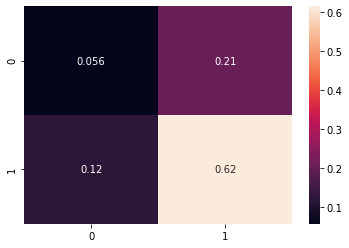

In [68]:
test_prediction = pd.DataFrame(np.array(predictions).T)

threshold = 0.65
y_pred = test_prediction.sum(axis=1) / len(test_prediction.columns)
y_pred = (y_pred >= threshold).astype(int)

print('*' * 50)
print('model for us stocks - with cross validation')
print(f'threshold : {threshold}')
print('list cols training: train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

# Parameter Tuning


# Stock Prediction using XGB


# Stock Prediction using XGB (Nested Cross Validation)


In [58]:
train_date_start = datetime.date(2010, 1, 1)

test_date_start = datetime.date(2016, 1, 1)
test_date_end = (test_date_start + relativedelta.relativedelta(months=6)).replace(day=1) - datetime.timedelta(days=1)

valid_date_end = test_date_start - datetime.timedelta(days=1)
valid_date_start = (valid_date_end - relativedelta.relativedelta(months=5)).replace(day=1)

train_date_end = valid_date_start - datetime.timedelta(days=1)

count = 0
prediction = None
while True:
    print('*' * 50)
    print('mode', count)
    print('train_date_start', train_date_start)
    print('train_date_end  ', train_date_end)
    
    print('valid_date_start', valid_date_start)
    print('valid_date_end  ', valid_date_end)
    
    print('test_date_start ', test_date_start)
    print('test_date_end   ', test_date_end)
    
    #filter data
    data_train = df[(df["Date"] >= train_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= train_date_end.strftime('%Y-%m-%d'))].copy()
    data_valid = df[(df["Date"] >= valid_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= valid_date_end.strftime('%Y-%m-%d'))].copy()
    data_test = df[(df["Date"] >= test_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= test_date_end.strftime('%Y-%m-%d'))].copy()    
    
    X_train = data_train[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols 
                         + stock_news_cols + political_news_cols]
    y_train = data_train[[label]]
    
    X_valid = data_valid[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols 
                         + stock_news_cols + political_news_cols]
    y_valid = data_valid[[label]]
    
    X_test = data_test[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols 
                         + stock_news_cols + political_news_cols]
    y_test = data_test[[label]]
    
    tmp = data_test.copy()        
    
    # model here
    params = {'objective':'binary:logistic',
              'max_depth': 6, # default 6
    #           'alpha': 10,
              'gamma' : 0.06,
              'subsample' : 0.14,
              'colsample_bytree' : 0.17, 
              'min_child_weight' : 9,
              'learning_rate': 0.04,
              'eval_metric' : 'logloss',
              'n_estimators' : 1000,
              'verbosity' : 0,
             }

    model = XGBClassifier(**params) 
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              early_stopping_rounds=100,
              verbose=20)
    
    y_pred_raw = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_raw >= threshold).astype('int')
    
    threshold = 0.6
    print('threshold', threshold)
    print(f'f1 score: {f1_score(y_test, y_pred)}')
    print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred))
    
    tmp = data_test.copy()
    tmp['prediction'] = y_pred_raw
    
    if prediction is None:
        prediction = tmp.copy()
    else:
        prediction = pd.concat([prediction, tmp], axis=0)
    
    #check
    if test_date_end >= df['Date'].max():
        break
    
    # move to next period
    test_date_start = test_date_end + datetime.timedelta(days=1)
    test_date_end = (test_date_end + relativedelta.relativedelta(months=7)).replace(day=1) - datetime.timedelta(days=1)
    
    if test_date_start >= datetime.date(2021, 1, 1):
        test_date_end += relativedelta.relativedelta(months=5)
    
    valid_date_end = test_date_start - datetime.timedelta(days=1)
    valid_date_start = (valid_date_end - relativedelta.relativedelta(months=3)).replace(day=1)

    train_date_end = valid_date_start - datetime.timedelta(days=1)
    
    count += 1

**************************************************
mode 0
train_date_start 2010-01-01
train_date_end   2015-06-30
valid_date_start 2015-07-01
valid_date_end   2015-12-31
test_date_start  2016-01-01
test_date_end    2016-06-30
[0]	validation_0-logloss:0.68537	validation_1-logloss:0.68650


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20]	validation_0-logloss:0.61000	validation_1-logloss:0.62553
[40]	validation_0-logloss:0.59028	validation_1-logloss:0.61431
[60]	validation_0-logloss:0.58277	validation_1-logloss:0.61318
[80]	validation_0-logloss:0.57789	validation_1-logloss:0.61230
[100]	validation_0-logloss:0.57400	validation_1-logloss:0.61334
[120]	validation_0-logloss:0.57132	validation_1-logloss:0.61430
[140]	validation_0-logloss:0.56846	validation_1-logloss:0.61401
[160]	validation_0-logloss:0.56630	validation_1-logloss:0.61484
[172]	validation_0-logloss:0.56535	validation_1-logloss:0.61490
threshold 0.6
f1 score: 0.8191701117746133
accuracy score: 0.70475
              precision    recall  f1-score   support

           0       0.34      0.14      0.20      3132
           1       0.75      0.90      0.82      8868

    accuracy                           0.70     12000
   macro avg       0.54      0.52      0.51     12000
weighted avg       0.64      0.70      0.66     12000

**********************************

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68532	validation_1-logloss:0.68673
[20]	validation_0-logloss:0.61174	validation_1-logloss:0.61450
[40]	validation_0-logloss:0.59226	validation_1-logloss:0.59208
[60]	validation_0-logloss:0.58370	validation_1-logloss:0.58335
[80]	validation_0-logloss:0.57923	validation_1-logloss:0.58100
[100]	validation_0-logloss:0.57486	validation_1-logloss:0.58131
[120]	validation_0-logloss:0.57168	validation_1-logloss:0.58226
[140]	validation_0-logloss:0.56938	validation_1-logloss:0.58260
[160]	validation_0-logloss:0.56722	validation_1-logloss:0.58459
[175]	validation_0-logloss:0.56564	validation_1-logloss:0.58531
threshold 0.6
f1 score: 0.7673603737523891
accuracy score: 0.6405839895013123
              precision    recall  f1-score   support

           0       0.51      0.13      0.21      4405
           1       0.65      0.93      0.77      7787

    accuracy                           0.64     12192
   macro avg       0.58      0.53      0.49     12192
weighted avg    

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[0]	validation_0-logloss:0.68564	validation_1-logloss:0.68831


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20]	validation_0-logloss:0.61239	validation_1-logloss:0.64020
[40]	validation_0-logloss:0.59230	validation_1-logloss:0.63191
[60]	validation_0-logloss:0.58374	validation_1-logloss:0.63369
[80]	validation_0-logloss:0.57927	validation_1-logloss:0.63557
[100]	validation_0-logloss:0.57546	validation_1-logloss:0.63658
[120]	validation_0-logloss:0.57323	validation_1-logloss:0.63728
[140]	validation_0-logloss:0.57035	validation_1-logloss:0.63846
[141]	validation_0-logloss:0.57032	validation_1-logloss:0.63846
threshold 0.6
f1 score: 0.7553712777987183
accuracy score: 0.6214166666666666
              precision    recall  f1-score   support

           0       0.34      0.11      0.16      4119
           1       0.66      0.89      0.76      7881

    accuracy                           0.62     12000
   macro avg       0.50      0.50      0.46     12000
weighted avg       0.55      0.62      0.55     12000

**************************************************
mode 3
train_date_start 2010-01-01
t

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68554	validation_1-logloss:0.69053
[20]	validation_0-logloss:0.61414	validation_1-logloss:0.67016
[40]	validation_0-logloss:0.59513	validation_1-logloss:0.67496
[60]	validation_0-logloss:0.58760	validation_1-logloss:0.68206
[80]	validation_0-logloss:0.58246	validation_1-logloss:0.68734
[100]	validation_0-logloss:0.57941	validation_1-logloss:0.68944
[119]	validation_0-logloss:0.57684	validation_1-logloss:0.69197
threshold 0.6
f1 score: 0.5376596681838203
accuracy score: 0.4793320105820106
              precision    recall  f1-score   support

           0       0.30      0.60      0.40      3532
           1       0.72      0.43      0.54      8564

    accuracy                           0.48     12096
   macro avg       0.51      0.52      0.47     12096
weighted avg       0.60      0.48      0.50     12096

**************************************************
mode 4
train_date_start 2010-01-01
train_date_end   2017-08-31
valid_date_start 2017-09-01
valid_date_

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68617	validation_1-logloss:0.68820
[20]	validation_0-logloss:0.61800	validation_1-logloss:0.61958
[40]	validation_0-logloss:0.59986	validation_1-logloss:0.60128
[60]	validation_0-logloss:0.59290	validation_1-logloss:0.59572
[80]	validation_0-logloss:0.58898	validation_1-logloss:0.59543
[100]	validation_0-logloss:0.58641	validation_1-logloss:0.59445
[120]	validation_0-logloss:0.58347	validation_1-logloss:0.59475
[140]	validation_0-logloss:0.58118	validation_1-logloss:0.59652
[160]	validation_0-logloss:0.57941	validation_1-logloss:0.59616
[180]	validation_0-logloss:0.57697	validation_1-logloss:0.59699
[200]	validation_0-logloss:0.57465	validation_1-logloss:0.59734
[215]	validation_0-logloss:0.57357	validation_1-logloss:0.59762
threshold 0.6
f1 score: 0.8172566152013107
accuracy score: 0.69325
              precision    recall  f1-score   support

           0       0.37      0.02      0.05      3617
           1       0.70      0.98      0.82      8383

    acc

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68605	validation_1-logloss:0.68756
[20]	validation_0-logloss:0.61733	validation_1-logloss:0.62731
[40]	validation_0-logloss:0.59921	validation_1-logloss:0.61624
[60]	validation_0-logloss:0.59099	validation_1-logloss:0.61583
[80]	validation_0-logloss:0.58717	validation_1-logloss:0.61467
[100]	validation_0-logloss:0.58446	validation_1-logloss:0.61553
[120]	validation_0-logloss:0.58200	validation_1-logloss:0.61552
[140]	validation_0-logloss:0.58005	validation_1-logloss:0.61573
[160]	validation_0-logloss:0.57859	validation_1-logloss:0.61587
[168]	validation_0-logloss:0.57763	validation_1-logloss:0.61556
threshold 0.6
f1 score: 0.805616850551655
accuracy score: 0.6795634920634921
              precision    recall  f1-score   support

           0       0.33      0.05      0.09      3679
           1       0.70      0.95      0.81      8417

    accuracy                           0.68     12096
   macro avg       0.51      0.50      0.45     12096
weighted avg     

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68597	validation_1-logloss:0.68735
[20]	validation_0-logloss:0.61732	validation_1-logloss:0.63414
[40]	validation_0-logloss:0.59951	validation_1-logloss:0.63183
[60]	validation_0-logloss:0.59304	validation_1-logloss:0.63767
[80]	validation_0-logloss:0.58981	validation_1-logloss:0.64351
[100]	validation_0-logloss:0.58645	validation_1-logloss:0.64844
[120]	validation_0-logloss:0.58455	validation_1-logloss:0.64997
[129]	validation_0-logloss:0.58353	validation_1-logloss:0.65112
threshold 0.6
f1 score: 0.8481576862123614
accuracy score: 0.7424395161290323
              precision    recall  f1-score   support

           0       0.30      0.10      0.15      2694
           1       0.78      0.93      0.85      9210

    accuracy                           0.74     11904
   macro avg       0.54      0.52      0.50     11904
weighted avg       0.67      0.74      0.69     11904

**************************************************
mode 7
train_date_start 2010-01-01
tra

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68613	validation_1-logloss:0.68653
[20]	validation_0-logloss:0.61686	validation_1-logloss:0.60192
[40]	validation_0-logloss:0.59921	validation_1-logloss:0.57978
[60]	validation_0-logloss:0.59345	validation_1-logloss:0.57034
[80]	validation_0-logloss:0.59006	validation_1-logloss:0.56658
[100]	validation_0-logloss:0.58757	validation_1-logloss:0.56526
[120]	validation_0-logloss:0.58561	validation_1-logloss:0.56452
[140]	validation_0-logloss:0.58360	validation_1-logloss:0.56254
[160]	validation_0-logloss:0.58205	validation_1-logloss:0.56330
[180]	validation_0-logloss:0.58049	validation_1-logloss:0.56325
[200]	validation_0-logloss:0.57906	validation_1-logloss:0.56344
[220]	validation_0-logloss:0.57769	validation_1-logloss:0.56369
[240]	validation_0-logloss:0.57642	validation_1-logloss:0.56420
[252]	validation_0-logloss:0.57526	validation_1-logloss:0.56491
threshold 0.6
f1 score: 0.8226560617016149
accuracy score: 0.7006022135416666
              precision    recal

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


**************************************************
mode 8
train_date_start 2010-01-01
train_date_end   2019-08-31
valid_date_start 2019-09-01
valid_date_end   2019-12-31
test_date_start  2020-01-01
test_date_end    2020-06-30


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68578	validation_1-logloss:0.68585
[20]	validation_0-logloss:0.61632	validation_1-logloss:0.61549
[40]	validation_0-logloss:0.59892	validation_1-logloss:0.59957
[60]	validation_0-logloss:0.59305	validation_1-logloss:0.59638
[80]	validation_0-logloss:0.59009	validation_1-logloss:0.59528
[100]	validation_0-logloss:0.58713	validation_1-logloss:0.59559
[120]	validation_0-logloss:0.58513	validation_1-logloss:0.59596
[140]	validation_0-logloss:0.58368	validation_1-logloss:0.59626
[160]	validation_0-logloss:0.58204	validation_1-logloss:0.59688
[180]	validation_0-logloss:0.58020	validation_1-logloss:0.59931
[200]	validation_0-logloss:0.57846	validation_1-logloss:0.59965
[204]	validation_0-logloss:0.57817	validation_1-logloss:0.59978
threshold 0.6
f1 score: 0.8479377730830173
accuracy score: 0.7360833333333333
              precision    recall  f1-score   support

           0       0.16      0.00      0.00      3154
           1       0.74      1.00      0.85      88

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


**************************************************
mode 9
train_date_start 2010-01-01
train_date_end   2020-02-29
valid_date_start 2020-03-01
valid_date_end   2020-06-30
test_date_start  2020-07-01
test_date_end    2020-12-31


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68606	validation_1-logloss:0.68412
[20]	validation_0-logloss:0.61775	validation_1-logloss:0.57851
[40]	validation_0-logloss:0.60022	validation_1-logloss:0.54423
[60]	validation_0-logloss:0.59386	validation_1-logloss:0.53384
[80]	validation_0-logloss:0.59045	validation_1-logloss:0.53141
[100]	validation_0-logloss:0.58852	validation_1-logloss:0.52990
[120]	validation_0-logloss:0.58632	validation_1-logloss:0.53221
[140]	validation_0-logloss:0.58447	validation_1-logloss:0.53736
[160]	validation_0-logloss:0.58323	validation_1-logloss:0.53823
[178]	validation_0-logloss:0.58156	validation_1-logloss:0.54395
threshold 0.6
f1 score: 0.8646470261256253
accuracy score: 0.76220703125
              precision    recall  f1-score   support

           0       0.24      0.01      0.02      2852
           1       0.77      0.99      0.86      9436

    accuracy                           0.76     12288
   macro avg       0.51      0.50      0.44     12288
weighted avg       0.

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


 10
train_date_start 2010-01-01
train_date_end   2020-08-31
valid_date_start 2020-09-01
valid_date_end   2020-12-31
test_date_start  2021-01-01
test_date_end    2021-11-30


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68576	validation_1-logloss:0.68340
[20]	validation_0-logloss:0.61468	validation_1-logloss:0.59160
[40]	validation_0-logloss:0.59718	validation_1-logloss:0.56760
[60]	validation_0-logloss:0.59091	validation_1-logloss:0.55969
[80]	validation_0-logloss:0.58742	validation_1-logloss:0.55738
[100]	validation_0-logloss:0.58520	validation_1-logloss:0.55622
[120]	validation_0-logloss:0.58346	validation_1-logloss:0.55554
[140]	validation_0-logloss:0.58189	validation_1-logloss:0.55532
[160]	validation_0-logloss:0.58017	validation_1-logloss:0.55544
[180]	validation_0-logloss:0.57824	validation_1-logloss:0.55635
[200]	validation_0-logloss:0.57726	validation_1-logloss:0.55697
[220]	validation_0-logloss:0.57576	validation_1-logloss:0.55629
[235]	validation_0-logloss:0.57465	validation_1-logloss:0.55674
threshold 0.6
f1 score: 0.8495807989478875
accuracy score: 0.7388698630136986
              precision    recall  f1-score   support

           0       0.54      0.01      0.

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [101]:
label

'label_next10_max'

In [61]:
prediction.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,company_name,sector,adjClose_next10_max,label_next10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter,year,encode_symbol,stocks_daily_sentiment_score_lm,stocks_daily_sentiment_score_vader,politic_daily_sentiment_score_vader,prediction
1510,2016-01-04,0.006273,0.006386,0.006317,0.006467,0.005965,0.143859,AAPL,Apple Inc.,Information Technology,23.678219,0,0.000855,-0.018356,-0.031175,-0.013761,-0.024808,-0.030015,-0.017532,-0.018448,-0.006413,-0.033309,-0.053799,-0.046520,-0.063389,-0.069182,-0.093139,-0.085503,-0.101799,-0.132779,0.026703,1,0.026898,-0.005945,0.000190,-0.031799,0.033039,2.0,4.0,9.0,13.0,0.006440,0.007012,0.006428,0.006761,0.005963,0.006043,0.005987,34.329697,29.902987,40.376525,17.327435,6.485229,8.335747,0.836483,0.589646,-3.330879,1,1,2016,0,-1.0,0.000000,-0.714286,0.764076
1511,2016-01-05,0.006483,0.006418,0.006344,0.006290,0.005802,0.118641,AAPL,Apple Inc.,Information Technology,23.214844,0,-0.025059,-0.024226,-0.042956,-0.055453,-0.038476,-0.049246,-0.054323,-0.042152,-0.043045,-0.031312,-0.057534,-0.077510,-0.070414,-0.086860,-0.092507,-0.137108,-0.135292,-0.150596,-0.028747,0,0.000946,-0.031584,0.030572,-0.002921,0.033590,2.0,4.0,8.0,12.0,0.006389,0.006995,0.006385,0.006735,0.006008,0.005998,0.005847,29.861921,21.395964,30.809716,17.688486,6.374090,8.283568,0.935408,0.608957,-3.131204,1,1,2016,0,-1.0,-0.333333,-1.000000,0.825517
1512,2016-01-06,0.006136,0.006187,0.006172,0.006155,0.005678,0.145577,AAPL,Apple Inc.,Information Technology,23.044250,0,-0.019570,-0.044139,-0.043321,-0.061685,-0.073938,-0.057292,-0.067852,-0.072829,-0.060897,-0.061772,-0.050269,-0.075977,-0.095563,-0.088605,-0.104730,-0.148630,-0.155910,-0.168181,0.001392,1,0.017999,-0.006861,0.016584,-0.008242,0.025033,2.0,4.0,9.0,12.0,0.006333,0.006972,0.006334,0.006705,0.005972,0.005928,0.005744,26.982657,21.347676,24.215543,17.433185,6.237719,8.257511,1.083086,0.616174,-6.177199,1,1,2016,0,-1.0,0.333333,-0.428571,0.820513
1513,2016-01-07,0.006010,0.006038,0.005940,0.005871,0.005415,0.172450,AAPL,Apple Inc.,Information Technology,23.380831,1,-0.042205,-0.060948,-0.084481,-0.083698,-0.101286,-0.113022,-0.097079,-0.107193,-0.111960,-0.100532,-0.101370,-0.090352,-0.114975,-0.133735,-0.127070,-0.184217,-0.180892,-0.200050,-0.022598,0,0.014694,-0.022801,0.038154,-0.000207,0.038370,2.0,4.0,8.0,12.0,0.006264,0.006947,0.006261,0.006666,0.005987,0.005820,0.005508,22.125013,6.381396,16.375012,17.009847,6.076175,8.166637,1.279329,0.648412,-10.053169,1,1,2016,0,-1.0,0.333333,-0.333333,0.839069
1514,2016-01-08,0.006002,0.005971,0.005962,0.005905,0.005447,0.150554,AAPL,Apple Inc.,Information Technology,23.380831,1,0.005288,-0.037140,-0.055983,-0.079639,-0.078852,-0.096534,-0.108332,-0.092305,-0.102472,-0.107265,-0.095776,-0.096618,-0.085542,-0.110296,-0.129154,-0.161391,-0.184388,-0.169650,-0.016134,0,0.005682,-0.018163,0.022174,-0.002063,0.024287,2.0,3.0,8.0,11.0,0.006204,0.006924,0.006199,0.006629,0.005882,0.005701,0.005379,23.895597,5.071553,10.933542,16.539899,6.217208,8.100085,1.461556,0.649597,-10.726456,1,1,2016,0,-1.0,-0.200000,-0.333333,0.815609


threshold 0.6
f1 score: 0.8039415904647212
accuracy score: 0.6825548635824437
              precision    recall  f1-score   support

           0       0.33      0.11      0.17     38471
           1       0.72      0.91      0.80     96409

    accuracy                           0.68    134880
   macro avg       0.53      0.51      0.49    134880
weighted avg       0.61      0.68      0.62    134880



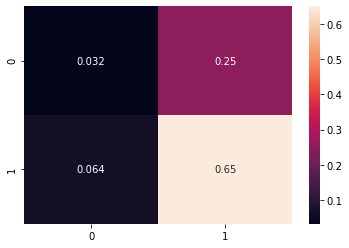

In [59]:
threshold = 0.6
y_pred = (prediction['prediction'] >= threshold).astype('int')
y_test = prediction[label]
print('threshold', threshold)
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

In [105]:
list_cols = [
    'Date', 'symbol',
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
    'label_next10_max', 'prediction'
]

prediction[list_cols].to_csv('./exported_data/usa_prediction_crossValidation_20211007.csv', index=False)

In [76]:
{'colsample_bytree': 0.23,
 'gamma': 0.44,
 'learning_rate': 0.03,
 'max_depth': 0,
 'min_child_weight': 6.0,
 'subsample': 0.73}

{'colsample_bytree': 0.23,
 'gamma': 0.44,
 'learning_rate': 0.03,
 'max_depth': 0,
 'min_child_weight': 6.0,
 'subsample': 0.73}

In [ ]:
params = {'objective':'binary:logistic',
#           'max_depth': 6, # default 6
          'alpha': 10,
#           'gamma' : 0, # default 0
#           'subsample' : 1, # default 1
#           'colsample_bytree' : 1, # default 1
#           'min_child_weight' : 1, # default 1
          'learning_rate': 0.1,
#           'alpha' : 0, # default 0
#           'eval_metric' : 'logloss',
          'n_estimators' : 1000,
          'verbosity' : 1,
          'seed' : 10
         }    

model = XGBClassifier(**params) 
model.fit(X_train, y_train,
          eval_metric="logloss",
          eval_set=[(X_train, y_train), (X_valid, y_valid)], 
          early_stopping_rounds=100,
          verbose=20)

In [ ]:
{'colsample_bytree': 0.23,
 'gamma': 0.44,
 'learning_rate': 0.03,
 'max_depth': 0,
 'min_child_weight': 6.0,
 'subsample': 0.73}

In [43]:
def objective(space):
    print("Training with params: ")
    print(space)
    classifier = XGBClassifier(n_estimators = 1000,
                               max_depth = int(space['max_depth']),
                               learning_rate = space['learning_rate'],
                               gamma = space['gamma'],
                               min_child_weight = space['min_child_weight'],
                               subsample = space['subsample'],
                               colsample_bytree = space['colsample_bytree'],)
    
    classifier.fit(X_train, y_train, 
                   eval_metric="logloss", 
                   eval_set=[(X_train, y_train), (X_valid, y_valid)], 
                   early_stopping_rounds=50, verbose=100)

    threshold = 0.6
    y_pred = (classifier.predict_proba(X_test, ntree_limit=classifier.best_iteration + 1)[:, 1] >= threshold).astype('int')
    score = f1_score(y_test, y_pred)
    print("\tScore {0}\n\n".format(score))
    
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}

space = {
    'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.05, 0.01),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 0.5, 0.01)
}

best = fmin(fn=objective, 
            space=space,
            algo=tpe.suggest,  
            max_evals=200)

Training with params:                                                                                                  
{'colsample_bytree': 0.1, 'gamma': 0.31, 'learning_rate': 0.02, 'max_depth': 23, 'min_child_weight': 5.0, 'subsample': 0.6}
[0]	validation_0-logloss:0.68836	validation_1-logloss:0.68917                                                          
[100]	validation_0-logloss:0.48528	validation_1-logloss:0.56908                                                        
[200]	validation_0-logloss:0.40938	validation_1-logloss:0.56266                                                        
[236]	validation_0-logloss:0.38639	validation_1-logloss:0.56324                                                        
	Score 0.7982580514482479                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.44, 'gamma'

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68956	validation_1-logloss:0.68878                                                          
[100]	validation_0-logloss:0.59475	validation_1-logloss:0.56700                                                        
[200]	validation_0-logloss:0.58507	validation_1-logloss:0.56446                                                        
[212]	validation_0-logloss:0.58385	validation_1-logloss:0.56563                                                        
	Score 0.8154557074034019                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.28, 'gamma': 0.48, 'learning_rate': 0.04, 'max_depth': 25, 'min_child_weight': 3.0, 'subsample': 0.67}
  1%|▍                                             | 2/200 [01:30<2:17:57, 41.81s/trial, best loss: 0.1845442925965981]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.67935	validation_1-logloss:0.68602                                                          
[100]	validation_0-logloss:0.25487	validation_1-logloss:0.57525                                                        
[114]	validation_0-logloss:0.23618	validation_1-logloss:0.57673                                                        
	Score 0.7715165021755279                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.35000000000000003, 'gamma': 0.25, 'learning_rate': 0.02, 'max_depth': 24, 'min_child_weight': 6.0, 'subsample': 0.61}
  2%|▋                                             | 3/200 [02:43<3:05:02, 56.36s/trial, best loss: 0.1845442925965981]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68706	validation_1-logloss:0.68981                                                          
[100]	validation_0-logloss:0.42899	validation_1-logloss:0.57604                                                        
[175]	validation_0-logloss:0.35153	validation_1-logloss:0.57509                                                        
	Score 0.7770794049863816                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.16, 'gamma': 0.46, 'learning_rate': 0.05, 'max_depth': 22, 'min_child_weight': 9.0, 'subsample': 0.9400000000000001}
  2%|▉                                             | 4/200 [04:35<4:14:42, 77.97s/trial, best loss: 0.1845442925965981]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.67868	validation_1-logloss:0.68379                                                          
[97]	validation_0-logloss:0.34001	validation_1-logloss:0.57203                                                         
	Score 0.7859663691094043                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.14, 'gamma': 0.49, 'learning_rate': 0.05, 'max_depth': 24, 'min_child_weight': 4.0, 'subsample': 0.31}
  2%|█▏                                            | 5/200 [05:13<3:27:08, 63.74s/trial, best loss: 0.1845442925965981]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68222	validation_1-logloss:0.68344                                                          
[100]	validation_0-logloss:0.40949	validation_1-logloss:0.57137                                                        
[122]	validation_0-logloss:0.38585	validation_1-logloss:0.57476                                                        
	Score 0.7751709626512362                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.14, 'gamma': 0.38, 'learning_rate': 0.04, 'max_depth': 12, 'min_child_weight': 2.0, 'subsample': 0.97}
  3%|█▍                                            | 6/200 [05:47<2:53:28, 53.65s/trial, best loss: 0.1845442925965981]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68446	validation_1-logloss:0.68443                                                          
[100]	validation_0-logloss:0.47953	validation_1-logloss:0.56834                                                        
[128]	validation_0-logloss:0.45423	validation_1-logloss:0.57083                                                        
	Score 0.8010588474852373                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.43, 'gamma': 0.04, 'learning_rate': 0.02, 'max_depth': 27, 'min_child_weight': 1.0, 'subsample': 0.2}
  4%|█▌                                            | 7/200 [06:19<2:29:22, 46.44s/trial, best loss: 0.1845442925965981]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68782	validation_1-logloss:0.69007                                                          
[100]	validation_0-logloss:0.45003	validation_1-logloss:0.57830                                                        
[200]	validation_0-logloss:0.35666	validation_1-logloss:0.57398                                                        
[228]	validation_0-logloss:0.33890	validation_1-logloss:0.57377                                                        
	Score 0.7839384167273484                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.39, 'gamma': 0.12, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 8.0, 'subsample': 0.15}
  4%|█▊                                            | 8/200 [08:32<3:56:57, 74.05s/trial, best loss: 0.1845442925965981]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68956	validation_1-logloss:0.68936                                                          
[100]	validation_0-logloss:0.59594	validation_1-logloss:0.56595                                                        
[200]	validation_0-logloss:0.58797	validation_1-logloss:0.56187                                                        
[300]	validation_0-logloss:0.58361	validation_1-logloss:0.56159                                                        
[319]	validation_0-logloss:0.58284	validation_1-logloss:0.56255                                                        
	Score 0.8130193905817175                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.42, 'gamma': 0.25, 'learning_rate': 0.03, 'max_depth': 26, 'min_child_weight': 7.0, 'subsample': 0.76}
  4%|██                         

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68349	validation_1-logloss:0.68821                                                          
[100]	validation_0-logloss:0.34214	validation_1-logloss:0.57520                                                        
[149]	validation_0-logloss:0.28481	validation_1-logloss:0.57953                                                        
	Score 0.7757205975173574                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.36, 'gamma': 0.23, 'learning_rate': 0.01, 'max_depth': 24, 'min_child_weight': 6.0, 'subsample': 0.8}
  5%|██▎                                          | 10/200 [10:42<3:50:44, 72.87s/trial, best loss: 0.1845442925965981]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68982	validation_1-logloss:0.69140                                                          
[100]	validation_0-logloss:0.49519	validation_1-logloss:0.59530                                                        
[200]	validation_0-logloss:0.39799	validation_1-logloss:0.57520                                                        
[300]	validation_0-logloss:0.33518	validation_1-logloss:0.57102                                                        
[373]	validation_0-logloss:0.30075	validation_1-logloss:0.57248                                                        
	Score 0.7859438167305898                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.35000000000000003, 'gamma': 0.09, 'learning_rate': 0.04, 'max_depth': 10, 'min_child_weight': 1.0, 'subsample': 0.23}
  6%|██▍         

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68469	validation_1-logloss:0.68566                                                          
[100]	validation_0-logloss:0.53626	validation_1-logloss:0.57256                                                        
[123]	validation_0-logloss:0.52780	validation_1-logloss:0.57296                                                        
	Score 0.795097037793667                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.12, 'gamma': 0.28, 'learning_rate': 0.02, 'max_depth': 16, 'min_child_weight': 1.0, 'subsample': 0.49}
  6%|██▋                                          | 12/200 [14:58<4:47:36, 91.79s/trial, best loss: 0.1845442925965981]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68845	validation_1-logloss:0.68893                                                          
[100]	validation_0-logloss:0.50690	validation_1-logloss:0.56956                                                        
[200]	validation_0-logloss:0.43447	validation_1-logloss:0.56408                                                        
[243]	validation_0-logloss:0.40907	validation_1-logloss:0.56491                                                        
	Score 0.7991483321504613                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.15, 'gamma': 0.43, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 3.0, 'subsample': 0.99}
  6%|██▉                                          | 13/200 [15:54<4:12:21, 80.97s/trial, best loss: 0.1845442925965981]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69131	validation_1-logloss:0.69087                                                          
[100]	validation_0-logloss:0.60890	validation_1-logloss:0.58688                                                        
[200]	validation_0-logloss:0.59025	validation_1-logloss:0.56598                                                        
[300]	validation_0-logloss:0.58148	validation_1-logloss:0.56172                                                        
[381]	validation_0-logloss:0.57586	validation_1-logloss:0.56173                                                        
	Score 0.8105054509415263                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.5, 'gamma': 0.4, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.19}
  7%|███▏                          

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69118	validation_1-logloss:0.69137                                                          
[100]	validation_0-logloss:0.60077	validation_1-logloss:0.58975                                                        
[200]	validation_0-logloss:0.57606	validation_1-logloss:0.57059                                                        
[300]	validation_0-logloss:0.56439	validation_1-logloss:0.56821                                                        
[332]	validation_0-logloss:0.56134	validation_1-logloss:0.56817                                                        
	Score 0.8060387922415517                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.21, 'gamma': 0.36, 'learning_rate': 0.05, 'max_depth': 21, 'min_child_weight': 4.0, 'subsample': 0.16}
  8%|███▍                       

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68305	validation_1-logloss:0.68472                                                          
[100]	validation_0-logloss:0.47597	validation_1-logloss:0.57432                                                        
[110]	validation_0-logloss:0.46824	validation_1-logloss:0.57503                                                        
	Score 0.7724108837797934                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.12, 'gamma': 0.07, 'learning_rate': 0.02, 'max_depth': 7, 'min_child_weight': 8.0, 'subsample': 0.71}
  8%|███▌                                         | 16/200 [18:13<2:52:02, 56.10s/trial, best loss: 0.1845442925965981]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68951	validation_1-logloss:0.68861                                                          
[100]	validation_0-logloss:0.59297	validation_1-logloss:0.56510                                                        
[200]	validation_0-logloss:0.58057	validation_1-logloss:0.55890                                                        
[256]	validation_0-logloss:0.57533	validation_1-logloss:0.55948                                                        
	Score 0.8119379385314756                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.38, 'gamma': 0.4, 'learning_rate': 0.04, 'max_depth': 20, 'min_child_weight': 6.0, 'subsample': 0.36}
  8%|███▊                                         | 17/200 [18:41<2:25:16, 47.63s/trial, best loss: 0.1845442925965981]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68325	validation_1-logloss:0.68610                                                          
[100]	validation_0-logloss:0.41923	validation_1-logloss:0.57630                                                        
[116]	validation_0-logloss:0.40605	validation_1-logloss:0.57825                                                        
	Score 0.7795076793604039                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.11, 'gamma': 0.45, 'learning_rate': 0.01, 'max_depth': 20, 'min_child_weight': 2.0, 'subsample': 0.13}
  9%|████                                         | 18/200 [19:37<2:31:50, 50.06s/trial, best loss: 0.1845442925965981]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69124	validation_1-logloss:0.69108                                                          
[100]	validation_0-logloss:0.58957	validation_1-logloss:0.59208                                                        
[200]	validation_0-logloss:0.55232	validation_1-logloss:0.56888                                                        
[300]	validation_0-logloss:0.52793	validation_1-logloss:0.56254                                                        
[400]	validation_0-logloss:0.50696	validation_1-logloss:0.56113                                                        
[447]	validation_0-logloss:0.49732	validation_1-logloss:0.56152                                                        
	Score 0.8011289184558008                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.32, 'gamma': 0.

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68655	validation_1-logloss:0.68722                                                          
[100]	validation_0-logloss:0.53044	validation_1-logloss:0.56930                                                        
[144]	validation_0-logloss:0.51060	validation_1-logloss:0.57322                                                        
	Score 0.8016129032258064                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.49, 'gamma': 0.17, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 0.45}
 10%|████▌                                        | 20/200 [21:40<2:42:35, 54.20s/trial, best loss: 0.1845442925965981]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68780	validation_1-logloss:0.68679                                                          
[100]	validation_0-logloss:0.58874	validation_1-logloss:0.56358                                                        
[164]	validation_0-logloss:0.58247	validation_1-logloss:0.56578                                                        
	Score 0.8168073826821127                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.49, 'gamma': 0.19, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4.0, 'subsample': 0.47000000000000003}
 10%|████▌                                       | 21/200 [22:02<2:12:29, 44.41s/trial, best loss: 0.18319261731788727]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68780	validation_1-logloss:0.68687                                                          
[100]	validation_0-logloss:0.58842	validation_1-logloss:0.56415                                                        
[164]	validation_0-logloss:0.58182	validation_1-logloss:0.56625                                                        
	Score 0.8128764688456601                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.47000000000000003, 'gamma': 0.16, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 0.4}
 11%|████▊                                       | 22/200 [22:25<1:52:59, 38.09s/trial, best loss: 0.18319261731788727]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68778	validation_1-logloss:0.68663                                                          
[100]	validation_0-logloss:0.58894	validation_1-logloss:0.56311                                                        
[174]	validation_0-logloss:0.58231	validation_1-logloss:0.56481                                                        
	Score 0.8109768179116307                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.46, 'gamma': 0.32, 'learning_rate': 0.03, 'max_depth': 19, 'min_child_weight': 10.0, 'subsample': 0.52}
 12%|█████                                       | 23/200 [22:46<1:37:18, 32.99s/trial, best loss: 0.18319261731788727]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68526	validation_1-logloss:0.68822                                                          
[100]	validation_0-logloss:0.44504	validation_1-logloss:0.57534                                                        
[144]	validation_0-logloss:0.41118	validation_1-logloss:0.58068                                                        
	Score 0.7847178846554236                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.24, 'gamma': 0.19, 'learning_rate': 0.02, 'max_depth': 18, 'min_child_weight': 5.0, 'subsample': 0.28}
 12%|█████▎                                      | 24/200 [24:02<2:13:59, 45.68s/trial, best loss: 0.18319261731788727]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68836	validation_1-logloss:0.68968                                                          
[100]	validation_0-logloss:0.52259	validation_1-logloss:0.56999                                                        
[200]	validation_0-logloss:0.46586	validation_1-logloss:0.56581                                                        
[228]	validation_0-logloss:0.45415	validation_1-logloss:0.56672                                                        
	Score 0.7928981937602627                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.43, 'gamma': 0.14, 'learning_rate': 0.03, 'max_depth': 29, 'min_child_weight': 2.0, 'subsample': 0.43}
 12%|█████▌                                      | 25/200 [25:02<2:26:24, 50.20s/trial, best loss: 0.18319261731788727]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68319	validation_1-logloss:0.68899                                                          
[100]	validation_0-logloss:0.31113	validation_1-logloss:0.57703                                                        
[153]	validation_0-logloss:0.24755	validation_1-logloss:0.58203                                                        
	Score 0.7751004016064257                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.46, 'gamma': 0.19, 'learning_rate': 0.04, 'max_depth': 28, 'min_child_weight': 7.0, 'subsample': 0.87}
 13%|█████▋                                      | 26/200 [26:58<3:22:12, 69.72s/trial, best loss: 0.18319261731788727]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.67967	validation_1-logloss:0.68683                                                          
[100]	validation_0-logloss:0.27009	validation_1-logloss:0.58598                                                        
[107]	validation_0-logloss:0.25940	validation_1-logloss:0.58701                                                        
	Score 0.7678800856531048                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.5, 'gamma': 0.34, 'learning_rate': 0.02, 'max_depth': 15, 'min_child_weight': 9.0, 'subsample': 0.58}
 14%|█████▉                                      | 27/200 [28:26<3:37:21, 75.39s/trial, best loss: 0.18319261731788727]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68785	validation_1-logloss:0.68975                                                          
[100]	validation_0-logloss:0.49764	validation_1-logloss:0.57626                                                        
[192]	validation_0-logloss:0.44167	validation_1-logloss:0.57871                                                        
	Score 0.7901794924695688                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.31, 'gamma': 0.02, 'learning_rate': 0.01, 'max_depth': 13, 'min_child_weight': 5.0, 'subsample': 0.63}
 14%|██████▏                                     | 28/200 [29:56<3:48:28, 79.70s/trial, best loss: 0.18319261731788727]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69054	validation_1-logloss:0.69120                                                          
[100]	validation_0-logloss:0.56835	validation_1-logloss:0.59180                                                        
[200]	validation_0-logloss:0.51786	validation_1-logloss:0.57228                                                        
[300]	validation_0-logloss:0.48408	validation_1-logloss:0.56888                                                        
[380]	validation_0-logloss:0.46210	validation_1-logloss:0.57048                                                        
	Score 0.7902878803401291                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.4, 'gamma': 0.3, 'learning_rate': 0.02, 'max_depth': 14, 'min_child_weight': 3.0, 'subsample': 0.55}
 14%|██████▍                      

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68758	validation_1-logloss:0.68997                                                          
[100]	validation_0-logloss:0.48971	validation_1-logloss:0.57916                                                        
[174]	validation_0-logloss:0.43736	validation_1-logloss:0.57762                                                        
	Score 0.7853142501555693                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.26, 'gamma': 0.22, 'learning_rate': 0.03, 'max_depth': 8, 'min_child_weight': 7.0, 'subsample': 0.35000000000000003}
 15%|██████▌                                     | 30/200 [33:01<3:57:44, 83.91s/trial, best loss: 0.18319261731788727]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68728	validation_1-logloss:0.68724                                                          
[100]	validation_0-logloss:0.57074	validation_1-logloss:0.56495                                                        
[173]	validation_0-logloss:0.55728	validation_1-logloss:0.56790                                                        
	Score 0.8081632653061225                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.48, 'gamma': 0.11, 'learning_rate': 0.03, 'max_depth': 17, 'min_child_weight': 8.0, 'subsample': 0.67}
 16%|██████▊                                     | 31/200 [33:24<3:05:11, 65.75s/trial, best loss: 0.18319261731788727]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68463	validation_1-logloss:0.68772                                                          
[100]	validation_0-logloss:0.42147	validation_1-logloss:0.57976                                                        
[141]	validation_0-logloss:0.38852	validation_1-logloss:0.58552                                                        
	Score 0.7810379033100138                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.44, 'gamma': 0.15, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 4.0, 'subsample': 0.44}
 16%|███████                                     | 32/200 [34:38<3:10:28, 68.03s/trial, best loss: 0.18319261731788727]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68944	validation_1-logloss:0.68909                                                          
[100]	validation_0-logloss:0.59005	validation_1-logloss:0.56850                                                        
[200]	validation_0-logloss:0.57788	validation_1-logloss:0.56558                                                        
[208]	validation_0-logloss:0.57692	validation_1-logloss:0.56661                                                        
	Score 0.8107305484062562                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.34, 'gamma': 0.31, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5.0, 'subsample': 0.26}
 16%|███████▎                                    | 33/200 [35:07<2:37:06, 56.45s/trial, best loss: 0.18319261731788727]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69137	validation_1-logloss:0.69092                                                          
[100]	validation_0-logloss:0.61149	validation_1-logloss:0.58693                                                        
[200]	validation_0-logloss:0.59625	validation_1-logloss:0.56616                                                        
[300]	validation_0-logloss:0.59075	validation_1-logloss:0.56152                                                        
[394]	validation_0-logloss:0.58747	validation_1-logloss:0.56103                                                        
	Score 0.8158205430932705                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.2, 'gamma': 0.32, 'learning_rate': 0.04, 'max_depth': 25, 'min_child_weight': 5.0, 'subsample': 0.27}
 17%|███████▍                    

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68378	validation_1-logloss:0.68616                                                          
[100]	validation_0-logloss:0.44534	validation_1-logloss:0.56946                                                        
[135]	validation_0-logloss:0.41314	validation_1-logloss:0.57325                                                        
	Score 0.7856695216210571                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.27, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 11, 'min_child_weight': 5.0, 'subsample': 0.33}
 18%|███████▋                                    | 35/200 [36:23<2:09:34, 47.12s/trial, best loss: 0.18319261731788727]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68248	validation_1-logloss:0.68423                                                          
[100]	validation_0-logloss:0.51542	validation_1-logloss:0.57145                                                        
[116]	validation_0-logloss:0.50768	validation_1-logloss:0.57295                                                        
	Score 0.793521442395844                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.33, 'gamma': 0.21, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 7.0, 'subsample': 0.11}
 18%|███████▉                                    | 36/200 [36:43<1:47:18, 39.26s/trial, best loss: 0.18319261731788727]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69142	validation_1-logloss:0.69098                                                          
[100]	validation_0-logloss:0.61206	validation_1-logloss:0.58618                                                        
[200]	validation_0-logloss:0.59723	validation_1-logloss:0.56542                                                        
[300]	validation_0-logloss:0.59257	validation_1-logloss:0.55957                                                        
[384]	validation_0-logloss:0.58998	validation_1-logloss:0.55902                                                        
	Score 0.8202926829268293                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.29, 'gamma': 0.08, 'learning_rate': 0.05, 'max_depth': 23, 'min_child_weight': 10.0, 'subsample': 0.11}
 18%|████████▏                 

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68402	validation_1-logloss:0.68371                                                          
[100]	validation_0-logloss:0.53284	validation_1-logloss:0.56706                                                        
[116]	validation_0-logloss:0.52549	validation_1-logloss:0.56875                                                        
	Score 0.7944867311252829                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.18, 'gamma': 0.21, 'learning_rate': 0.04, 'max_depth': 12, 'min_child_weight': 9.0, 'subsample': 0.8}
 19%|████████▎                                   | 38/200 [37:41<1:32:02, 34.09s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68383	validation_1-logloss:0.68569                                                          
[100]	validation_0-logloss:0.50229	validation_1-logloss:0.56477                                                        
[145]	validation_0-logloss:0.47146	validation_1-logloss:0.57098                                                        
	Score 0.7951537365098759                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.24, 'gamma': 0.17, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 8.0, 'subsample': 0.91}
 20%|████████▌                                   | 39/200 [38:11<1:28:31, 32.99s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69132	validation_1-logloss:0.69095                                                          
[100]	validation_0-logloss:0.61207	validation_1-logloss:0.58634                                                        
[200]	validation_0-logloss:0.59659	validation_1-logloss:0.56533                                                        
[300]	validation_0-logloss:0.59112	validation_1-logloss:0.56091                                                        
[382]	validation_0-logloss:0.58779	validation_1-logloss:0.56112                                                        
	Score 0.8162623981145046                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.41000000000000003, 'gamma': 0.12, 'learning_rate': 0.05, 'max_depth': 27, 'min_child_weight': 7.0, 'subsample': 0.39}
 20%|████████▊   

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68081	validation_1-logloss:0.68489                                                          
[100]	validation_0-logloss:0.37214	validation_1-logloss:0.58344                                                        
	Score 0.7688869972334539                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.34, 'gamma': 0.05, 'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 9.0, 'subsample': 0.1}
 20%|█████████                                   | 41/200 [39:48<1:50:06, 41.55s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68607	validation_1-logloss:0.68447                                                          
[100]	validation_0-logloss:0.59013	validation_1-logloss:0.56019                                                        
[174]	validation_0-logloss:0.58470	validation_1-logloss:0.56233                                                        
	Score 0.8189130861290956                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.32, 'gamma': 0.04, 'learning_rate': 0.04, 'max_depth': 16, 'min_child_weight': 9.0, 'subsample': 0.22}
 21%|█████████▏                                  | 42/200 [40:01<1:26:34, 32.88s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68462	validation_1-logloss:0.68579                                                          
[100]	validation_0-logloss:0.51018	validation_1-logloss:0.56850                                                        
[139]	validation_0-logloss:0.49239	validation_1-logloss:0.57169                                                        
	Score 0.7950668036998971                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.37, 'gamma': 0.06, 'learning_rate': 0.05, 'max_depth': 22, 'min_child_weight': 8.0, 'subsample': 0.11}
 22%|█████████▍                                  | 43/200 [40:33<1:25:03, 32.50s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68388	validation_1-logloss:0.68371                                                          
[98]	validation_0-logloss:0.52343	validation_1-logloss:0.57144                                                         
	Score 0.7970032840722495                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.34, 'gamma': 0.0, 'learning_rate': 0.04, 'max_depth': 15, 'min_child_weight': 7.0, 'subsample': 0.15}
 22%|█████████▋                                  | 44/200 [40:58<1:19:08, 30.44s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68544	validation_1-logloss:0.68606                                                          
[100]	validation_0-logloss:0.52824	validation_1-logloss:0.56971                                                        
[117]	validation_0-logloss:0.52184	validation_1-logloss:0.57067                                                        
	Score 0.793413786050317                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.29, 'gamma': 0.1, 'learning_rate': 0.04, 'max_depth': 26, 'min_child_weight': 9.0, 'subsample': 0.2}
 22%|█████████▉                                  | 45/200 [41:22<1:13:08, 28.31s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68480	validation_1-logloss:0.68571                                                          
[100]	validation_0-logloss:0.49698	validation_1-logloss:0.56789                                                        
[114]	validation_0-logloss:0.48683	validation_1-logloss:0.56907                                                        
	Score 0.7936802973977695                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.25, 'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': 11, 'min_child_weight': 8.0, 'subsample': 0.1}
 23%|██████████                                  | 46/200 [42:01<1:20:53, 31.52s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68418	validation_1-logloss:0.68420                                                          
[100]	validation_0-logloss:0.56200	validation_1-logloss:0.56309                                                        
[119]	validation_0-logloss:0.55721	validation_1-logloss:0.56612                                                        
	Score 0.8062638024493074                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.22, 'gamma': 0.05, 'learning_rate': 0.04, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.24}
 24%|██████████▎                                 | 47/200 [42:16<1:07:54, 26.63s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68526	validation_1-logloss:0.68574                                                          
[100]	validation_0-logloss:0.56256	validation_1-logloss:0.56219                                                        
[137]	validation_0-logloss:0.55280	validation_1-logloss:0.56430                                                        
	Score 0.8063549160671464                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.39, 'gamma': 0.14, 'learning_rate': 0.04, 'max_depth': 21, 'min_child_weight': 6.0, 'subsample': 0.3}
 24%|███████████                                   | 48/200 [42:31<58:45, 23.19s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68345	validation_1-logloss:0.68633                                                          
[100]	validation_0-logloss:0.43644	validation_1-logloss:0.57707                                                        
[117]	validation_0-logloss:0.42218	validation_1-logloss:0.57880                                                        
	Score 0.7860353297794502                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.36, 'gamma': 0.26, 'learning_rate': 0.05, 'max_depth': 24, 'min_child_weight': 8.0, 'subsample': 0.17}
 24%|██████████▊                                 | 49/200 [43:15<1:14:09, 29.46s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68293	validation_1-logloss:0.68451                                                          
[100]	validation_0-logloss:0.48631	validation_1-logloss:0.57120                                                        
[109]	validation_0-logloss:0.48064	validation_1-logloss:0.57159                                                        
	Score 0.7915282392026578                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.31, 'gamma': 0.03, 'learning_rate': 0.04, 'max_depth': 28, 'min_child_weight': 7.0, 'subsample': 0.31}
 25%|███████████                                 | 50/200 [43:51<1:18:13, 31.29s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68367	validation_1-logloss:0.68599                                                          
[100]	validation_0-logloss:0.43494	validation_1-logloss:0.57014                                                        
[116]	validation_0-logloss:0.42054	validation_1-logloss:0.57181                                                        
	Score 0.7859538784067087                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.33, 'gamma': 0.47000000000000003, 'learning_rate': 0.05, 'max_depth': 18, 'min_child_weight': 10.0, 'subsample': 0.73}
 26%|███████████▏                                | 51/200 [44:39<1:30:33, 36.46s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.67946	validation_1-logloss:0.68379                                                          
[97]	validation_0-logloss:0.37487	validation_1-logloss:0.58073                                                         
	Score 0.7834793491864831                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.29, 'gamma': 0.37, 'learning_rate': 0.03, 'max_depth': 19, 'min_child_weight': 9.0, 'subsample': 0.19}
 26%|███████████▍                                | 52/200 [45:22<1:34:29, 38.31s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68691	validation_1-logloss:0.68753                                                          
[100]	validation_0-logloss:0.52716	validation_1-logloss:0.56645                                                        
[153]	validation_0-logloss:0.50420	validation_1-logloss:0.56892                                                        
	Score 0.7973178908869246                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.38, 'gamma': 0.42, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 7.0, 'subsample': 0.39}
 26%|███████████▋                                | 53/200 [46:01<1:34:10, 38.44s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68955	validation_1-logloss:0.68859                                                          
[100]	validation_0-logloss:0.59506	validation_1-logloss:0.56676                                                        
[200]	validation_0-logloss:0.58577	validation_1-logloss:0.56376                                                        
[211]	validation_0-logloss:0.58473	validation_1-logloss:0.56429                                                        
	Score 0.8159811060814801                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.18, 'gamma': 0.34, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 6.0, 'subsample': 0.14}
 27%|███████████▉                                | 54/200 [46:20<1:19:46, 32.79s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69124	validation_1-logloss:0.69119                                                          
[100]	validation_0-logloss:0.60888	validation_1-logloss:0.58607                                                        
[200]	validation_0-logloss:0.59036	validation_1-logloss:0.56516                                                        
[300]	validation_0-logloss:0.58287	validation_1-logloss:0.55999                                                        
[400]	validation_0-logloss:0.57747	validation_1-logloss:0.55893                                                        
[500]	validation_0-logloss:0.57242	validation_1-logloss:0.55918                                                        
	Score 0.8097696584590944                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.410000000000000

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68095	validation_1-logloss:0.68746                                                          
[100]	validation_0-logloss:0.30235	validation_1-logloss:0.58112                                                        
[114]	validation_0-logloss:0.28304	validation_1-logloss:0.58365                                                        
	Score 0.7725963077579767                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.36, 'gamma': 0.12, 'learning_rate': 0.03, 'max_depth': 17, 'min_child_weight': 9.0, 'subsample': 0.24}
 28%|████████████▎                               | 56/200 [48:12<1:50:47, 46.16s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68664	validation_1-logloss:0.68777                                                          
[100]	validation_0-logloss:0.51560	validation_1-logloss:0.56840                                                        
[158]	validation_0-logloss:0.48923	validation_1-logloss:0.57073                                                        
	Score 0.797544757033248                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.27, 'gamma': 0.28, 'learning_rate': 0.05, 'max_depth': 13, 'min_child_weight': 10.0, 'subsample': 0.85}
 28%|████████████▌                               | 57/200 [48:56<1:48:04, 45.35s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68065	validation_1-logloss:0.68362                                                          
[100]	validation_0-logloss:0.44343	validation_1-logloss:0.57495                                                        
[115]	validation_0-logloss:0.43072	validation_1-logloss:0.57830                                                        
	Score 0.7932903753707681                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.22, 'gamma': 0.08, 'learning_rate': 0.03, 'max_depth': 14, 'min_child_weight': 8.0, 'subsample': 0.54}
 29%|████████████▊                               | 58/200 [49:30<1:39:46, 42.16s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68583	validation_1-logloss:0.68721                                                          
[100]	validation_0-logloss:0.50149	validation_1-logloss:0.56619                                                        
[145]	validation_0-logloss:0.47169	validation_1-logloss:0.56968                                                        
	Score 0.7963340122199594                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.34, 'gamma': 0.2, 'learning_rate': 0.02, 'max_depth': 10, 'min_child_weight': 7.0, 'subsample': 0.37}
 30%|████████████▉                               | 59/200 [50:03<1:32:16, 39.26s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68894	validation_1-logloss:0.68927                                                          
[100]	validation_0-logloss:0.56448	validation_1-logloss:0.57061                                                        
[193]	validation_0-logloss:0.53763	validation_1-logloss:0.56958                                                        
	Score 0.8042232277526394                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.44, 'gamma': 0.02, 'learning_rate': 0.04, 'max_depth': 6, 'min_child_weight': 3.0, 'subsample': 0.65}
 30%|█████████████▏                              | 60/200 [50:39<1:29:09, 38.21s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68583	validation_1-logloss:0.68545                                                          
[100]	validation_0-logloss:0.57600	validation_1-logloss:0.56820                                                        
[124]	validation_0-logloss:0.57177	validation_1-logloss:0.56984                                                        
	Score 0.8099632827230326                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.31, 'gamma': 0.49, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 8.0, 'subsample': 0.42}
 30%|█████████████▍                              | 61/200 [50:58<1:15:15, 32.49s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69127	validation_1-logloss:0.69105                                                          
[100]	validation_0-logloss:0.60676	validation_1-logloss:0.58769                                                        
[200]	validation_0-logloss:0.58745	validation_1-logloss:0.56734                                                        
[300]	validation_0-logloss:0.57840	validation_1-logloss:0.56337                                                        
[373]	validation_0-logloss:0.57306	validation_1-logloss:0.56352                                                        
	Score 0.8094010313367711                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.38, 'gamma': 0.23, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 6.0, 'subsample': 0.6}
 31%|█████████████▋              

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68725	validation_1-logloss:0.68988                                                          
[100]	validation_0-logloss:0.44281	validation_1-logloss:0.57615                                                        
[175]	validation_0-logloss:0.37276	validation_1-logloss:0.57477                                                        
	Score 0.780906521511567                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.27, 'gamma': 0.4, 'learning_rate': 0.03, 'max_depth': 23, 'min_child_weight': 9.0, 'subsample': 0.12}
 32%|█████████████▊                              | 63/200 [53:11<1:57:49, 51.60s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68741	validation_1-logloss:0.68728                                                          
[100]	validation_0-logloss:0.54688	validation_1-logloss:0.56530                                                        
[139]	validation_0-logloss:0.53117	validation_1-logloss:0.56665                                                        
	Score 0.7996741012323048                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.42, 'gamma': 0.35000000000000003, 'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 4.0, 'subsample': 0.18}
 32%|██████████████                              | 64/200 [53:45<1:45:12, 46.42s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68600	validation_1-logloss:0.68556                                                          
[100]	validation_0-logloss:0.58702	validation_1-logloss:0.56225                                                        
[133]	validation_0-logloss:0.58384	validation_1-logloss:0.56251                                                        
	Score 0.8111210052438904                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.45, 'gamma': 0.18, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 0.45}
 32%|██████████████▎                             | 65/200 [53:56<1:20:25, 35.75s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68780	validation_1-logloss:0.68679                                                          
[100]	validation_0-logloss:0.58867	validation_1-logloss:0.56298                                                        
[165]	validation_0-logloss:0.58235	validation_1-logloss:0.56431                                                        
	Score 0.8173332023189546                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.46, 'gamma': 0.17, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 0.48}
 33%|██████████████▌                             | 66/200 [54:15<1:08:43, 30.77s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68957	validation_1-logloss:0.68885                                                          
[100]	validation_0-logloss:0.59457	validation_1-logloss:0.56762                                                        
[200]	validation_0-logloss:0.58525	validation_1-logloss:0.56454                                                        
[235]	validation_0-logloss:0.58271	validation_1-logloss:0.56670                                                        
	Score 0.8166994106090373                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.35000000000000003, 'gamma': 0.27, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 9.0, 'subsample': 0.7000000000000001}
 34%|██████████████▋                             | 67/200 [54:43<1:06:23, 29.95s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68778	validation_1-logloss:0.68667                                                          
[100]	validation_0-logloss:0.58895	validation_1-logloss:0.56398                                                        
[174]	validation_0-logloss:0.58128	validation_1-logloss:0.56589                                                        
	Score 0.8151640149283049                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.4, 'gamma': 0.24, 'learning_rate': 0.01, 'max_depth': 12, 'min_child_weight': 10.0, 'subsample': 0.29}
 34%|██████████████▉                             | 68/200 [55:05<1:00:17, 27.41s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69096	validation_1-logloss:0.69125                                                          
[100]	validation_0-logloss:0.58924	validation_1-logloss:0.59001                                                        
[200]	validation_0-logloss:0.55619	validation_1-logloss:0.57042                                                        
[300]	validation_0-logloss:0.53656	validation_1-logloss:0.56779                                                        
[347]	validation_0-logloss:0.52948	validation_1-logloss:0.56838                                                        
	Score 0.8008080808080809                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.45, 'gamma': 0.14, 'learning_rate': 0.05, 'max_depth': 25, 'min_child_weight': 10.0, 'subsample': 0.33}
 34%|███████████████▏          

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68151	validation_1-logloss:0.68506                                                          
[99]	validation_0-logloss:0.42828	validation_1-logloss:0.58269                                                         
	Score 0.7779766291188546                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.48, 'gamma': 0.18, 'learning_rate': 0.02, 'max_depth': 22, 'min_child_weight': 8.0, 'subsample': 0.9500000000000001}
 35%|███████████████▍                            | 70/200 [57:08<1:34:16, 43.51s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68637	validation_1-logloss:0.68976                                                          
[100]	validation_0-logloss:0.39409	validation_1-logloss:0.58223                                                        
[174]	validation_0-logloss:0.31156	validation_1-logloss:0.58269                                                        
	Score 0.775726713346064                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.33, 'gamma': 0.21, 'learning_rate': 0.03, 'max_depth': 27, 'min_child_weight': 7.0, 'subsample': 0.79}
 36%|███████████████▌                            | 71/200 [59:12<2:25:55, 67.87s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68369	validation_1-logloss:0.68757                                                          
[100]	validation_0-logloss:0.34274	validation_1-logloss:0.57312                                                        
[133]	validation_0-logloss:0.30090	validation_1-logloss:0.57542                                                        
	Score 0.7775081759679291                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.43, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 9.0, 'subsample': 0.22}
 36%|███████████████                           | 72/200 [1:00:36<2:34:54, 72.61s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69137	validation_1-logloss:0.69109                                                          
[100]	validation_0-logloss:0.61146	validation_1-logloss:0.58639                                                        
[200]	validation_0-logloss:0.59594	validation_1-logloss:0.56628                                                        
[300]	validation_0-logloss:0.59025	validation_1-logloss:0.56248                                                        
[393]	validation_0-logloss:0.58699	validation_1-logloss:0.56273                                                        
	Score 0.818769592476489                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.3, 'gamma': 0.08, 'learning_rate': 0.01, 'max_depth': 26, 'min_child_weight': 9.0, 'subsample': 0.21}
 36%|███████████████▎            

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69098	validation_1-logloss:0.69133                                                          
[100]	validation_0-logloss:0.58295	validation_1-logloss:0.58943                                                        
[200]	validation_0-logloss:0.54136	validation_1-logloss:0.56812                                                        
[300]	validation_0-logloss:0.51391	validation_1-logloss:0.56420                                                        
[393]	validation_0-logloss:0.49254	validation_1-logloss:0.56454                                                        
	Score 0.7965051305496292                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.37, 'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 16, 'min_child_weight': 7.0, 'subsample': 0.16}
 37%|███████████████▌           

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69115	validation_1-logloss:0.69130                                                          
[100]	validation_0-logloss:0.58905	validation_1-logloss:0.59054                                                        
[200]	validation_0-logloss:0.55366	validation_1-logloss:0.57021                                                        
[300]	validation_0-logloss:0.53311	validation_1-logloss:0.56542                                                        
[371]	validation_0-logloss:0.52107	validation_1-logloss:0.56614                                                        
	Score 0.7982144668763315                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.43, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 8.0, 'subsample': 0.13}
 38%|███████████████▊             

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69136	validation_1-logloss:0.69119                                                          
[100]	validation_0-logloss:0.61171	validation_1-logloss:0.58599                                                        
[200]	validation_0-logloss:0.59643	validation_1-logloss:0.56539                                                        
[300]	validation_0-logloss:0.59156	validation_1-logloss:0.56020                                                        
[391]	validation_0-logloss:0.58842	validation_1-logloss:0.56021                                                        
	Score 0.8200019533157534                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.4, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 21, 'min_child_weight': 8.0, 'subsample': 0.26}
 38%|███████████████▉            

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69093	validation_1-logloss:0.69138                                                          
[100]	validation_0-logloss:0.57185	validation_1-logloss:0.59169                                                        
[200]	validation_0-logloss:0.52204	validation_1-logloss:0.57174                                                        
[300]	validation_0-logloss:0.48982	validation_1-logloss:0.56870                                                        
[342]	validation_0-logloss:0.47909	validation_1-logloss:0.56916                                                        
	Score 0.7875219502117551                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.42, 'gamma': 0.13, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_weight': 6.0, 'subsample': 0.14}
 38%|████████████████▏          

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69119	validation_1-logloss:0.69147                                                          
[100]	validation_0-logloss:0.59059	validation_1-logloss:0.59110                                                        
[200]	validation_0-logloss:0.55685	validation_1-logloss:0.57070                                                        
[300]	validation_0-logloss:0.53773	validation_1-logloss:0.56573                                                        
[361]	validation_0-logloss:0.52789	validation_1-logloss:0.56612                                                        
	Score 0.8013733212157931                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.32, 'gamma': 0.06, 'learning_rate': 0.01, 'max_depth': 19, 'min_child_weight': 8.0, 'subsample': 0.33}
 39%|████████████████▍          

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69078	validation_1-logloss:0.69133                                                          
[100]	validation_0-logloss:0.56900	validation_1-logloss:0.59140                                                        
[200]	validation_0-logloss:0.51815	validation_1-logloss:0.57095                                                        
[300]	validation_0-logloss:0.48509	validation_1-logloss:0.56785                                                        
[323]	validation_0-logloss:0.47892	validation_1-logloss:0.56801                                                        
	Score 0.7924180327868852                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.37, 'gamma': 0.1, 'learning_rate': 0.02, 'max_depth': 9, 'min_child_weight': 7.0, 'subsample': 0.11}
 40%|████████████████▌            

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68949	validation_1-logloss:0.68919                                                          
[100]	validation_0-logloss:0.58402	validation_1-logloss:0.56664                                                        
[200]	validation_0-logloss:0.56894	validation_1-logloss:0.56307                                                        
[278]	validation_0-logloss:0.56116	validation_1-logloss:0.56353                                                        
	Score 0.8104340900039825                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.25, 'gamma': 0.15, 'learning_rate': 0.01, 'max_depth': 28, 'min_child_weight': 5.0, 'subsample': 0.25}
 40%|████████████████▊                         | 80/200 [1:10:43<2:22:45, 71.38s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69078	validation_1-logloss:0.69147                                                          
[100]	validation_0-logloss:0.56655	validation_1-logloss:0.59208                                                        
[200]	validation_0-logloss:0.50930	validation_1-logloss:0.57007                                                        
[300]	validation_0-logloss:0.47019	validation_1-logloss:0.56478                                                        
[380]	validation_0-logloss:0.44395	validation_1-logloss:0.56543                                                        
	Score 0.7952643396611554                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.28, 'gamma': 0.03, 'learning_rate': 0.02, 'max_depth': 18, 'min_child_weight': 6.0, 'subsample': 0.1}
 40%|█████████████████           

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68942	validation_1-logloss:0.68949                                                          
[100]	validation_0-logloss:0.56572	validation_1-logloss:0.56901                                                        
[200]	validation_0-logloss:0.53629	validation_1-logloss:0.56472                                                        
[218]	validation_0-logloss:0.53173	validation_1-logloss:0.56503                                                        
	Score 0.8047480132783422                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.35000000000000003, 'gamma': 0.07, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 8.0, 'subsample': 0.18}
 41%|█████████████████▏                        | 82/200 [1:13:43<2:31:17, 76.92s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69135	validation_1-logloss:0.69102                                                          
[100]	validation_0-logloss:0.61176	validation_1-logloss:0.58641                                                        
[200]	validation_0-logloss:0.59657	validation_1-logloss:0.56562                                                        
[300]	validation_0-logloss:0.59152	validation_1-logloss:0.56047                                                        
[393]	validation_0-logloss:0.58838	validation_1-logloss:0.56043                                                        
	Score 0.8187787905517985                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.39, 'gamma': 0.16, 'learning_rate': 0.02, 'max_depth': 11, 'min_child_weight': 7.0, 'subsample': 0.13}
 42%|█████████████████▍         

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68933	validation_1-logloss:0.68921                                                          
[100]	validation_0-logloss:0.57455	validation_1-logloss:0.56743                                                        
[191]	validation_0-logloss:0.55447	validation_1-logloss:0.56487                                                        
	Score 0.8126743722598644                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.49, 'gamma': 0.12, 'learning_rate': 0.04, 'max_depth': 24, 'min_child_weight': 8.0, 'subsample': 0.28}
 42%|█████████████████▋                        | 84/200 [1:14:39<1:40:09, 51.80s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68438	validation_1-logloss:0.68656                                                          
[100]	validation_0-logloss:0.44716	validation_1-logloss:0.57997                                                        
[116]	validation_0-logloss:0.43482	validation_1-logloss:0.58207                                                        
	Score 0.786027111574557                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.3, 'gamma': 0.29, 'learning_rate': 0.01, 'max_depth': 29, 'min_child_weight': 9.0, 'subsample': 0.21}
 42%|█████████████████▊                        | 85/200 [1:15:33<1:40:30, 52.44s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69098	validation_1-logloss:0.69133                                                          
[100]	validation_0-logloss:0.58275	validation_1-logloss:0.58936                                                        
[200]	validation_0-logloss:0.54071	validation_1-logloss:0.56849                                                        
[300]	validation_0-logloss:0.51245	validation_1-logloss:0.56414                                                        
[380]	validation_0-logloss:0.49312	validation_1-logloss:0.56403                                                        
	Score 0.7964187608098485                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.23, 'gamma': 0.09, 'learning_rate': 0.02, 'max_depth': 13, 'min_child_weight': 6.0, 'subsample': 0.36}
 43%|██████████████████         

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68855	validation_1-logloss:0.68960                                                          
[100]	validation_0-logloss:0.54724	validation_1-logloss:0.56914                                                        
[200]	validation_0-logloss:0.50492	validation_1-logloss:0.56625                                                        
[204]	validation_0-logloss:0.50411	validation_1-logloss:0.56619                                                        
	Score 0.7961893179284484                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.33, 'gamma': 0.2, 'learning_rate': 0.04, 'max_depth': 8, 'min_child_weight': 7.0, 'subsample': 0.16}
 44%|██████████████████▎                       | 87/200 [1:18:26<2:03:40, 65.67s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68584	validation_1-logloss:0.68485                                                          
[100]	validation_0-logloss:0.57003	validation_1-logloss:0.56401                                                        
[132]	validation_0-logloss:0.56487	validation_1-logloss:0.56470                                                        
	Score 0.8075117370892019                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.41000000000000003, 'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 9.0, 'subsample': 0.23}
 44%|██████████████████▍                       | 88/200 [1:18:42<1:34:23, 50.57s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68325	validation_1-logloss:0.68389                                                          
[100]	validation_0-logloss:0.54332	validation_1-logloss:0.57138                                                        
[115]	validation_0-logloss:0.53818	validation_1-logloss:0.57261                                                        
	Score 0.8022633121147822                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.47000000000000003, 'gamma': 0.04, 'learning_rate': 0.01, 'max_depth': 14, 'min_child_weight': 5.0, 'subsample': 0.41000000000000003}
 44%|██████████████████▋                       | 89/200 [1:19:01<1:16:11, 41.18s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69077	validation_1-logloss:0.69135                                                          
[100]	validation_0-logloss:0.56410	validation_1-logloss:0.59455                                                        
[200]	validation_0-logloss:0.51218	validation_1-logloss:0.57601                                                        
[300]	validation_0-logloss:0.48033	validation_1-logloss:0.57412                                                        
[324]	validation_0-logloss:0.47414	validation_1-logloss:0.57461                                                        
	Score 0.7942740286298569                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.43, 'gamma': 0.11, 'learning_rate': 0.05, 'max_depth': 17, 'min_child_weight': 8.0, 'subsample': 0.58}
 45%|██████████████████▉        

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.67957	validation_1-logloss:0.68533                                                          
[97]	validation_0-logloss:0.39191	validation_1-logloss:0.58584                                                         
	Score 0.7763116225060699                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.35000000000000003, 'gamma': 0.31, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 7.0, 'subsample': 0.31}
 46%|███████████████████                       | 91/200 [1:21:36<1:42:29, 56.42s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68946	validation_1-logloss:0.68886                                                          
[100]	validation_0-logloss:0.59140	validation_1-logloss:0.56691                                                        
[200]	validation_0-logloss:0.58043	validation_1-logloss:0.56295                                                        
[253]	validation_0-logloss:0.57621	validation_1-logloss:0.56386                                                        
	Score 0.8103550882761358                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.18, 'gamma': 0.15, 'learning_rate': 0.04, 'max_depth': 7, 'min_child_weight': 10.0, 'subsample': 0.34}
 46%|███████████████████▎                      | 92/200 [1:22:02<1:25:31, 47.52s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68567	validation_1-logloss:0.68494                                                          
[100]	validation_0-logloss:0.57849	validation_1-logloss:0.56031                                                        
[141]	validation_0-logloss:0.57119	validation_1-logloss:0.56248                                                        
	Score 0.8133240804996531                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.39, 'gamma': 0.22, 'learning_rate': 0.01, 'max_depth': 20, 'min_child_weight': 3.0, 'subsample': 0.13}
 46%|███████████████████▌                      | 93/200 [1:22:15<1:05:59, 37.00s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69107	validation_1-logloss:0.69128                                                          
[100]	validation_0-logloss:0.57954	validation_1-logloss:0.59429                                                        
[200]	validation_0-logloss:0.53454	validation_1-logloss:0.57246                                                        
[300]	validation_0-logloss:0.50548	validation_1-logloss:0.56659                                                        
[371]	validation_0-logloss:0.48858	validation_1-logloss:0.56701                                                        
	Score 0.7945879458794588                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.16, 'gamma': 0.26, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 1.0, 'subsample': 0.38}
 47%|███████████████████▋        

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68786	validation_1-logloss:0.68637                                                          
[100]	validation_0-logloss:0.59346	validation_1-logloss:0.56008                                                        
[175]	validation_0-logloss:0.58673	validation_1-logloss:0.56071                                                        
	Score 0.810126582278481                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.28, 'gamma': 0.06, 'learning_rate': 0.02, 'max_depth': 12, 'min_child_weight': 8.0, 'subsample': 0.86}
 48%|███████████████████▉                      | 95/200 [1:24:12<1:16:48, 43.89s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68823	validation_1-logloss:0.68927                                                          
[100]	validation_0-logloss:0.52933	validation_1-logloss:0.57234                                                        
[192]	validation_0-logloss:0.48068	validation_1-logloss:0.57234                                                        
	Score 0.7903555373927257                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.38, 'gamma': 0.13, 'learning_rate': 0.01, 'max_depth': 23, 'min_child_weight': 9.0, 'subsample': 0.18}
 48%|████████████████████▏                     | 96/200 [1:25:09<1:22:48, 47.78s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69108	validation_1-logloss:0.69146                                                          
[100]	validation_0-logloss:0.58522	validation_1-logloss:0.58973                                                        
[200]	validation_0-logloss:0.54583	validation_1-logloss:0.56951                                                        
[300]	validation_0-logloss:0.52061	validation_1-logloss:0.56567                                                        
[370]	validation_0-logloss:0.50566	validation_1-logloss:0.56628                                                        
	Score 0.7983355323251801                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.36, 'gamma': 0.07, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4.0, 'subsample': 0.27}
 48%|████████████████████▎       

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68437	validation_1-logloss:0.68209                                                          
[100]	validation_0-logloss:0.58362	validation_1-logloss:0.56332                                                        
[115]	validation_0-logloss:0.58191	validation_1-logloss:0.56350                                                        
	Score 0.8191447626520204                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.36, 'gamma': 0.07, 'learning_rate': 0.01, 'max_depth': 22, 'min_child_weight': 2.0, 'subsample': 0.45}
 49%|████████████████████▌                     | 98/200 [1:27:20<1:27:59, 51.76s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68985	validation_1-logloss:0.69149                                                          
[100]	validation_0-logloss:0.50219	validation_1-logloss:0.59856                                                        
[200]	validation_0-logloss:0.40777	validation_1-logloss:0.57727                                                        
[300]	validation_0-logloss:0.34506	validation_1-logloss:0.57214                                                        
[381]	validation_0-logloss:0.30684	validation_1-logloss:0.57291                                                        
	Score 0.7863937138130688                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.47000000000000003, 'gamma': 0.16, 'learning_rate': 0.02, 'max_depth': 16, 'min_child_weight': 4.0, 'subsample': 0.53}
 50%|████████████

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68736	validation_1-logloss:0.68995                                                          
[100]	validation_0-logloss:0.46603	validation_1-logloss:0.57960                                                        
[153]	validation_0-logloss:0.42114	validation_1-logloss:0.58092                                                        
	Score 0.7814458838278311                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.45, 'gamma': 0.19, 'learning_rate': 0.01, 'max_depth': 25, 'min_child_weight': 2.0, 'subsample': 0.51}
 50%|████████████████████▌                    | 100/200 [1:31:29<2:19:58, 83.99s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68952	validation_1-logloss:0.69161                                                          
[100]	validation_0-logloss:0.47484	validation_1-logloss:0.60145                                                        
[200]	validation_0-logloss:0.36489	validation_1-logloss:0.57967                                                        
[300]	validation_0-logloss:0.29445	validation_1-logloss:0.57608                                                        
[325]	validation_0-logloss:0.28195	validation_1-logloss:0.57617                                                        
	Score 0.7791013584117032                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.4, 'gamma': 0.09, 'learning_rate': 0.01, 'max_depth': 27, 'min_child_weight': 3.0, 'subsample': 0.47000000000000003}
 50%|█████████████

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68990	validation_1-logloss:0.69153                                                          
[100]	validation_0-logloss:0.50029	validation_1-logloss:0.59847                                                        
[200]	validation_0-logloss:0.40171	validation_1-logloss:0.57776                                                        
[300]	validation_0-logloss:0.33655	validation_1-logloss:0.57393                                                        
[369]	validation_0-logloss:0.30361	validation_1-logloss:0.57430                                                        
	Score 0.7828981587433684                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.26, 'gamma': 0.33, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 5.0, 'subsample': 0.27}
 51%|████████████████████▍       

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68958	validation_1-logloss:0.68864                                                          
[100]	validation_0-logloss:0.59625	validation_1-logloss:0.56605                                                        
[200]	validation_0-logloss:0.58809	validation_1-logloss:0.56054                                                        
[238]	validation_0-logloss:0.58595	validation_1-logloss:0.56044                                                        
	Score 0.8149532710280375                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.44, 'gamma': 0.03, 'learning_rate': 0.01, 'max_depth': 26, 'min_child_weight': 3.0, 'subsample': 0.56}
 52%|████████████████████▌                   | 103/200 [1:40:18<3:24:52, 126.73s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68966	validation_1-logloss:0.69150                                                          
[100]	validation_0-logloss:0.48348	validation_1-logloss:0.59955                                                        
[200]	validation_0-logloss:0.37701	validation_1-logloss:0.57887                                                        
[300]	validation_0-logloss:0.30772	validation_1-logloss:0.57560                                                        
[337]	validation_0-logloss:0.28932	validation_1-logloss:0.57605                                                        
	Score 0.7817480987602875                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.5, 'gamma': 0.11, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 4.0, 'subsample': 0.31}
 52%|████████████████████▊        

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68324	validation_1-logloss:0.68434                                                          
[100]	validation_0-logloss:0.53815	validation_1-logloss:0.57445                                                        
[112]	validation_0-logloss:0.53444	validation_1-logloss:0.57592                                                        
	Score 0.8021756647864625                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.32, 'gamma': 0.25, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 2.0, 'subsample': 0.25}
 52%|█████████████████████                   | 105/200 [1:45:20<3:22:20, 127.79s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68957	validation_1-logloss:0.68875                                                          
[100]	validation_0-logloss:0.59594	validation_1-logloss:0.56689                                                        
[200]	validation_0-logloss:0.58742	validation_1-logloss:0.56234                                                        
[218]	validation_0-logloss:0.58644	validation_1-logloss:0.56259                                                        
	Score 0.8178343949044586                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.31, 'gamma': 0.24, 'learning_rate': 0.03, 'max_depth': 21, 'min_child_weight': 5.0, 'subsample': 0.29}
 53%|█████████████████████▋                   | 106/200 [1:45:40<2:29:36, 95.49s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68576	validation_1-logloss:0.68812                                                          
[100]	validation_0-logloss:0.46342	validation_1-logloss:0.57194                                                        
[139]	validation_0-logloss:0.43377	validation_1-logloss:0.57513                                                        
	Score 0.7834428109686163                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.42, 'gamma': 0.43, 'learning_rate': 0.02, 'max_depth': 15, 'min_child_weight': 4.0, 'subsample': 0.2}
 54%|█████████████████████▉                   | 107/200 [1:46:35<2:09:18, 83.42s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68874	validation_1-logloss:0.68971                                                          
[100]	validation_0-logloss:0.53508	validation_1-logloss:0.57375                                                        
[200]	validation_0-logloss:0.49235	validation_1-logloss:0.57189                                                        
[228]	validation_0-logloss:0.48465	validation_1-logloss:0.57248                                                        
	Score 0.7909558067831449                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.2, 'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 11, 'min_child_weight': 6.0, 'subsample': 0.64}
 54%|██████████████████████▏                  | 108/200 [1:47:46<2:02:10, 79.68s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69088	validation_1-logloss:0.69135                                                          
[100]	validation_0-logloss:0.59112	validation_1-logloss:0.58805                                                        
[200]	validation_0-logloss:0.55701	validation_1-logloss:0.56777                                                        
[300]	validation_0-logloss:0.53510	validation_1-logloss:0.56381                                                        
[380]	validation_0-logloss:0.51990	validation_1-logloss:0.56433                                                        
	Score 0.7993543831332595                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.37, 'gamma': 0.13, 'learning_rate': 0.02, 'max_depth': 24, 'min_child_weight': 5.0, 'subsample': 0.15}
 55%|██████████████████████▎    

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68912	validation_1-logloss:0.68974                                                          
[100]	validation_0-logloss:0.53638	validation_1-logloss:0.57196                                                        
[192]	validation_0-logloss:0.49016	validation_1-logloss:0.56881                                                        
	Score 0.7913195515787308                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.33, 'gamma': 0.21, 'learning_rate': 0.01, 'max_depth': 18, 'min_child_weight': 6.0, 'subsample': 0.76}
 55%|██████████████████████▌                  | 110/200 [1:50:06<1:51:53, 74.59s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69007	validation_1-logloss:0.69138                                                          
[100]	validation_0-logloss:0.52335	validation_1-logloss:0.59380                                                        
[200]	validation_0-logloss:0.44334	validation_1-logloss:0.57454                                                        
[300]	validation_0-logloss:0.39082	validation_1-logloss:0.57129                                                        
[374]	validation_0-logloss:0.35987	validation_1-logloss:0.57275                                                        
	Score 0.7831600831600832                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.29, 'gamma': 0.29, 'learning_rate': 0.05, 'max_depth': 19, 'min_child_weight': 3.0, 'subsample': 0.43}
 56%|██████████████████████▏    

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.67906	validation_1-logloss:0.68463                                                          
[100]	validation_0-logloss:0.34545	validation_1-logloss:0.57907                                                        
[110]	validation_0-logloss:0.33367	validation_1-logloss:0.58168                                                        
	Score 0.7737427210164108                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.34, 'gamma': 0.37, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 4.0, 'subsample': 0.12}
 56%|██████████████████████▉                  | 112/200 [1:54:03<2:12:29, 90.33s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69139	validation_1-logloss:0.69114                                                          
[100]	validation_0-logloss:0.61194	validation_1-logloss:0.58653                                                        
[200]	validation_0-logloss:0.59700	validation_1-logloss:0.56559                                                        
[300]	validation_0-logloss:0.59228	validation_1-logloss:0.56007                                                        
[400]	validation_0-logloss:0.58921	validation_1-logloss:0.55895                                                        
[447]	validation_0-logloss:0.58805	validation_1-logloss:0.55929                                                        
	Score 0.8163225172074731                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.48, 'gamma': 0.

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.67919	validation_1-logloss:0.68891                                                          
[100]	validation_0-logloss:0.19161	validation_1-logloss:0.58392                                                        
[154]	validation_0-logloss:0.12952	validation_1-logloss:0.58999                                                        
	Score 0.7736842105263158                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.41000000000000003, 'gamma': 0.27, 'learning_rate': 0.01, 'max_depth': 28, 'min_child_weight': 5.0, 'subsample': 0.23}
 57%|███████████████████████▎                 | 114/200 [1:57:01<2:15:54, 94.81s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69083	validation_1-logloss:0.69141                                                          
[100]	validation_0-logloss:0.56357	validation_1-logloss:0.59385                                                        
[200]	validation_0-logloss:0.50489	validation_1-logloss:0.57353                                                        
[300]	validation_0-logloss:0.46422	validation_1-logloss:0.56975                                                        
[338]	validation_0-logloss:0.45147	validation_1-logloss:0.57045                                                        
	Score 0.7933647347941839                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.36, 'gamma': 0.16, 'learning_rate': 0.02, 'max_depth': 13, 'min_child_weight': 6.0, 'subsample': 0.4}
 57%|███████████████████████     

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68839	validation_1-logloss:0.68937                                                          
[100]	validation_0-logloss:0.53267	validation_1-logloss:0.57129                                                        
[192]	validation_0-logloss:0.49008	validation_1-logloss:0.57042                                                        
	Score 0.7964169381107492                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.46, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 7.0, 'subsample': 0.17}
 58%|███████████████████████▊                 | 116/200 [2:00:17<2:09:03, 92.19s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68393	validation_1-logloss:0.68465                                                          
[100]	validation_0-logloss:0.56296	validation_1-logloss:0.56824                                                        
[117]	validation_0-logloss:0.55859	validation_1-logloss:0.57128                                                        
	Score 0.8018535307746549                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.44, 'gamma': 0.09, 'learning_rate': 0.03, 'max_depth': 14, 'min_child_weight': 2.0, 'subsample': 0.89}
 58%|███████████████████████▉                 | 117/200 [2:00:33<1:35:48, 69.26s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68390	validation_1-logloss:0.68822                                                          
[100]	validation_0-logloss:0.40055	validation_1-logloss:0.58006                                                        
[140]	validation_0-logloss:0.35806	validation_1-logloss:0.58616                                                        
	Score 0.7722772277227723                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.14, 'gamma': 0.24, 'learning_rate': 0.04, 'max_depth': 10, 'min_child_weight': 4.0, 'subsample': 0.35000000000000003}
 59%|████████████████████████▏                | 118/200 [2:01:37<1:32:24, 67.62s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68562	validation_1-logloss:0.68480                                                          
[100]	validation_0-logloss:0.55241	validation_1-logloss:0.56454                                                        
[129]	validation_0-logloss:0.54090	validation_1-logloss:0.56738                                                        
	Score 0.8058776489404238                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.3, 'gamma': 0.3, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 3.0, 'subsample': 0.2}
 60%|████████████████████████▍                | 119/200 [2:01:52<1:10:05, 51.93s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69125	validation_1-logloss:0.69110                                                          
[100]	validation_0-logloss:0.60800	validation_1-logloss:0.58767                                                        
[200]	validation_0-logloss:0.58970	validation_1-logloss:0.56641                                                        
[300]	validation_0-logloss:0.58159	validation_1-logloss:0.56256                                                        
[380]	validation_0-logloss:0.57676	validation_1-logloss:0.56285                                                        
	Score 0.8097125867195242                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.26, 'gamma': 0.02, 'learning_rate': 0.02, 'max_depth': 17, 'min_child_weight': 6.0, 'subsample': 0.14}
 60%|████████████████████████▌  

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68914	validation_1-logloss:0.68980                                                          
[100]	validation_0-logloss:0.55647	validation_1-logloss:0.56948                                                        
[200]	validation_0-logloss:0.52374	validation_1-logloss:0.56423                                                        
[237]	validation_0-logloss:0.51445	validation_1-logloss:0.56426                                                        
	Score 0.799552527204312                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.24, 'gamma': 0.22, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5.0, 'subsample': 0.61}
 60%|████████████████████████▊                | 121/200 [2:03:22<1:04:24, 48.91s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69125	validation_1-logloss:0.69105                                                          
[100]	validation_0-logloss:0.61005	validation_1-logloss:0.58648                                                        
[200]	validation_0-logloss:0.59265	validation_1-logloss:0.56592                                                        
[300]	validation_0-logloss:0.58562	validation_1-logloss:0.56152                                                        
[390]	validation_0-logloss:0.58074	validation_1-logloss:0.56147                                                        
	Score 0.8145519077196096                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.39, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 7.0, 'subsample': 0.32}
 61%|█████████████████████████   

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69131	validation_1-logloss:0.69089                                                          
[100]	validation_0-logloss:0.61136	validation_1-logloss:0.58693                                                        
[200]	validation_0-logloss:0.59569	validation_1-logloss:0.56641                                                        
[300]	validation_0-logloss:0.59004	validation_1-logloss:0.56211                                                        
[379]	validation_0-logloss:0.58670	validation_1-logloss:0.56247                                                        
	Score 0.8168516154374938                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.35000000000000003, 'gamma': 0.14, 'learning_rate': 0.03, 'max_depth': 20, 'min_child_weight': 7.0, 'subsample': 0.1}
 62%|█████████████

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68756	validation_1-logloss:0.68698                                                          
[100]	validation_0-logloss:0.54743	validation_1-logloss:0.56687                                                        
[152]	validation_0-logloss:0.52804	validation_1-logloss:0.56903                                                        
	Score 0.7978442139515964                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.43, 'gamma': 0.04, 'learning_rate': 0.05, 'max_depth': 23, 'min_child_weight': 6.0, 'subsample': 0.27}
 62%|██████████████████████████▋                | 124/200 [2:05:13<51:43, 40.84s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68190	validation_1-logloss:0.68514                                                          
[100]	validation_0-logloss:0.41911	validation_1-logloss:0.57793                                                        
[116]	validation_0-logloss:0.40347	validation_1-logloss:0.58179                                                        
	Score 0.778187177597642                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.37, 'gamma': 0.11, 'learning_rate': 0.02, 'max_depth': 12, 'min_child_weight': 4.0, 'subsample': 0.47000000000000003}
 62%|██████████████████████████▉                | 125/200 [2:06:03<54:33, 43.64s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68843	validation_1-logloss:0.68937                                                          
[100]	validation_0-logloss:0.53287	validation_1-logloss:0.57376                                                        
[174]	validation_0-logloss:0.49592	validation_1-logloss:0.57359                                                        
	Score 0.795399022801303                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.38, 'gamma': 0.08, 'learning_rate': 0.04, 'max_depth': 25, 'min_child_weight': 5.0, 'subsample': 0.37}
 63%|███████████████████████████                | 126/200 [2:06:51<55:17, 44.83s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68261	validation_1-logloss:0.68598                                                          
[100]	validation_0-logloss:0.38111	validation_1-logloss:0.57996                                                        
[117]	validation_0-logloss:0.36421	validation_1-logloss:0.58208                                                        
	Score 0.7805238698774819                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.28, 'gamma': 0.17, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 8.0, 'subsample': 0.8300000000000001}
 64%|███████████████████████████▎               | 127/200 [2:07:46<58:03, 47.72s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69134	validation_1-logloss:0.69101                                                          
[100]	validation_0-logloss:0.61161	validation_1-logloss:0.58677                                                        
[200]	validation_0-logloss:0.59600	validation_1-logloss:0.56590                                                        
[300]	validation_0-logloss:0.59037	validation_1-logloss:0.56141                                                        
[397]	validation_0-logloss:0.58642	validation_1-logloss:0.56143                                                        
	Score 0.8153755406999607                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.32, 'gamma': 0.0, 'learning_rate': 0.04, 'max_depth': 22, 'min_child_weight': 3.0, 'subsample': 0.22}
 64%|███████████████████████████▌

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68375	validation_1-logloss:0.68633                                                          
[100]	validation_0-logloss:0.43045	validation_1-logloss:0.57660                                                        
[114]	validation_0-logloss:0.41752	validation_1-logloss:0.57897                                                        
	Score 0.7752069624283592                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.4, 'gamma': 0.06, 'learning_rate': 0.03, 'max_depth': 16, 'min_child_weight': 7.0, 'subsample': 0.29}
 64%|███████████████████████████▋               | 129/200 [2:09:08<52:17, 44.19s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68619	validation_1-logloss:0.68796                                                          
[100]	validation_0-logloss:0.49659	validation_1-logloss:0.57274                                                        
[143]	validation_0-logloss:0.47247	validation_1-logloss:0.57503                                                        
	Score 0.7896093186269457                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.49, 'gamma': 0.1, 'learning_rate': 0.02, 'max_depth': 27, 'min_child_weight': 8.0, 'subsample': 0.17}
 65%|███████████████████████████▉               | 130/200 [2:09:48<50:12, 43.03s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68913	validation_1-logloss:0.68984                                                          
[100]	validation_0-logloss:0.54040	validation_1-logloss:0.57303                                                        
[200]	validation_0-logloss:0.49061	validation_1-logloss:0.57154                                                        
[202]	validation_0-logloss:0.48997	validation_1-logloss:0.57154                                                        
	Score 0.7907312049433574                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.42, 'gamma': 0.15, 'learning_rate': 0.01, 'max_depth': 26, 'min_child_weight': 2.0, 'subsample': 0.12}
 66%|██████████████████████████▊              | 131/200 [2:11:10<1:02:44, 54.56s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69102	validation_1-logloss:0.69156                                                          
[100]	validation_0-logloss:0.57245	validation_1-logloss:0.59771                                                        
[200]	validation_0-logloss:0.51915	validation_1-logloss:0.57577                                                        
[300]	validation_0-logloss:0.48267	validation_1-logloss:0.56969                                                        
[378]	validation_0-logloss:0.46010	validation_1-logloss:0.56973                                                        
	Score 0.7951782613137194                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.41000000000000003, 'gamma': 0.39, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5.0, 'subsample': 0.25}
 66%|█████████████

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68437	validation_1-logloss:0.68344                                                          
[100]	validation_0-logloss:0.58326	validation_1-logloss:0.56368                                                        
[117]	validation_0-logloss:0.58133	validation_1-logloss:0.56389                                                        
	Score 0.8182175107970161                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.1, 'gamma': 0.12, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_weight': 6.0, 'subsample': 0.19}
 66%|███████████████████████████▎             | 133/200 [2:13:42<1:06:26, 59.50s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69124	validation_1-logloss:0.69107                                                          
[100]	validation_0-logloss:0.60024	validation_1-logloss:0.58879                                                        
[200]	validation_0-logloss:0.57343	validation_1-logloss:0.56543                                                        
[300]	validation_0-logloss:0.55819	validation_1-logloss:0.55980                                                        
[400]	validation_0-logloss:0.54509	validation_1-logloss:0.55901                                                        
[440]	validation_0-logloss:0.53982	validation_1-logloss:0.55912                                                        
	Score 0.8072372999304106                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.25, 'gamma': 0.

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68947	validation_1-logloss:0.68903                                                          
[100]	validation_0-logloss:0.58669	validation_1-logloss:0.56554                                                        
[200]	validation_0-logloss:0.57193	validation_1-logloss:0.56111                                                        
[238]	validation_0-logloss:0.56755	validation_1-logloss:0.56127                                                        
	Score 0.8117985897308571                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.34, 'gamma': 0.07, 'learning_rate': 0.04, 'max_depth': 21, 'min_child_weight': 8.0, 'subsample': 0.35000000000000003}
 68%|█████████████████████████████              | 135/200 [2:15:04<53:03, 48.97s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68355	validation_1-logloss:0.68591                                                          
[100]	validation_0-logloss:0.44286	validation_1-logloss:0.57455                                                        
[110]	validation_0-logloss:0.43518	validation_1-logloss:0.57528                                                        
	Score 0.787161109379869                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.31, 'gamma': 0.32, 'learning_rate': 0.03, 'max_depth': 19, 'min_child_weight': 10.0, 'subsample': 0.15}
 68%|█████████████████████████████▏             | 136/200 [2:15:48<50:42, 47.53s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68729	validation_1-logloss:0.68788                                                          
[100]	validation_0-logloss:0.54251	validation_1-logloss:0.56417                                                        
[143]	validation_0-logloss:0.52652	validation_1-logloss:0.56574                                                        
	Score 0.795814709467696                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.45, 'gamma': 0.18, 'learning_rate': 0.01, 'max_depth': 28, 'min_child_weight': 7.0, 'subsample': 0.71}
 68%|█████████████████████████████▍             | 137/200 [2:16:23<45:58, 43.78s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69002	validation_1-logloss:0.69140                                                          
[100]	validation_0-logloss:0.50329	validation_1-logloss:0.59689                                                        
[200]	validation_0-logloss:0.40811	validation_1-logloss:0.57788                                                        
[300]	validation_0-logloss:0.34439	validation_1-logloss:0.57710                                                        
[320]	validation_0-logloss:0.33488	validation_1-logloss:0.57740                                                        
	Score 0.7821100917431193                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.27, 'gamma': 0.13, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 9.0, 'subsample': 0.49}
 69%|███████████████████████████▌

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68955	validation_1-logloss:0.68886                                                          
[100]	validation_0-logloss:0.59578	validation_1-logloss:0.56651                                                        
[200]	validation_0-logloss:0.58704	validation_1-logloss:0.56196                                                        
[211]	validation_0-logloss:0.58641	validation_1-logloss:0.56188                                                        
	Score 0.8169152276295134                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.36, 'gamma': 0.21, 'learning_rate': 0.01, 'max_depth': 24, 'min_child_weight': 6.0, 'subsample': 0.56}
 70%|████████████████████████████▍            | 139/200 [2:20:42<1:18:57, 77.67s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69019	validation_1-logloss:0.69134                                                          
[100]	validation_0-logloss:0.52348	validation_1-logloss:0.59475                                                        
[200]	validation_0-logloss:0.44154	validation_1-logloss:0.57410                                                        
[300]	validation_0-logloss:0.38547	validation_1-logloss:0.57034                                                        
[372]	validation_0-logloss:0.35458	validation_1-logloss:0.57141                                                        
	Score 0.7873022438217351                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.33, 'gamma': 0.35000000000000003, 'learning_rate': 0.01, 'max_depth': 18, 'min_child_weight': 7.0, 'subsample': 0.41000000000000003}
 7

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.69071	validation_1-logloss:0.69128                                                          
[100]	validation_0-logloss:0.55873	validation_1-logloss:0.59180                                                        
[200]	validation_0-logloss:0.50122	validation_1-logloss:0.57206                                                        
[300]	validation_0-logloss:0.46335	validation_1-logloss:0.56915                                                        
[336]	validation_0-logloss:0.45232	validation_1-logloss:0.56921                                                        
	Score 0.789960913392306                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.22, 'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 11, 'min_child_weight': 8.0, 'subsample': 0.23}
 70%|███████████████████████████

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68281	validation_1-logloss:0.68354                                                          
[100]	validation_0-logloss:0.54194	validation_1-logloss:0.56407                                                        
[110]	validation_0-logloss:0.53746	validation_1-logloss:0.56515                                                        
	Score 0.8026275896917635                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.43, 'gamma': 0.23, 'learning_rate': 0.02, 'max_depth': 29, 'min_child_weight': 1.0, 'subsample': 0.58}
 71%|█████████████████████████████            | 142/200 [2:26:35<1:25:56, 88.91s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68443	validation_1-logloss:0.69064                                                          
[100]	validation_0-logloss:0.29415	validation_1-logloss:0.58100                                                        
[192]	validation_0-logloss:0.18028	validation_1-logloss:0.57952                                                        
	Score 0.781517875810161                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.39, 'gamma': 0.08, 'learning_rate': 0.04, 'max_depth': 13, 'min_child_weight': 5.0, 'subsample': 0.93}
 72%|████████████████████████████▌           | 143/200 [2:29:12<1:43:45, 109.21s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68205	validation_1-logloss:0.68556                                                          
[100]	validation_0-logloss:0.42034	validation_1-logloss:0.58347                                                        
[114]	validation_0-logloss:0.40809	validation_1-logloss:0.58661                                                        
	Score 0.7849127182044887                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.2, 'gamma': 0.46, 'learning_rate': 0.03, 'max_depth': 8, 'min_child_weight': 3.0, 'subsample': 0.39}
 72%|█████████████████████████████▌           | 144/200 [2:29:54<1:23:06, 89.05s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68743	validation_1-logloss:0.68670                                                          
[100]	validation_0-logloss:0.57422	validation_1-logloss:0.56174                                                        
[153]	validation_0-logloss:0.56197	validation_1-logloss:0.56337                                                        
	Score 0.8092680986475735                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.3, 'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 9.0, 'subsample': 0.1}
 72%|█████████████████████████████▋           | 145/200 [2:30:09<1:01:09, 66.71s/trial, best loss: 0.17970731707317067]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68432	validation_1-logloss:0.68246                                                          
[100]	validation_0-logloss:0.58834	validation_1-logloss:0.55878                                                        
[131]	validation_0-logloss:0.58610	validation_1-logloss:0.55932                                                        
	Score 0.8210485209411303                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.29, 'gamma': 0.03, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 0.13}
 73%|███████████████████████████████▍           | 146/200 [2:30:16<44:08, 49.05s/trial, best loss: 0.17895147905886966]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68445	validation_1-logloss:0.68265                                                          
[100]	validation_0-logloss:0.58764	validation_1-logloss:0.55876                                                        
[131]	validation_0-logloss:0.58544	validation_1-logloss:0.55836                                                        
	Score 0.819142689371697                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.23, 'gamma': 0.04, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 9.0, 'subsample': 0.16}
 74%|███████████████████████████████▌           | 147/200 [2:30:24<32:27, 36.75s/trial, best loss: 0.17895147905886966]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68447	validation_1-logloss:0.68227                                                          
[100]	validation_0-logloss:0.58828	validation_1-logloss:0.55858                                                        
[143]	validation_0-logloss:0.58454	validation_1-logloss:0.56025                                                        
	Score 0.814544017389586                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.28, 'gamma': 0.07, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 9.0, 'subsample': 0.1}
 74%|███████████████████████████████▊           | 148/200 [2:30:32<24:20, 28.08s/trial, best loss: 0.17895147905886966]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68433	validation_1-logloss:0.68241                                                          
[100]	validation_0-logloss:0.58815	validation_1-logloss:0.55978                                                        
[133]	validation_0-logloss:0.58582	validation_1-logloss:0.56014                                                        
	Score 0.8204177239898498                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.19, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 9.0, 'subsample': 0.11}
 74%|████████████████████████████████           | 149/200 [2:30:40<18:41, 22.00s/trial, best loss: 0.17895147905886966]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68445	validation_1-logloss:0.68197                                                          
[100]	validation_0-logloss:0.59008	validation_1-logloss:0.55729                                                        
[138]	validation_0-logloss:0.58705	validation_1-logloss:0.55826                                                        
	Score 0.8197009674582234                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.21, 'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 10.0, 'subsample': 1.0}
 75%|████████████████████████████████▎          | 150/200 [2:30:47<14:30, 17.41s/trial, best loss: 0.17895147905886966]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68252	validation_1-logloss:0.68353                                                          
[97]	validation_0-logloss:0.51214	validation_1-logloss:0.57488                                                         
	Score 0.8021723825807099                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.24, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 14, 'min_child_weight': 10.0, 'subsample': 0.21}
 76%|████████████████████████████████▍          | 151/200 [2:31:04<14:13, 17.42s/trial, best loss: 0.17895147905886966]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68295	validation_1-logloss:0.68375                                                          
[100]	validation_0-logloss:0.52406	validation_1-logloss:0.56624                                                        
[112]	validation_0-logloss:0.51845	validation_1-logloss:0.56795                                                        
	Score 0.7963265306122449                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.23, 'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 17, 'min_child_weight': 9.0, 'subsample': 0.18}
 76%|████████████████████████████████▋          | 152/200 [2:31:20<13:35, 16.98s/trial, best loss: 0.17895147905886966]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68280	validation_1-logloss:0.68436                                                          
[100]	validation_0-logloss:0.51446	validation_1-logloss:0.56851                                                        
[109]	validation_0-logloss:0.50904	validation_1-logloss:0.56942                                                        
	Score 0.7917444513586394                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.26, 'gamma': 0.19, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 8.0, 'subsample': 0.1}
 76%|████████████████████████████████▉          | 153/200 [2:31:38<13:30, 17.25s/trial, best loss: 0.17895147905886966]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68425	validation_1-logloss:0.68234                                                          
[100]	validation_0-logloss:0.58394	validation_1-logloss:0.56017                                                        
[132]	validation_0-logloss:0.58079	validation_1-logloss:0.56163                                                        
	Score 0.8171641791044776                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.17, 'gamma': 0.06, 'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 9.0, 'subsample': 0.14}
 77%|█████████████████████████████████          | 154/200 [2:31:45<10:54, 14.24s/trial, best loss: 0.17895147905886966]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68605	validation_1-logloss:0.68488                                                          
[100]	validation_0-logloss:0.59223	validation_1-logloss:0.55731                                                        
[143]	validation_0-logloss:0.58860	validation_1-logloss:0.55859                                                        
	Score 0.8216933281310964                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.18, 'gamma': 0.06, 'learning_rate': 0.04, 'max_depth': 20, 'min_child_weight': 10.0, 'subsample': 0.15}
 78%|██████████████████████████████████          | 155/200 [2:31:52<09:02, 12.06s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68538	validation_1-logloss:0.68588                                                          
[100]	validation_0-logloss:0.53824	validation_1-logloss:0.56383                                                        
[141]	validation_0-logloss:0.52010	validation_1-logloss:0.56691                                                        
	Score 0.8015929745736751                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.12, 'gamma': 0.14, 'learning_rate': 0.04, 'max_depth': 23, 'min_child_weight': 10.0, 'subsample': 0.25}
 78%|██████████████████████████████████▎         | 156/200 [2:32:14<10:54, 14.87s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68558	validation_1-logloss:0.68471                                                          
[100]	validation_0-logloss:0.51948	validation_1-logloss:0.56159                                                        
[144]	validation_0-logloss:0.49316	validation_1-logloss:0.56527                                                        
	Score 0.7961184882533198                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.16, 'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 9.0, 'subsample': 0.19}
 78%|██████████████████████████████████▌         | 157/200 [2:32:39<12:48, 17.87s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68442	validation_1-logloss:0.68301                                                          
[100]	validation_0-logloss:0.58948	validation_1-logloss:0.55874                                                        
[136]	validation_0-logloss:0.58567	validation_1-logloss:0.56065                                                        
	Score 0.8199391620056913                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.15, 'gamma': 0.09, 'learning_rate': 0.04, 'max_depth': 7, 'min_child_weight': 10.0, 'subsample': 0.3}
 79%|██████████████████████████████████▊         | 158/200 [2:32:46<10:14, 14.63s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68601	validation_1-logloss:0.68463                                                          
[100]	validation_0-logloss:0.58180	validation_1-logloss:0.55919                                                        
[144]	validation_0-logloss:0.57397	validation_1-logloss:0.56091                                                        
	Score 0.8136701337295691                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.3, 'gamma': 0.04, 'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 9.0, 'subsample': 0.13}
 80%|██████████████████████████████████▉         | 159/200 [2:32:56<09:10, 13.42s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68401	validation_1-logloss:0.68282                                                          
[100]	validation_0-logloss:0.54849	validation_1-logloss:0.56607                                                        
[114]	validation_0-logloss:0.54435	validation_1-logloss:0.56706                                                        
	Score 0.804111245465538                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.17, 'gamma': 0.12, 'learning_rate': 0.05, 'max_depth': 22, 'min_child_weight': 9.0, 'subsample': 0.1}
 80%|███████████████████████████████████▏        | 160/200 [2:33:13<09:32, 14.31s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68408	validation_1-logloss:0.68435                                                          
[100]	validation_0-logloss:0.54533	validation_1-logloss:0.56580                                                        
[109]	validation_0-logloss:0.54121	validation_1-logloss:0.56816                                                        
	Score 0.8015848826577263                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.21, 'gamma': 0.44, 'learning_rate': 0.04, 'max_depth': 27, 'min_child_weight': 10.0, 'subsample': 0.21}
 80%|███████████████████████████████████▍        | 161/200 [2:33:30<09:51, 15.16s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68488	validation_1-logloss:0.68553                                                          
[100]	validation_0-logloss:0.50546	validation_1-logloss:0.56530                                                        
[137]	validation_0-logloss:0.48182	validation_1-logloss:0.56886                                                        
	Score 0.7951510170536266                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.13, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 25, 'min_child_weight': 8.0, 'subsample': 0.17}
 81%|███████████████████████████████████▋        | 162/200 [2:33:59<12:17, 19.41s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68406	validation_1-logloss:0.68272                                                          
[100]	validation_0-logloss:0.51406	validation_1-logloss:0.56504                                                        
[123]	validation_0-logloss:0.49817	validation_1-logloss:0.56833                                                        
	Score 0.7924295412466571                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.11, 'gamma': 0.03, 'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 9.0, 'subsample': 0.23}
 82%|███████████████████████████████████▊        | 163/200 [2:34:18<11:55, 19.34s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68626	validation_1-logloss:0.68432                                                          
[100]	validation_0-logloss:0.59278	validation_1-logloss:0.55691                                                        
[152]	validation_0-logloss:0.58832	validation_1-logloss:0.55739                                                        
	Score 0.8193737769080236                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.28, 'gamma': 0.17, 'learning_rate': 0.04, 'max_depth': 16, 'min_child_weight': 10.0, 'subsample': 0.11}
 82%|████████████████████████████████████        | 164/200 [2:34:26<09:31, 15.87s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68579	validation_1-logloss:0.68532                                                          
[100]	validation_0-logloss:0.55120	validation_1-logloss:0.56466                                                        
[124]	validation_0-logloss:0.54345	validation_1-logloss:0.56701                                                        
	Score 0.8022951479766459                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.25, 'gamma': 0.07, 'learning_rate': 0.05, 'max_depth': 26, 'min_child_weight': 9.0, 'subsample': 0.15}
 82%|████████████████████████████████████▎       | 165/200 [2:34:47<10:05, 17.29s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68342	validation_1-logloss:0.68486                                                          
[100]	validation_0-logloss:0.51030	validation_1-logloss:0.57113                                                        
[115]	validation_0-logloss:0.50136	validation_1-logloss:0.57257                                                        
	Score 0.7906735751295337                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.27, 'gamma': 0.41000000000000003, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 8.0, 'subsample': 0.19}
 83%|████████████████████████████████████▌       | 166/200 [2:35:12<11:07, 19.63s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68442	validation_1-logloss:0.68290                                                          
[100]	validation_0-logloss:0.58638	validation_1-logloss:0.55986                                                        
[132]	validation_0-logloss:0.58383	validation_1-logloss:0.56101                                                        
	Score 0.8182533438237609                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.19, 'gamma': 0.5, 'learning_rate': 0.04, 'max_depth': 9, 'min_child_weight': 8.0, 'subsample': 0.33}
 84%|████████████████████████████████████▋       | 167/200 [2:35:20<08:54, 16.20s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68519	validation_1-logloss:0.68551                                                          
[100]	validation_0-logloss:0.56117	validation_1-logloss:0.56141                                                        
[136]	validation_0-logloss:0.55002	validation_1-logloss:0.56470                                                        
	Score 0.8049417436721574                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.31, 'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 15, 'min_child_weight': 10.0, 'subsample': 0.76}
 84%|████████████████████████████████████▉       | 168/200 [2:35:34<08:15, 15.50s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68005	validation_1-logloss:0.68358                                                          
[97]	validation_0-logloss:0.41341	validation_1-logloss:0.57772                                                         
	Score 0.7906784904103938                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.29, 'gamma': 0.15, 'learning_rate': 0.04, 'max_depth': 21, 'min_child_weight': 9.0, 'subsample': 0.28}
 84%|█████████████████████████████████████▏      | 169/200 [2:36:09<11:00, 21.31s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68410	validation_1-logloss:0.68575                                                          
[100]	validation_0-logloss:0.47575	validation_1-logloss:0.56990                                                        
[115]	validation_0-logloss:0.46481	validation_1-logloss:0.57213                                                        
	Score 0.7929397192402974                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.22, 'gamma': 0.12, 'learning_rate': 0.05, 'max_depth': 19, 'min_child_weight': 8.0, 'subsample': 0.12}
 85%|█████████████████████████████████████▍      | 170/200 [2:36:43<12:36, 25.21s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68380	validation_1-logloss:0.68351                                                          
[100]	validation_0-logloss:0.53073	validation_1-logloss:0.56680                                                        
[116]	validation_0-logloss:0.52291	validation_1-logloss:0.57094                                                        
	Score 0.794114620845766                                                                                               


Training with params:                                                                                                  
{'colsample_bytree': 0.24, 'gamma': 0.08, 'learning_rate': 0.04, 'max_depth': 18, 'min_child_weight': 9.0, 'subsample': 0.26}
 86%|█████████████████████████████████████▌      | 171/200 [2:37:01<11:12, 23.18s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68446	validation_1-logloss:0.68592                                                          
[100]	validation_0-logloss:0.50005	validation_1-logloss:0.56860                                                        
[132]	validation_0-logloss:0.48158	validation_1-logloss:0.57215                                                        
	Score 0.7954103063210737                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.32, 'gamma': 0.28, 'learning_rate': 0.05, 'max_depth': 24, 'min_child_weight': 10.0, 'subsample': 0.24}
 86%|█████████████████████████████████████▊      | 172/200 [2:37:26<11:04, 23.73s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68233	validation_1-logloss:0.68419                                                          
[100]	validation_0-logloss:0.47112	validation_1-logloss:0.57438                                                        
[110]	validation_0-logloss:0.46359	validation_1-logloss:0.57547                                                        
	Score 0.7923203963666391                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.14, 'gamma': 0.01, 'learning_rate': 0.04, 'max_depth': 28, 'min_child_weight': 7.0, 'subsample': 0.14}
 86%|██████████████████████████████████████      | 173/200 [2:38:00<12:02, 26.75s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68588	validation_1-logloss:0.68495                                                          
[100]	validation_0-logloss:0.52749	validation_1-logloss:0.56398                                                        
[141]	validation_0-logloss:0.50444	validation_1-logloss:0.56776                                                        
	Score 0.7968045882834903                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.26, 'gamma': 0.11, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 9.0, 'subsample': 0.31}
 87%|██████████████████████████████████████▎     | 174/200 [2:38:30<11:55, 27.52s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68439	validation_1-logloss:0.68214                                                          
[100]	validation_0-logloss:0.58463	validation_1-logloss:0.56218                                                        
[117]	validation_0-logloss:0.58246	validation_1-logloss:0.56285                                                        
	Score 0.8208545668365347                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.17, 'gamma': 0.11, 'learning_rate': 0.05, 'max_depth': 11, 'min_child_weight': 9.0, 'subsample': 0.36}
 88%|██████████████████████████████████████▌     | 175/200 [2:38:40<09:16, 22.26s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68262	validation_1-logloss:0.68391                                                          
[100]	validation_0-logloss:0.53606	validation_1-logloss:0.56442                                                        
[129]	validation_0-logloss:0.52157	validation_1-logloss:0.56886                                                        
	Score 0.8008889786847158                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.1, 'gamma': 0.09, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 0.45}
 88%|██████████████████████████████████████▋     | 176/200 [2:38:57<08:17, 20.73s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68450	validation_1-logloss:0.68217                                                          
[100]	validation_0-logloss:0.59035	validation_1-logloss:0.55820                                                        
[143]	validation_0-logloss:0.58587	validation_1-logloss:0.55913                                                        
	Score 0.8120924718435091                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.26, 'gamma': 0.04, 'learning_rate': 0.05, 'max_depth': 29, 'min_child_weight': 10.0, 'subsample': 0.31}
 88%|██████████████████████████████████████▉     | 177/200 [2:39:07<06:46, 17.68s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68179	validation_1-logloss:0.68435                                                          
[98]	validation_0-logloss:0.44238	validation_1-logloss:0.57666                                                         
	Score 0.7860043736332396                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.21, 'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 13, 'min_child_weight': 9.0, 'subsample': 0.38}
 89%|███████████████████████████████████████▏    | 178/200 [2:39:44<08:33, 23.33s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68263	validation_1-logloss:0.68270                                                          
[100]	validation_0-logloss:0.50358	validation_1-logloss:0.56786                                                        
[111]	validation_0-logloss:0.49564	validation_1-logloss:0.57049                                                        
	Score 0.7965773657940308                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.27, 'gamma': 0.06, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 10.0, 'subsample': 0.34}
 90%|███████████████████████████████████████▍    | 179/200 [2:40:06<08:03, 23.02s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68348	validation_1-logloss:0.68359                                                          
[100]	validation_0-logloss:0.55876	validation_1-logloss:0.56580                                                        
[116]	validation_0-logloss:0.55472	validation_1-logloss:0.56656                                                        
	Score 0.8091496767777225                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.19, 'gamma': 0.14, 'learning_rate': 0.05, 'max_depth': 14, 'min_child_weight': 8.0, 'subsample': 0.42}
 90%|███████████████████████████████████████▌    | 180/200 [2:40:22<07:00, 21.01s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68165	validation_1-logloss:0.68362                                                          
[100]	validation_0-logloss:0.48586	validation_1-logloss:0.56608                                                        
[110]	validation_0-logloss:0.47699	validation_1-logloss:0.56846                                                        
	Score 0.7986181670392197                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.15, 'gamma': 0.11, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 9.0, 'subsample': 0.2}
 90%|███████████████████████████████████████▊    | 181/200 [2:40:45<06:49, 21.55s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68407	validation_1-logloss:0.68220                                                          
[100]	validation_0-logloss:0.55989	validation_1-logloss:0.56181                                                        
[110]	validation_0-logloss:0.55624	validation_1-logloss:0.56293                                                        
	Score 0.8128852654603301                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.23, 'gamma': 0.13, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 8.0, 'subsample': 0.68}
 91%|████████████████████████████████████████    | 182/200 [2:40:56<05:28, 18.26s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68432	validation_1-logloss:0.68243                                                          
[100]	validation_0-logloss:0.58514	validation_1-logloss:0.56174                                                        
[145]	validation_0-logloss:0.58015	validation_1-logloss:0.56435                                                        
	Score 0.8131238264650656                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.2, 'gamma': 0.08, 'learning_rate': 0.04, 'max_depth': 17, 'min_child_weight': 10.0, 'subsample': 0.28}
 92%|████████████████████████████████████████▎   | 183/200 [2:41:09<04:43, 16.68s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68428	validation_1-logloss:0.68561                                                          
[100]	validation_0-logloss:0.50876	validation_1-logloss:0.56519                                                        
[135]	validation_0-logloss:0.48858	validation_1-logloss:0.56840                                                        
	Score 0.8009792920534531                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.25, 'gamma': 0.07, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 9.0, 'subsample': 0.52}
 92%|████████████████████████████████████████▍   | 184/200 [2:41:37<05:23, 20.21s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68406	validation_1-logloss:0.68293                                                          
[100]	validation_0-logloss:0.57722	validation_1-logloss:0.56359                                                        
[111]	validation_0-logloss:0.57494	validation_1-logloss:0.56529                                                        
	Score 0.8157194917758298                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.28, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 20, 'min_child_weight': 8.0, 'subsample': 0.16}
 92%|████████████████████████████████████████▋   | 185/200 [2:41:50<04:29, 17.94s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68333	validation_1-logloss:0.68530                                                          
[100]	validation_0-logloss:0.50519	validation_1-logloss:0.57169                                                        
[109]	validation_0-logloss:0.50050	validation_1-logloss:0.57248                                                        
	Score 0.7887177352206495                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.13, 'gamma': 0.05, 'learning_rate': 0.04, 'max_depth': 7, 'min_child_weight': 9.0, 'subsample': 0.32}
 93%|████████████████████████████████████████▉   | 186/200 [2:42:21<05:06, 21.86s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68605	validation_1-logloss:0.68469                                                          
[100]	validation_0-logloss:0.58252	validation_1-logloss:0.55862                                                        
[144]	validation_0-logloss:0.57465	validation_1-logloss:0.56081                                                        
	Score 0.8144421426457532                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.17, 'gamma': 0.16, 'learning_rate': 0.05, 'max_depth': 23, 'min_child_weight': 10.0, 'subsample': 0.24}
 94%|█████████████████████████████████████████▏  | 187/200 [2:42:33<04:05, 18.88s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68248	validation_1-logloss:0.68473                                                          
[98]	validation_0-logloss:0.49523	validation_1-logloss:0.56786                                                         
	Score 0.8011392533821585                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.29, 'gamma': 0.03, 'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 0.22}
 94%|█████████████████████████████████████████▎  | 188/200 [2:42:50<03:39, 18.28s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68607	validation_1-logloss:0.68434                                                          
[100]	validation_0-logloss:0.58797	validation_1-logloss:0.56065                                                        
[140]	validation_0-logloss:0.58502	validation_1-logloss:0.56120                                                        
	Score 0.8209683717297931                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.03, 'max_depth': 22, 'min_child_weight': 10.0, 'subsample': 0.44}
 94%|█████████████████████████████████████████▌  | 189/200 [2:42:59<02:53, 15.73s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68570	validation_1-logloss:0.68756                                                          
[100]	validation_0-logloss:0.46355	validation_1-logloss:0.56990                                                        
[141]	validation_0-logloss:0.43102	validation_1-logloss:0.57307                                                        
	Score 0.7898364365805988                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.32, 'gamma': 0.03, 'learning_rate': 0.04, 'max_depth': 25, 'min_child_weight': 10.0, 'subsample': 0.3}
 95%|█████████████████████████████████████████▊  | 190/200 [2:44:01<04:55, 29.54s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68400	validation_1-logloss:0.68579                                                          
[100]	validation_0-logloss:0.46657	validation_1-logloss:0.56988                                                        
[131]	validation_0-logloss:0.44280	validation_1-logloss:0.57367                                                        
	Score 0.7845532663836836                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.25, 'gamma': 0.04, 'learning_rate': 0.04, 'max_depth': 12, 'min_child_weight': 9.0, 'subsample': 0.4}
 96%|██████████████████████████████████████████  | 191/200 [2:44:54<05:28, 36.55s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68428	validation_1-logloss:0.68537                                                          
[100]	validation_0-logloss:0.51885	validation_1-logloss:0.56727                                                        
[129]	validation_0-logloss:0.50501	validation_1-logloss:0.57052                                                        
	Score 0.8028325746079918                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.29, 'gamma': 0.01, 'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 0.26}
 96%|██████████████████████████████████████████▏ | 192/200 [2:45:17<04:20, 32.51s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68610	validation_1-logloss:0.68436                                                          
[100]	validation_0-logloss:0.58772	validation_1-logloss:0.56134                                                        
[137]	validation_0-logloss:0.58418	validation_1-logloss:0.56171                                                        
	Score 0.8211390055680375                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.34, 'gamma': 0.01, 'learning_rate': 0.03, 'max_depth': 27, 'min_child_weight': 10.0, 'subsample': 0.26}
 96%|██████████████████████████████████████████▍ | 193/200 [2:45:28<03:01, 25.93s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68656	validation_1-logloss:0.68756                                                          
[100]	validation_0-logloss:0.49920	validation_1-logloss:0.56969                                                        
[156]	validation_0-logloss:0.46263	validation_1-logloss:0.57337                                                        
	Score 0.7909616178291374                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.29, 'gamma': 0.02, 'learning_rate': 0.04, 'max_depth': 16, 'min_child_weight': 10.0, 'subsample': 0.22}
 97%|██████████████████████████████████████████▋ | 194/200 [2:46:34<03:48, 38.01s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68468	validation_1-logloss:0.68565                                                          
[100]	validation_0-logloss:0.51587	validation_1-logloss:0.56807                                                        
[115]	validation_0-logloss:0.50809	validation_1-logloss:0.56954                                                        
	Score 0.7939821922014123                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.35000000000000003, 'gamma': 0.0, 'learning_rate': 0.04, 'max_depth': 26, 'min_child_weight': 10.0, 'subsample': 0.18}
 98%|██████████████████████████████████████████▉ | 195/200 [2:47:05<02:58, 35.80s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68486	validation_1-logloss:0.68624                                                          
[100]	validation_0-logloss:0.50656	validation_1-logloss:0.56894                                                        
[123]	validation_0-logloss:0.49255	validation_1-logloss:0.57076                                                        
	Score 0.7910926980838944                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.33, 'gamma': 0.03, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 0.36}
 98%|███████████████████████████████████████████ | 196/200 [2:47:49<02:32, 38.23s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68779	validation_1-logloss:0.68655                                                          
[100]	validation_0-logloss:0.58974	validation_1-logloss:0.56335                                                        
[157]	validation_0-logloss:0.58442	validation_1-logloss:0.56457                                                        
	Score 0.8205178501373087                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.22, 'gamma': 0.01, 'learning_rate': 0.04, 'max_depth': 21, 'min_child_weight': 10.0, 'subsample': 0.21}
 98%|███████████████████████████████████████████▎| 197/200 [2:48:05<01:34, 31.61s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68490	validation_1-logloss:0.68556                                                          
[100]	validation_0-logloss:0.51129	validation_1-logloss:0.56516                                                        
[140]	validation_0-logloss:0.48966	validation_1-logloss:0.56810                                                        
	Score 0.8013488657265481                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.31, 'gamma': 0.06, 'learning_rate': 0.03, 'max_depth': 9, 'min_child_weight': 9.0, 'subsample': 0.63}
 99%|███████████████████████████████████████████▌| 198/200 [2:48:33<01:01, 30.70s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68690	validation_1-logloss:0.68708                                                          
[100]	validation_0-logloss:0.55355	validation_1-logloss:0.56820                                                        
[144]	validation_0-logloss:0.54043	validation_1-logloss:0.57093                                                        
	Score 0.8017683110619912                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.29, 'gamma': 0.02, 'learning_rate': 0.04, 'max_depth': 15, 'min_child_weight': 10.0, 'subsample': 0.28}
100%|███████████████████████████████████████████▊| 199/200 [2:49:04<00:30, 30.63s/trial, best loss: 0.1783066718689036]

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y 

[0]	validation_0-logloss:0.68429	validation_1-logloss:0.68544                                                          
[100]	validation_0-logloss:0.50545	validation_1-logloss:0.56795                                                        
[116]	validation_0-logloss:0.49740	validation_1-logloss:0.56891                                                        
	Score 0.7961542395417818                                                                                              


100%|████████████████████████████████████████████| 200/200 [2:49:34<00:00, 50.87s/trial, best loss: 0.1783066718689036]


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



In [44]:
best

{'colsample_bytree': 0.17,
 'gamma': 0.06,
 'learning_rate': 0.04,
 'max_depth': 0,
 'min_child_weight': 9.0,
 'subsample': 0.14}

In [56]:
import catboost
catboost.__version__

'0.26.1'

In [44]:
clf = CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1, 
    loss_function='Logloss',
#     reg_lambda=3.,
#     subsample=1,
#     colsample_bylevel=1.0,
#     max_depth=6,
    od_type = "Iter",
    od_wait = 100
)

clf.fit(X_train, y_train, 
        eval_set=(X_valid, y_valid), 
        verbose=10)

0:	learn: 0.6753889	test: 0.6706181	best: 0.6706181 (0)	total: 199ms	remaining: 3m 18s
10:	learn: 0.6090783	test: 0.5813868	best: 0.5813868 (10)	total: 550ms	remaining: 49.5s
20:	learn: 0.5974521	test: 0.5709007	best: 0.5709007 (20)	total: 878ms	remaining: 40.9s
30:	learn: 0.5918693	test: 0.5726774	best: 0.5699236 (23)	total: 1.22s	remaining: 38.1s
40:	learn: 0.5871726	test: 0.5780797	best: 0.5699236 (23)	total: 1.55s	remaining: 36.4s
50:	learn: 0.5837656	test: 0.5783621	best: 0.5699236 (23)	total: 1.87s	remaining: 34.8s
60:	learn: 0.5809083	test: 0.5785824	best: 0.5699236 (23)	total: 2.21s	remaining: 33.9s
70:	learn: 0.5775939	test: 0.5803475	best: 0.5699236 (23)	total: 2.55s	remaining: 33.4s
80:	learn: 0.5752272	test: 0.5826211	best: 0.5699236 (23)	total: 2.89s	remaining: 32.8s
90:	learn: 0.5729228	test: 0.5822667	best: 0.5699236 (23)	total: 3.24s	remaining: 32.4s
100:	learn: 0.5705923	test: 0.5858377	best: 0.5699236 (23)	total: 3.59s	remaining: 31.9s
110:	learn: 0.5680321	test: 0.58

In [46]:
y_train_pred = clf.predict_proba(X_train)[:, 1]
prediction_train['catboost'] = y_train_pred

y_valid_pred = clf.predict_proba(X_valid)[:, 1]
prediction_valid['catboost'] = y_valid_pred

y_test_pred = clf.predict_proba(X_test)[:, 1]
prediction_test['catboost'] = y_test_pred

f1 score: 0.768647829381834
accuracy score: 0.6466600529100529
              precision    recall  f1-score   support

           0       0.35      0.20      0.25      1833
           1       0.71      0.84      0.77      4215

    accuracy                           0.65      6048
   macro avg       0.53      0.52      0.51      6048
weighted avg       0.60      0.65      0.61      6048



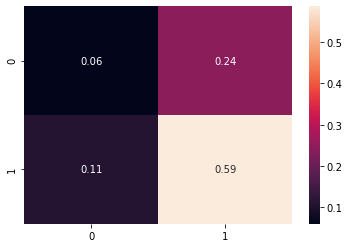

In [45]:
threshold = 0.65
y_pred = (clf.predict_proba(X_test)[:, 1] >= threshold).astype('int')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

In [63]:
clf.predict_proba(X_test)[:, 1]

array([0.73605175, 0.73112226, 0.77106802, ..., 0.71347656, 0.712235  ,
       0.74281316])

In [45]:
{'colsample_bytree': 0.17,
 'gamma': 0.06,
 'learning_rate': 0.04,
 'max_depth': 0,
 'min_child_weight': 9.0,
 'subsample': 0.14
}

{'colsample_bytree': 0.17,
 'gamma': 0.06,
 'learning_rate': 0.04,
 'max_depth': 0,
 'min_child_weight': 9.0,
 'subsample': 0.14}

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68598	validation_1-logloss:0.68530
[20]	validation_0-logloss:0.61742	validation_1-logloss:0.59467
[40]	validation_0-logloss:0.60085	validation_1-logloss:0.56808
[60]	validation_0-logloss:0.59456	validation_1-logloss:0.56043
[80]	validation_0-logloss:0.59147	validation_1-logloss:0.55760
[100]	validation_0-logloss:0.58869	validation_1-logloss:0.55751
[120]	validation_0-logloss:0.58649	validation_1-logloss:0.55781
[140]	validation_0-logloss:0.58432	validation_1-logloss:0.55906
[160]	validation_0-logloss:0.58237	validation_1-logloss:0.56029
[180]	validation_0-logloss:0.58091	validation_1-logloss:0.56016
[191]	validation_0-logloss:0.58010	validation_1-logloss:0.55990
f1 score: 0.821508734263687
accuracy score: 0.6975859788359788
              precision    recall  f1-score   support

           0       0.62      0.01      0.01      1833
           1       0.70      1.00      0.82      4215

    accuracy                           0.70      6048
   macro avg       0.

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


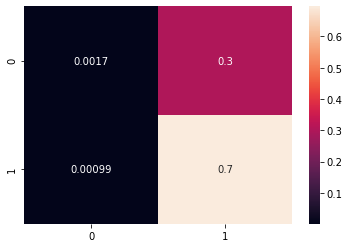

In [55]:
params = {'objective':'binary:logistic',
          'max_depth': 6, # default 6
#           'alpha': 10,
          'gamma' : 0.06,
          'subsample' : 0.14,
          'colsample_bytree' : 0.17, 
          'min_child_weight' : 9,
          'learning_rate': 0.04,
          'eval_metric' : 'logloss',
          'n_estimators' : 1000,
          'verbosity' : 0,
         }

model = XGBClassifier(**params) 
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid, y_valid)], 
          early_stopping_rounds=100,
          verbose=20)

threshold = 0.6
y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype('int')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

f1 score: 0.821508734263687
accuracy score: 0.6975859788359788
              precision    recall  f1-score   support

           0       0.62      0.01      0.01      1833
           1       0.70      1.00      0.82      4215

    accuracy                           0.70      6048
   macro avg       0.66      0.50      0.42      6048
weighted avg       0.68      0.70      0.58      6048



C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


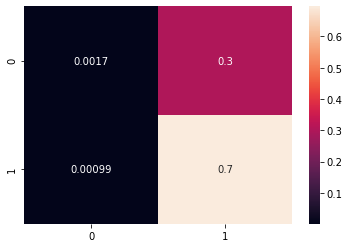

In [57]:
threshold = 0.6
y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype('int')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

In [43]:
y_train_pred = model.predict_proba(X_train)[:, 1]
prediction_train['XGBoost'] = y_train_pred

y_valid_pred = model.predict_proba(X_valid)[:, 1]
prediction_valid['XGBoost'] = y_valid_pred

y_test_pred = model.predict_proba(X_test)[:, 1]
prediction_test['XGBoost'] = y_test_pred

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


f1 score: 0.0
accuracy score: 0.3030753968253968
              precision    recall  f1-score   support

           0       0.30      1.00      0.47      1833
           1       0.00      0.00      0.00      4215

    accuracy                           0.30      6048
   macro avg       0.15      0.50      0.23      6048
weighted avg       0.09      0.30      0.14      6048



C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Prec

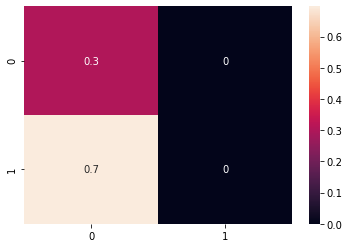

In [53]:
threshold = 0.705
y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype('int')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

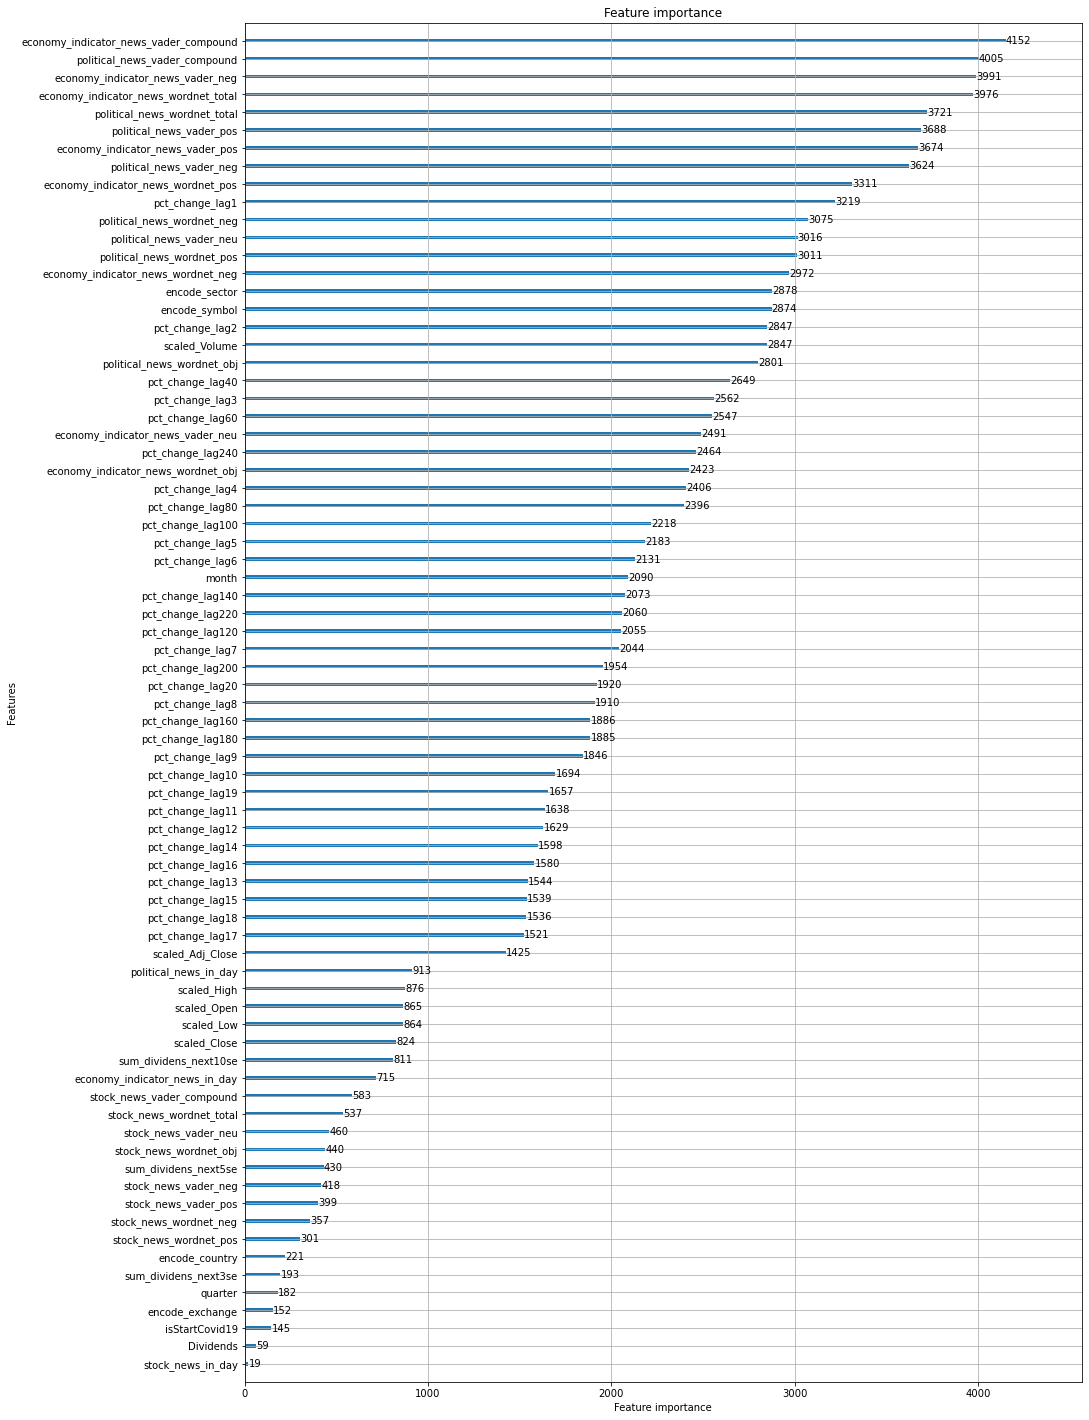

In [101]:
fig, ax = plt.subplots(figsize=(15, 25))
lgb.plot_importance(model, ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

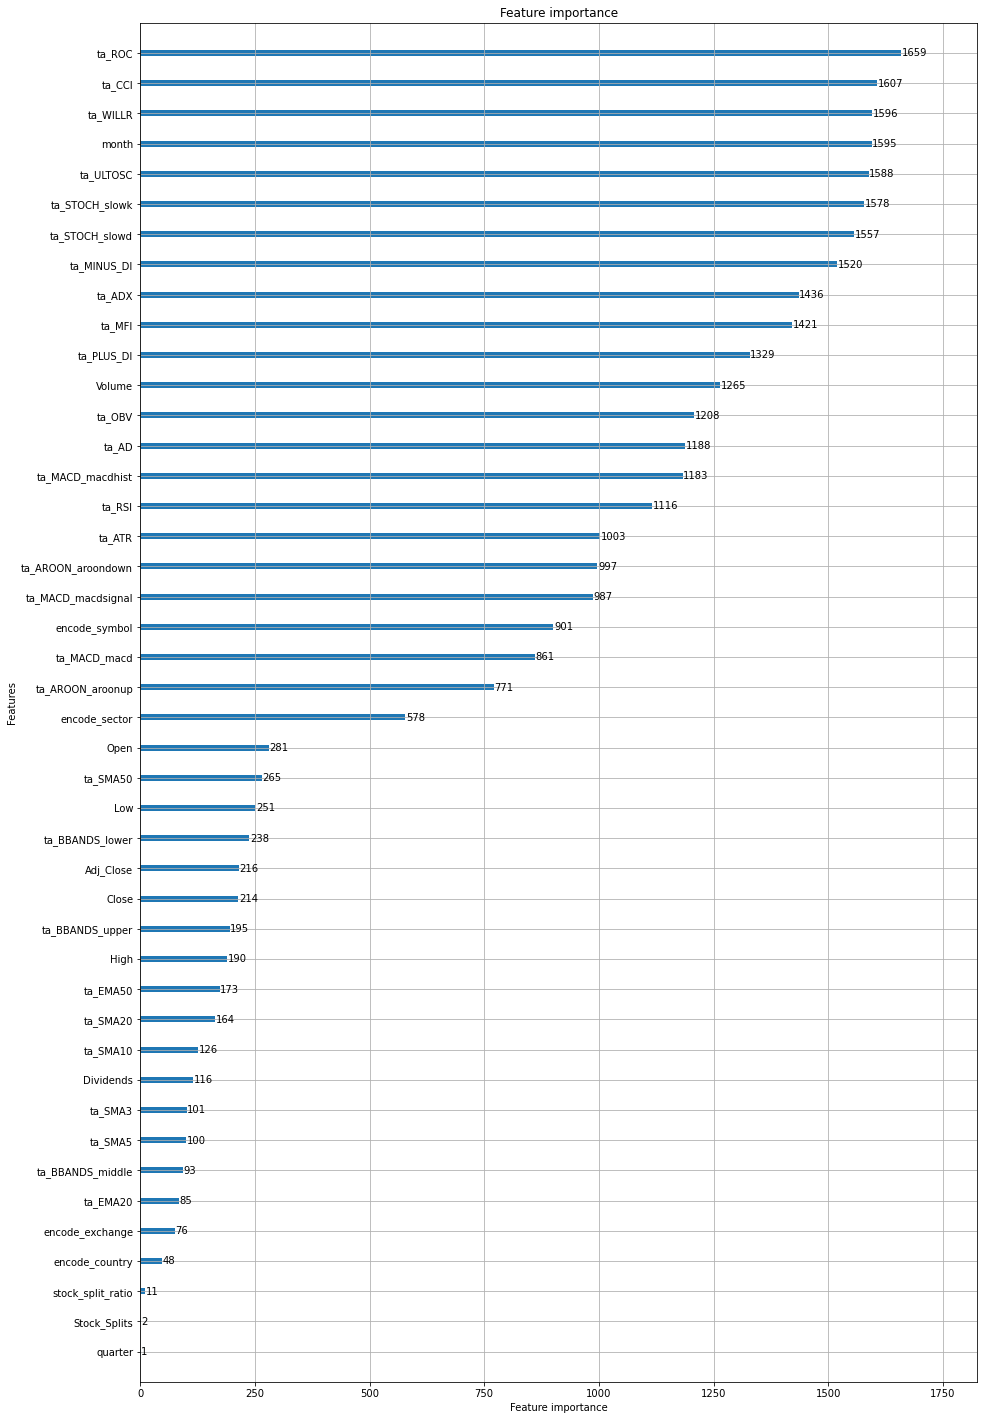

In [116]:
fig, ax = plt.subplots(figsize=(15, 25))
lgb.plot_importance(model, ax=ax)

# Hypothesis Testing with Random Forest

In [33]:
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=100, criterion="entropy")
rfc.fit(X_train, y_train)

<ipython-input-33-a94fb55c803a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', n_jobs=-1)

In [32]:
X_train.head()

,Open,High,Low,Close,Adj Close,Volume,month,quarter,year,encode_symbol,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC
0,0.007950,0.007914,0.008035,0.007956,0.006526,0.009180,10,4,2016,72,-0.001189,0,0.005646,-0.002377,0.006843,-0.001190,0.008043,2.0,5.0,8.0,12.0,0.001490,-0.001189,-0.008555,-0.003262,-0.002078,-0.007676,0.008703,-0.011180,-0.006503,-0.000892,-0.018973,-0.015813,-0.019545,-0.005916,-0.001189,-0.030014,-0.034750,-0.039165,0.006727,0.007196,0.006791,0.007037,0.006339,0.006546,0.006608,42.762865,34.659600,47.530783,60.844451,-0.620948,-0.461910,1.618964,0.443154,-0.089181
1,0.010650,0.010607,0.010772,0.010675,0.009156,0.002216,8,3,2016,89,0.000000,0,0.005472,-0.001665,0.005472,-0.001665,0.007150,2.0,6.0,10.0,15.0,-0.002374,0.014483,0.008397,-0.003320,-0.001188,0.000476,0.001429,0.001429,-0.003793,0.003582,0.001429,0.001429,0.003582,0.003342,0.018909,0.071374,0.023189,-0.011706,0.009278,0.009642,0.009348,0.009507,0.008932,0.009151,0.009161,56.937537,60.606028,45.138096,41.534382,-0.002386,0.205255,-1.017678,0.575327,0.358186
2,0.043110,0.043133,0.043498,0.043465,0.041411,0.000590,10,4,2018,52,0.005016,1,0.008686,-0.003792,0.003652,-0.008764,0.012525,3.0,5.0,10.0,16.0,0.000426,-0.009166,-0.019455,-0.027924,-0.027003,0.022273,0.012197,0.010641,0.007666,0.001890,-0.013153,-0.011431,-0.000365,0.038819,0.039805,0.054148,0.051853,0.061503,0.042132,0.043421,0.042610,0.043205,0.041478,0.042082,0.041648,54.506447,31.255724,53.133167,51.285593,-0.275910,-0.140259,-0.144596,2.946715,0.189009
3,0.019084,0.018979,0.019292,0.019130,0.017200,0.001303,3,1,2017,20,-0.000408,0,0.003261,-0.002038,0.003671,-0.001631,0.005310,3.0,4.0,11.0,19.0,-0.002847,0.001770,-0.001493,-0.004870,-0.001629,-0.001900,-0.003252,-0.005409,-0.004601,-0.005139,-0.001222,-0.004601,-0.009427,0.002589,0.005467,0.001361,0.085916,0.139052,0.017688,0.017742,0.017719,0.017713,0.016716,0.017276,0.017434,58.630011,39.479774,37.034762,54.324701,-0.236852,-0.051664,1.083799,0.791245,-0.513947
4,0.026757,0.026805,0.026968,0.026928,0.023205,0.003445,12,4,2015,49,0.003324,1,0.010166,-0.004888,0.006820,-0.008184,0.015128,4.0,6.0,11.0,19.0,0.004797,0.002148,-0.006581,-0.003011,0.018355,0.005781,0.002735,0.013829,0.002638,0.006669,0.005880,-0.001265,0.001561,0.008846,0.007077,0.015086,0.029027,0.093797,0.023608,0.024162,0.023800,0.023986,0.022575,0.023244,0.023364,57.306801,61.917484,73.752008,51.447746,-0.213501,0.034740,-0.816473,1.310992,0.666944


f1 score: 0.7667308103485141
accuracy score: 0.6392195767195767
              precision    recall  f1-score   support

           0       0.31      0.15      0.20      1833
           1       0.70      0.85      0.77      4215

    accuracy                           0.64      6048
   macro avg       0.50      0.50      0.49      6048
weighted avg       0.58      0.64      0.60      6048



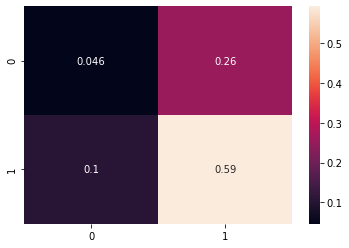

In [34]:
threshold = 0.6
y_pred = (rfc.predict_proba(X_test)[:, 1] >= threshold).astype('int')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

f1 score: 0.7485689123734037
accuracy score: 0.6223544973544973
              precision    recall  f1-score   support

           0       0.31      0.20      0.24      1833
           1       0.70      0.81      0.75      4215

    accuracy                           0.62      6048
   macro avg       0.50      0.50      0.50      6048
weighted avg       0.58      0.62      0.59      6048



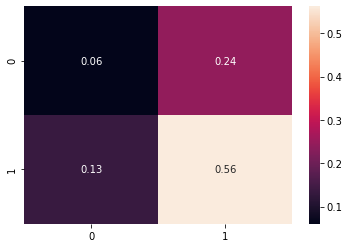

In [58]:
threshold = 0.6
y_pred = (rfc.predict_proba(X_test)[:, 1] >= threshold).astype('int')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

In [82]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [84]:
y_train_pred = logreg.predict_proba(X_train)[:, 1]
prediction_train['LogisticRegression'] = y_train_pred

y_valid_pred = logreg.predict_proba(X_valid)[:, 1]
prediction_valid['LogisticRegression'] = y_valid_pred

y_test_pred = logreg.predict_proba(X_test)[:, 1]
prediction_test['LogisticRegression'] = y_test_pred

In [86]:
prediction_test

,lightGBM,XGBoost,catboost,randomforest_entropy,randomforest_gini,LogisticRegression
0,0.697904,0.699332,0.692293,0.61,0.66,0.718860
1,0.715556,0.706557,0.742442,0.64,0.55,0.758385
2,0.725683,0.711776,0.707064,0.69,0.65,0.753319
3,0.695021,0.691790,0.682759,0.68,0.60,0.717988
4,0.691421,0.683030,0.696802,0.64,0.69,0.729920
...,...,...,...,...,...,...
6043,0.732800,0.693006,0.720527,0.69,0.67,0.715700
6044,0.725291,0.669327,0.694049,0.76,0.63,0.708830
6045,0.725066,0.712826,0.704647,0.65,0.81,0.711896
6046,0.717952,0.738344,0.710617,0.80,0.83,0.707746


f1 score: 0.6144149081940259
accuracy score: 0.5347222222222222
              precision    recall  f1-score   support

           0       0.33      0.54      0.41      1833
           1       0.73      0.53      0.61      4215

    accuracy                           0.53      6048
   macro avg       0.53      0.54      0.51      6048
weighted avg       0.61      0.53      0.55      6048



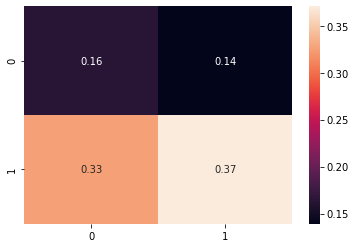

In [83]:
threshold = 0.7
y_pred = (logreg.predict_proba(X_test)[:, 1] >= threshold).astype('int')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

f1 score: 0.615702479338843
accuracy score: 0.5386904761904762
              precision    recall  f1-score   support

           0       0.34      0.56      0.42      1833
           1       0.73      0.53      0.62      4215

    accuracy                           0.54      6048
   macro avg       0.54      0.54      0.52      6048
weighted avg       0.61      0.54      0.56      6048



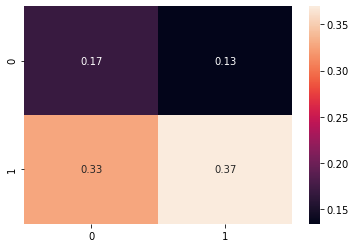

In [81]:
threshold = 0.7
y_pred = (logreg.predict_proba(X_test)[:, 1] >= threshold).astype('int')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

In [90]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.ClassifierMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'} or callable, default='uniform'
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer ne

In [92]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

In [96]:
y_train_pred = knn.predict_proba(X_train)[:, 1]
prediction_train['KNeighborsClassifier'] = y_train_pred

y_valid_pred = knn.predict_proba(X_valid)[:, 1]
prediction_valid['KNeighborsClassifier'] = y_valid_pred

y_test_pred = knn.predict_proba(X_test)[:, 1]
prediction_test['KNeighborsClassifier'] = y_test_pred

In [99]:
prediction_test

,lightGBM,XGBoost,catboost,randomforest_entropy,randomforest_gini,LogisticRegression,KNeighborsClassifier
0,0.697904,0.699332,0.692293,0.61,0.66,0.718860,1.000000
1,0.715556,0.706557,0.742442,0.64,0.55,0.758385,0.000000
2,0.725683,0.711776,0.707064,0.69,0.65,0.753319,0.666667
3,0.695021,0.691790,0.682759,0.68,0.60,0.717988,0.333333
4,0.691421,0.683030,0.696802,0.64,0.69,0.729920,0.333333
...,...,...,...,...,...,...,...
6043,0.732800,0.693006,0.720527,0.69,0.67,0.715700,0.666667
6044,0.725291,0.669327,0.694049,0.76,0.63,0.708830,0.666667
6045,0.725066,0.712826,0.704647,0.65,0.81,0.711896,1.000000
6046,0.717952,0.738344,0.710617,0.80,0.83,0.707746,1.000000


f1 score: 0.7331682053591534
accuracy score: 0.6081349206349206
              precision    recall  f1-score   support

           0       0.31      0.23      0.26      1833
           1       0.70      0.77      0.73      4215

    accuracy                           0.61      6048
   macro avg       0.50      0.50      0.50      6048
weighted avg       0.58      0.61      0.59      6048



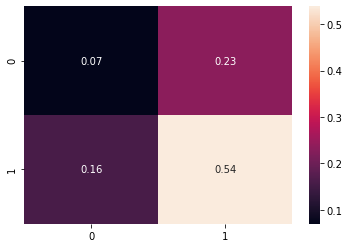

In [95]:
threshold = 0.65
y_pred = (knn.predict_proba(X_test)[:, 1] >= threshold).astype('int')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

In [105]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GaussianNB()

In [109]:
y_train_pred = gaussian.predict_proba(X_train)[:, 1]
prediction_train['GaussianNB'] = y_train_pred

y_valid_pred = gaussian.predict_proba(X_valid)[:, 1]
prediction_valid['GaussianNB'] = y_valid_pred

y_test_pred = gaussian.predict_proba(X_test)[:, 1]
prediction_test['GaussianNB'] = y_test_pred

In [110]:
prediction_test

,lightGBM,XGBoost,catboost,randomforest_entropy,randomforest_gini,LogisticRegression,KNeighborsClassifier,GaussianNB
0,0.697904,0.699332,0.692293,0.61,0.66,0.718860,1.000000,1.000000
1,0.715556,0.706557,0.742442,0.64,0.55,0.758385,0.000000,1.000000
2,0.725683,0.711776,0.707064,0.69,0.65,0.753319,0.666667,1.000000
3,0.695021,0.691790,0.682759,0.68,0.60,0.717988,0.333333,1.000000
4,0.691421,0.683030,0.696802,0.64,0.69,0.729920,0.333333,1.000000
...,...,...,...,...,...,...,...,...
6043,0.732800,0.693006,0.720527,0.69,0.67,0.715700,0.666667,0.910553
6044,0.725291,0.669327,0.694049,0.76,0.63,0.708830,0.666667,0.639461
6045,0.725066,0.712826,0.704647,0.65,0.81,0.711896,1.000000,0.410123
6046,0.717952,0.738344,0.710617,0.80,0.83,0.707746,1.000000,0.283833


In [122]:
base_model = SGDClassifier()
model = CalibratedClassifierCV(base_model)
model.fit(X_train, y_train)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


CalibratedClassifierCV(base_estimator=SGDClassifier())

In [130]:
y_train_pred = model.predict_proba(X_train)[:, 1]
prediction_train['SGDClassifier'] = y_train_pred

y_valid_pred = model.predict_proba(X_valid)[:, 1]
prediction_valid['SGDClassifier'] = y_valid_pred

y_test_pred = model.predict_proba(X_test)[:, 1]
prediction_test['SGDClassifier'] = y_test_pred

f1 score: 0.6175791332699361
accuracy score: 0.5345568783068783
              precision    recall  f1-score   support

           0       0.33      0.52      0.41      1833
           1       0.72      0.54      0.62      4215

    accuracy                           0.53      6048
   macro avg       0.53      0.53      0.51      6048
weighted avg       0.60      0.53      0.55      6048



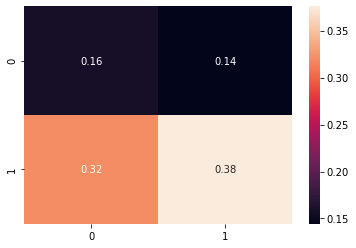

In [129]:
threshold = 0.7
y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype('int')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

In [135]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [137]:
y_train_pred = decision_tree.predict_proba(X_train)[:, 1]
prediction_train['DecisionTree'] = y_train_pred

y_valid_pred = decision_tree.predict_proba(X_valid)[:, 1]
prediction_valid['DecisionTree'] = y_valid_pred

y_test_pred = decision_tree.predict_proba(X_test)[:, 1]
prediction_test['DecisionTree'] = y_test_pred

In [139]:
prediction_test.describe()

,lightGBM,XGBoost,catboost,randomforest_entropy,randomforest_gini,LogisticRegression,KNeighborsClassifier,GaussianNB,SGDClassifier,DecisionTree
count,6048.000000,6048.000000,6048.000000,6048.000000,6048.000000,6048.000000,6048.000000,6048.000000,6048.000000,6048.000000
mean,0.698094,0.681492,0.678671,0.671786,0.658203,0.699235,0.698633,0.430958,0.701821,0.654597
std,0.020783,0.035175,0.031389,0.082421,0.088520,0.033505,0.273480,0.378676,0.031520,0.475539
min,0.623106,0.512055,0.573926,0.260000,0.230000,0.570016,0.000000,0.009877,0.586071,0.000000
25%,0.684562,0.659751,0.656687,0.630000,0.610000,0.676656,0.666667,0.080390,0.680232,0.000000
50%,0.694960,0.680201,0.673706,0.680000,0.660000,0.700860,0.666667,0.275426,0.701555,1.000000
75%,0.707143,0.701275,0.694589,0.730000,0.720000,0.722866,1.000000,0.870880,0.723641,1.000000
max,0.790238,0.849086,0.828008,0.900000,0.930000,0.803131,1.000000,1.000000,0.827762,1.000000


f1 score: 0.6789821384878884
accuracy score: 0.5661375661375662
              precision    recall  f1-score   support

           0       0.31      0.35      0.33      1833
           1       0.70      0.66      0.68      4215

    accuracy                           0.57      6048
   macro avg       0.51      0.51      0.50      6048
weighted avg       0.58      0.57      0.57      6048



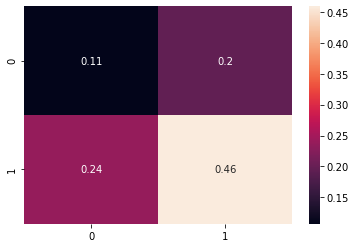

In [136]:
threshold = 0.75
y_pred = (decision_tree.predict_proba(X_test)[:, 1] >= threshold).astype('int')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

In [ ]:
prediction_train
prediction_valid

In [143]:
params = {'objective':'binary:logistic',
#           'max_depth': 6, # default 6
#           'alpha': 10,
#           'gamma' : 0.44,
#           'subsample' : 0.73,
#           'colsample_bytree' : 0.23, 
#           'min_child_weight' : 6,
          'learning_rate': 0.01,
          'eval_metric' : 'logloss',
          'n_estimators' : 1000,
          'verbosity' : 0,
         }    

model = XGBClassifier(**params) 
model.fit(prediction_train, y_train,
          eval_set=[(prediction_train, y_train), (prediction_valid, y_valid)], 
          early_stopping_rounds=100,
          verbose=20)

[0]	validation_0-logloss:0.68331	validation_1-logloss:0.68864


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20]	validation_0-logloss:0.51914	validation_1-logloss:0.62347
[40]	validation_0-logloss:0.40244	validation_1-logloss:0.59289
[60]	validation_0-logloss:0.31637	validation_1-logloss:0.58444
[80]	validation_0-logloss:0.25097	validation_1-logloss:0.59116
[100]	validation_0-logloss:0.20045	validation_1-logloss:0.60865
[120]	validation_0-logloss:0.16097	validation_1-logloss:0.63418
[140]	validation_0-logloss:0.12981	validation_1-logloss:0.66571
[159]	validation_0-logloss:0.10608	validation_1-logloss:0.70000


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=0)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


f1 score: 0.7924220818904054
accuracy score: 0.6630291005291006
              precision    recall  f1-score   support

           0       0.27      0.07      0.11      1833
           1       0.69      0.92      0.79      4215

    accuracy                           0.66      6048
   macro avg       0.48      0.49      0.45      6048
weighted avg       0.57      0.66      0.58      6048



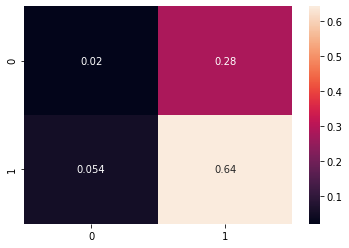

In [149]:
threshold = 0.7
y_pred = (model.predict_proba(prediction_test)[:, 1] >= threshold).astype('int')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

In [154]:
clf = CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1, 
    loss_function='Logloss',
#     reg_lambda=3.,
#     subsample=1,
#     colsample_bylevel=1.0,
#     max_depth=6,
    od_type = "Iter",
    od_wait = 100
)

clf.fit(prediction_train, y_train, 
        eval_set=(prediction_valid, y_valid), 
        verbose=10)

0:	learn: 0.3256821	test: 0.6266206	best: 0.6266206 (0)	total: 34.2ms	remaining: 34.2s
10:	learn: 0.0011887	test: 1.1819221	best: 0.5966367 (1)	total: 222ms	remaining: 20s
20:	learn: 0.0001776	test: 1.7475203	best: 0.5966367 (1)	total: 404ms	remaining: 18.8s
30:	learn: 0.0000950	test: 1.9316267	best: 0.5966367 (1)	total: 580ms	remaining: 18.1s
40:	learn: 0.0000781	test: 1.9790190	best: 0.5966367 (1)	total: 763ms	remaining: 17.9s
50:	learn: 0.0000781	test: 1.9790190	best: 0.5966367 (1)	total: 950ms	remaining: 17.7s
60:	learn: 0.0000781	test: 1.9790190	best: 0.5966367 (1)	total: 1.14s	remaining: 17.5s
70:	learn: 0.0000781	test: 1.9790190	best: 0.5966367 (1)	total: 1.32s	remaining: 17.3s
80:	learn: 0.0000781	test: 1.9790327	best: 0.5966367 (1)	total: 1.54s	remaining: 17.5s
90:	learn: 0.0000781	test: 1.9790462	best: 0.5966367 (1)	total: 1.74s	remaining: 17.4s
100:	learn: 0.0000780	test: 1.9790386	best: 0.5966367 (1)	total: 1.92s	remaining: 17.1s
Stopped by overfitting detector  (100 iterat

f1 score: 0.6705259268382806
accuracy score: 0.5577050264550265
              precision    recall  f1-score   support

           0       0.30      0.36      0.33      1833
           1       0.70      0.65      0.67      4215

    accuracy                           0.56      6048
   macro avg       0.50      0.50      0.50      6048
weighted avg       0.58      0.56      0.57      6048



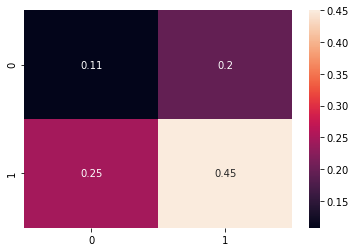

In [155]:
threshold = 0.7
y_pred = (clf.predict_proba(prediction_test)[:, 1] >= threshold).astype('int')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

# Hypothesis Testing with ANN

In [65]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [107]:
tf.python.client.device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 729499034766987098,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2229988788332758010
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3435331584
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 826412172484990487
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6285788610778399662
 physical_device_desc: "device: XLA_GPU device"]

In [ ]:
# X_train_val = data_train_valid[train_cols + ta_cols]
# y_train_val = data_train_valid[label]

In [93]:
X_train_ = np.expand_dims(X_train, 1)
y_train_ = y_train.values

In [94]:
X_train_.shape

(242449, 1, 117)

In [93]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=64, return_sequences=True))
# # model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=False))
# # model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
# # model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(128, activation="relu"))
# model.add(tf.keras.layers.Dense(64, activation="relu"))
# model.add(tf.keras.layers.Dense(32, activation="relu"))
# model.add(tf.keras.layers.Dense(10, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07,
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

with tf.device('/GPU:0'):
    history_model = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10)

Epoch 1/10
7288/7288 [==============================] - 17s 2ms/step - loss: 1.4889 - accuracy: 0.6729 - val_loss: 0.5557 - val_accuracy: 0.7583
Epoch 2/10
7288/7288 [==============================] - 16s 2ms/step - loss: 0.6065 - accuracy: 0.7054 - val_loss: 0.5620 - val_accuracy: 0.7583
Epoch 3/10
7288/7288 [==============================] - 17s 2ms/step - loss: 0.6076 - accuracy: 0.7042 - val_loss: 0.5624 - val_accuracy: 0.7583
Epoch 4/10
7288/7288 [==============================] - 17s 2ms/step - loss: 0.6078 - accuracy: 0.7038 - val_loss: 0.5608 - val_accuracy: 0.7583
Epoch 5/10
7288/7288 [==============================] - 17s 2ms/step - loss: 0.6078 - accuracy: 0.7038 - val_loss: 0.5588 - val_accuracy: 0.7583
Epoch 6/10
7288/7288 [==============================] - 18s 2ms/step - loss: 0.6093 - accuracy: 0.7020 - val_loss: 0.5606 - val_accuracy: 0.7583
Epoch 7/10
7288/7288 [==============================] - 17s 2ms/step - loss: 0.6065 - accuracy: 0.7052 - val_loss: 0.5604 - val_ac

In [68]:
data_test['predict_historical_data_ANN'] = model.predict(X_test)

<ipython-input-68-786ee73ebe52>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['predict_historical_data_ANN'] = model.predict(X_test)


In [109]:
threshold = 0.5
y_pred = (model.predict(X_test) >= threshold).astype('int')

print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

f1 score: 0.0
accuracy score: 0.6515519223400179
              precision    recall  f1-score   support

           0       0.65      1.00      0.79     20404
           1       0.00      0.00      0.00     10912

    accuracy                           0.65     31316
   macro avg       0.33      0.50      0.39     31316
weighted avg       0.42      0.65      0.51     31316



/home/tuongnguyen/anaconda3/envs/jupyterNotebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tuongnguyen/anaconda3/envs/jupyterNotebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tuongnguyen/anaconda3/envs/jupyterNotebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

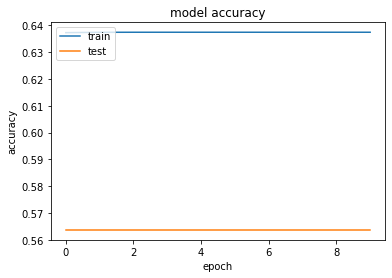

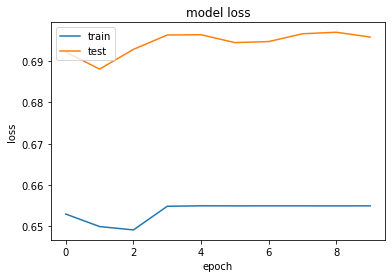

In [112]:
# summarize history for accuracy
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = Sequential()
model.add(CuDNNLSTM(256, input_shape=(X_train.shape[1:]), return_sequences=True))
model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(CuDNNLSTM(64))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='tanh'))

opt = tf.keras.optimizers.RMSprop(lr=7e-3)
model.compile(loss='mse',optimizer=opt, metrics=['mse'])
return model

In [26]:
X_train = np.expand_dims(X_train, 1)
y_train = y_train.values

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(units=256, return_sequences=True))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(units=128, return_sequences=True))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(units=64, return_sequences=True))
model.add(tf.keras.layers.BatchNormalization())
# # model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
# # model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.Dense(1024, activation="relu"))
# model.add(tf.keras.layers.Dense(512, activation="relu"))
# model.add(tf.keras.layers.Dense(256, activation="relu"))
# model.add(tf.keras.layers.Dense(128, activation="relu"))
# model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dense(10, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.001#, rho=0.9, momentum=0.0, epsilon=1e-07,
)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

with tf.device('/GPU:0'):
    history_model = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=4)

Epoch 1/10


In [ ]:

plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1],c=vectorizer(y))

In [ ]:
year = 2020
symbol = 'MSFT'

fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)

ax.set_title(f'3 component PCA - year {year}', fontsize = 20)

getdata = principalDf[(principalDf['Date'].dt.year==year) & (principalDf['symbol']==symbol)]

ax.scatter3D(getdata[(getdata['label']==0)]['d1'],
             getdata[(getdata['label']==0)]['d2'],
             getdata[(getdata['label']==0)]['d3'],)

ax.scatter3D(getdata[(getdata['label']==1)]['d1'],
             getdata[(getdata['label']==1)]['d2'],
             getdata[(getdata['label']==1)]['d3'],)
# ax.legend(targets)
ax.grid()

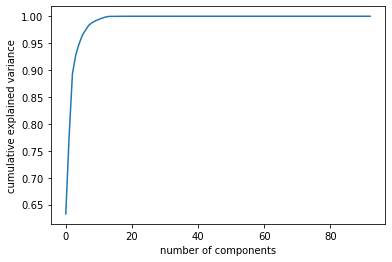

In [125]:
from sklearn.decomposition import PCA
pca = PCA().fit(data_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [126]:
n_components = 10
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(data_train_pca)
print(f"Our reduced dimensions can explain {sum(pca.explained_variance_ratio_):.4f} % of the variance in the original data")

Our reduced dimensions can explain 0.9917 % of the variance in the original data


In [127]:
reducedDf = pd.DataFrame(data=principalComponents, columns=[f'd{i}' for i in range(0, n_components)])
reducedDf['Date'] = data_pca['Date']
reducedDf['label_t3'] = data_pca['label_t3']
reducedDf.head()

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,Date,label_t3
0,-70.069784,3.749357,10.551597,-8.558242,-9.189304,-0.182206,-3.549381,-1.433659,0.030037,6.969359,2012-01-03,1
1,-78.891352,2.945219,5.337127,-6.165287,-3.686621,-3.314520,0.872366,-3.778433,1.939582,6.803152,2012-01-04,1
2,-93.493571,-4.953141,-0.557756,0.223312,3.611930,-6.892062,5.220530,-5.516167,3.665578,6.043418,2012-01-05,1
3,-100.003825,-9.987616,-1.092873,2.818413,11.203141,-9.525833,3.179822,-2.640966,5.327742,7.222354,2012-01-06,0
4,-92.775555,-3.078302,-0.142123,10.751203,16.950225,-9.317709,-1.096142,-0.927851,2.402696,7.612020,2012-01-09,0


In [ ]:
%%time
# sector = 'Technology'
n_components = 20

# data_tsne = df[df['sector']==sector].copy().reset_index(drop=True)
data_train_tnse = df[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols]

tsne = TSNE(n_components=n_components, perplexity=50, method='exact')
data_reduced_tsne = tsne.fit_transform(data_train_tnse)

reducedDf = pd.DataFrame(data=data_reduced_tsne, columns=[f'd{i}' for i in range(0, n_components)])
reducedDf['Date'] = data_tsne['Date']
reducedDf['symbol'] = data_tsne['symbol']
reducedDf['label'] = data_tsne['label_t3']

In [128]:
train_date_start = '2010-01-01'
valid_date_start = '2020-06-01'
test_date_start = '2021-05-01'
test_date_end = '2021-07-31'

data_train = reducedDf[(reducedDf["Date"] >= train_date_start) & (reducedDf["Date"] < valid_date_start)]
data_valid = reducedDf[(reducedDf["Date"] >= valid_date_start) & (reducedDf["Date"] < test_date_start)]
data_test = reducedDf[(reducedDf["Date"] >= test_date_start) & (reducedDf["Date"] <= test_date_end)]

data_train = shuffle(data_train).reset_index(drop=True)

In [129]:
print('train shape', data_train.shape)
print('valid shape', data_valid.shape)
# print('train valid shape', data_train_valid.shape)
print('test shape', data_test.shape)

print(f'valid ratio {data_valid.shape[0] / (data_valid.shape[0] + data_train.shape[0])}')

train shape (144442, 12)
valid shape (16472, 12)
test shape (4473, 12)
valid ratio 0.10236523857464236


In [130]:
data_train.head()

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,Date,label_t3
0,-46.055482,-26.309333,38.033506,3.976109,-6.616631,5.658540,6.479843,5.153382,-8.199018,2.640555,2019-06-25,1
1,-29.170939,25.468216,-2.823779,-30.592676,3.615985,-19.840973,7.042529,5.969284,-4.565430,-6.112230,2019-11-26,0
2,14.213304,42.096868,-0.599361,-8.958077,-0.210669,12.354283,-11.985723,-3.055317,-1.944377,-9.094315,2013-01-30,0
3,-24.655848,-23.515131,53.043560,-16.075260,-8.350646,7.923957,6.810792,-11.847214,-3.568611,-6.889425,2013-12-10,0
4,26.445225,-66.468305,-17.746687,-30.547832,8.182007,-0.675666,10.049485,5.526222,-0.097277,-2.083100,2016-01-22,0


In [131]:
X_train = data_train.drop(['Date', 'label_t3'], axis=1)
y_train = data_train['label_t3']

X_valid = data_valid.drop(['Date', 'label_t3'], axis=1)
y_valid = data_valid['label_t3']

X_test = data_test.drop(['Date', 'label_t3'], axis=1)
y_test = data_test['label_t3']

In [132]:
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid, reference=dtrain)

params = {
    "objective": "binary", # ,"regression"
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
#     "num_leaves": 50,
#     "max_bin": 32,
#     "feature_fraction": 0.6,
#     "bagging_fraction" : 0.6,
#     "bagging_freq" : 0,
#     "max_depth" : 20,
#     "verbosity": 100,
#     "drop_rate": 0.1,
#     "is_unbalance": False,
#     "max_drop": 50,
#     "min_child_samples": 10,
#     "min_child_weight": 150,
#     "lambda_l1" : 10.,
#     "lambda_l2" : 10.,
#     "min_split_gain": 0,
    "num_threads" : -1,
    "metric" : "binary_logloss"
    # "metric" : "rmse"
}

model = lgb.train(params=params, 
                  train_set=dtrain, 
                  num_boost_round=10000, 
                  valid_sets=[dtrain, dvalid], 
                  verbose_eval=20,
                  early_stopping_rounds=100)

[LightGBM] [Info] Number of positive: 54608, number of negative: 89834
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 144442, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378062 -> initscore=-0.497783
[LightGBM] [Info] Start training from score -0.497783
Training until validation scores don't improve for 100 rounds
[20]	training's binary_logloss: 0.661457	valid_1's binary_logloss: 0.689459
[40]	training's binary_logloss: 0.660212	valid_1's binary_logloss: 0.688749
[60]	training's binary_logloss: 0.659222	valid_1's binary_logloss: 0.688234
[80]	training's binary_logloss: 0.658387	valid_1's binary_logloss: 0.687805
[100]	training's binary_logloss: 0.657677	valid_1's binary_logloss: 0.687538
[120]	training's binary_logloss: 0.65706	valid_1's binary_l

In [140]:
threshold = 0.4
y_valid_pred = (model.predict(X_valid) >= threshold).astype('int')

print(f1_score(y_valid_pred, y_valid))
print(classification_report(y_valid, y_valid_pred))

0.3708562931863903
              precision    recall  f1-score   support

           0       0.59      0.77      0.67      9335
           1       0.49      0.30      0.37      7137

    accuracy                           0.56     16472
   macro avg       0.54      0.53      0.52     16472
weighted avg       0.55      0.56      0.54     16472



In [139]:
threshold = 0.4
y_pred = (model.predict(X_test) >= threshold).astype('int')

print(f1_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

0.3549295774647887
              precision    recall  f1-score   support

           0       0.60      0.69      0.64      2658
           1       0.41      0.31      0.35      1815

    accuracy                           0.54      4473
   macro avg       0.50      0.50      0.50      4473
weighted avg       0.52      0.54      0.53      4473



In [ ]:
cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True)

In [135]:
df[(df['sector']=='Technology') & (df['Date']>='2021-01-01')].groupby('label_t3').size()

label_t3
0    6402
1    4461
dtype: int64

In [136]:
data_test.groupby('label_t3').size()

label_t3
0    2658
1    1815
dtype: int64

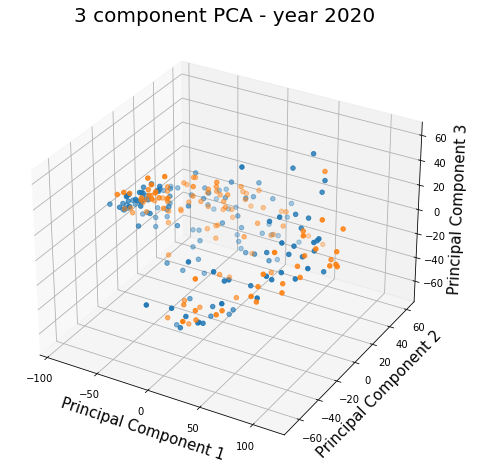

In [74]:
year = 2020
symbol = 'MSFT'

fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)

ax.set_title(f'3 component PCA - year {year}', fontsize = 20)

getdata = principalDf[(principalDf['Date'].dt.year==year) & (principalDf['symbol']==symbol)]

ax.scatter3D(getdata[(getdata['label']==0)]['d1'],
             getdata[(getdata['label']==0)]['d2'],
             getdata[(getdata['label']==0)]['d3'],)

ax.scatter3D(getdata[(getdata['label']==1)]['d1'],
             getdata[(getdata['label']==1)]['d2'],
             getdata[(getdata['label']==1)]['d3'],)
# ax.legend(targets)
ax.grid()

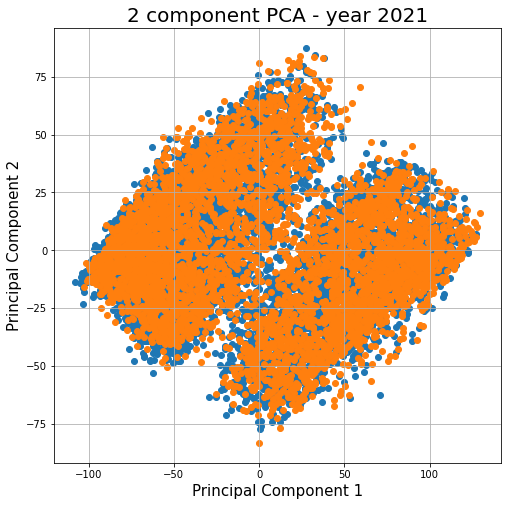

In [64]:
year = 2021
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title(f'2 component PCA - year {year}', fontsize = 20)

ax.scatter(principalDf[(principalDf['label']==0) & (principalDf['Date'].dt.year==year)]['Dimension 1'],
           principalDf[(principalDf['label']==0) & (principalDf['Date'].dt.year==year)]['Dimension 2'],)

ax.scatter(principalDf[(principalDf['label']==1) & (principalDf['Date'].dt.year==year)]['Dimension 1'],
           principalDf[(principalDf['label']==1) & (principalDf['Date'].dt.year==year)]['Dimension 2'],)
# ax.legend(targets)
ax.grid()

In [63]:
s = pd.Series([1, 2, 3, 4, 5])
s

0    1
1    2
2    3
3    4
4    5
dtype: int64

In [114]:
s.rolling(3).sum().shift(-3)

0     9.0
1    12.0
2     NaN
3     NaN
4     NaN
dtype: float64

In [67]:
s.rolling(3).apply(np.prod)

0     NaN
1     NaN
2     6.0
3    24.0
4    60.0
dtype: float64

In [47]:
help(talib.SMA)

Help on function SMA in module talib._ta_lib:

SMA(...)
    SMA(real[, timeperiod=?])
    
    Simple Moving Average (Overlap Studies)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        timeperiod: 30
    Outputs:
        real



In [14]:
import matplotlib.pyplot as plt

In [47]:
close = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['Adj Close']
high = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['High']
low = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['Low']
# ta_SMA10 = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_SMA10']
# ta_SMA20 = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_SMA20']

# upper = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_BBANDS_upper']
# lower = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_BBANDS_lower']

# macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
ta_STOCH_slowk = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_STOCH_slowk']
ta_STOCH_slowd = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_STOCH_slowd']


slowk, slowd = talib.STOCH(high, low, close)

In [2]:
import ta

In [49]:
slowd - ta_STOCH_slowd

10100             NaN
10101             NaN
10102             NaN
10103             NaN
10104             NaN
10105             NaN
10106             NaN
10107             NaN
10108   -3.836931e-13
10109   -3.907985e-13
10110   -3.872458e-13
10111   -3.907985e-13
10112   -3.836931e-13
10113   -3.907985e-13
10114   -3.836931e-13
10115   -3.836931e-13
10116   -3.836931e-13
10117   -3.694822e-13
10118   -3.836931e-13
10119   -3.765876e-13
10120   -3.765876e-13
10121   -3.801404e-13
10122   -3.836931e-13
10123   -3.765876e-13
10124   -3.694822e-13
10125   -3.694822e-13
10126   -3.836931e-13
10127   -3.765876e-13
10128   -3.765876e-13
10129   -3.801404e-13
10130   -3.765876e-13
10131   -3.765876e-13
10132   -3.765876e-13
10133   -3.801404e-13
10134   -3.801404e-13
10135   -3.801404e-13
10136   -3.836931e-13
10137   -3.765876e-13
10138   -3.765876e-13
10139   -3.765876e-13
10140   -3.765876e-13
10141   -3.765876e-13
10142   -3.765876e-13
10143   -3.801404e-13
10144   -3.801404e-13
10145   -3

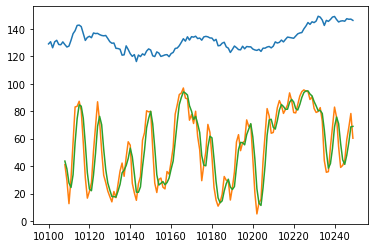

In [51]:
plt.plot(close, label='Closing Prices')
# plt.plot(rsi.values, label='rsi')
plt.plot(slowk, label='slowk')
plt.plot(slowd, label='slowd')
plt.show()

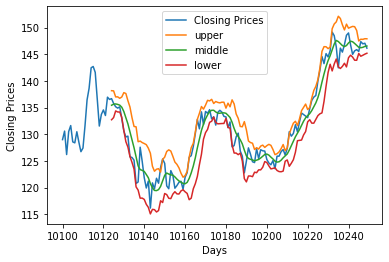

In [32]:
import matplotlib.pyplot as plt
# Plot the data
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(close, label='Closing Prices')
plt.plot(upper, label='upper')
plt.plot(middle, label='middle')
plt.plot(lower, label='lower')
plt.legend()
plt.show()

In [3]:
tmp = pd.DataFrame(np.random.random(100))

tmp['SMA'] = talib.SMA(tmp[0], timeperiod=10)
tmp['SMA2'] = ta.trend.sma_indicator(tmp[0], window=10)

tmp['delta'] = tmp['SMA']-tmp['SMA2']
tmp

,0,SMA,SMA2,delta
0,0.535400,NaN,NaN,NaN
1,0.277686,NaN,NaN,NaN
2,0.998812,NaN,NaN,NaN
3,0.025393,NaN,NaN,NaN
4,0.230199,NaN,NaN,NaN
5,0.400834,NaN,NaN,NaN
6,0.584140,NaN,NaN,NaN
7,0.280612,NaN,NaN,NaN
8,0.100513,NaN,NaN,NaN
9,0.368433,0.380202,0.380202,0.000000e+00


In [64]:
df

,Date,symbol,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,sector,country,exchange,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_MINUS_DI,ta_PLUS_DI,ta_ADX,ta_WILLR,ta_CCI,ta_ATR,ta_ULTOSC,ta_ROC,ta_AROON_aroondown,ta_AROON_aroonup,adj_close_lead,adjust_close_diff,label,stock_split_ratio,sum_dividens_next10se,sum_dividens_next5se,sum_dividens_next3se,ratio_stock_split_next10se,ratio_stock_split_next5se,ratio_stock_split_next3se,month,quarter,encode_symbol,encode_sector,encode_country,encode_exchange
3852,2015-03-16,A,41.160000,41.830002,41.110001,41.810001,39.410793,2551400.0,0.00,0.0,Healthcare,United States,NYSE,38.892348,38.696286,39.119521,39.280237,37.899021,38.903246,37.899021,39.495359,38.727775,37.960190,0.278070,0.423520,-0.145451,55.404715,52.373018,30.688019,47.488445,3965900.0,4.637804e+06,21.313331,22.283099,22.905749,-41.891883,-21.774436,0.700175,45.636802,-2.084317,92.857143,28.571429,39.193985,-0.216808,0,1.0,0.1,0.0,0.0,1.0,1.0,1.0,3,1,0,6,5,1
3853,2015-03-17,A,41.520000,41.689999,41.060001,41.580002,39.193985,1504900.0,0.00,0.0,Healthcare,United States,NYSE,39.043168,38.875381,39.055422,39.330196,37.918250,38.930935,37.949804,39.508498,38.778795,38.049092,0.270770,0.392970,-0.122200,53.372139,68.312218,48.262883,40.042034,2461000.0,5.617197e+06,20.190756,20.575251,21.336993,-52.252217,-34.309733,0.703734,51.868161,-1.609107,85.714286,21.428571,39.702999,0.509014,1,1.0,0.1,0.0,0.0,1.0,1.0,1.0,3,1,0,6,5,1
3854,2015-03-18,A,41.450001,42.380001,41.169998,42.119999,39.702999,1295600.0,0.00,0.0,Healthcare,United States,NYSE,39.435926,39.114806,39.066733,39.357532,37.961987,39.004465,38.018557,39.789289,38.927950,38.066610,0.302571,0.374890,-0.072320,57.330007,88.470232,69.718489,45.379175,3756600.0,6.356007e+06,17.818052,24.858604,20.991310,-27.928036,33.684487,0.739896,55.132998,0.285713,78.571429,14.285714,39.787838,0.084839,1,1.0,0.1,0.0,0.0,1.0,1.0,1.0,3,1,0,6,5,1
3855,2015-03-19,A,42.049999,42.250000,41.820000,42.209999,39.787838,1085700.0,0.00,0.0,Healthcare,United States,NYSE,39.561607,39.324068,39.065791,39.407491,38.019110,39.079072,38.087940,40.036899,39.132660,38.228421,0.330805,0.366073,-0.035268,57.970363,85.932519,80.904989,50.754213,4842300.0,7.239711e+06,17.051198,23.788738,20.670319,-23.873978,65.886919,0.717761,64.347453,-0.023676,71.428571,7.142857,39.787838,-0.000000,0,1.0,0.1,0.0,0.0,1.0,1.0,1.0,3,1,0,6,5,1
3856,2015-03-20,A,42.389999,42.529999,42.200001,42.209999,39.787838,2315500.0,0.00,0.0,Healthcare,United States,NYSE,39.759558,39.576691,39.129890,39.419745,38.066430,39.146574,38.154603,39.814506,39.341976,38.869446,0.349156,0.362690,-0.013533,57.970363,85.037594,86.480115,51.633493,4842300.0,5.064522e+06,16.465524,25.886019,20.782694,-17.561012,105.925682,0.690063,62.178001,1.637392,64.285714,0.000000,39.778408,-0.009430,0,1.0,0.1,0.1,0.0,1.0,1.0,1.0,3,1,0,6,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,2021-07-20,ZTS,197.240005,201.449997,197.240005,200.110001,200.110001,1884900.0,0.25,0.0,Healthcare,United States,NYSE,199.039215,199.626047,198.637976,193.339521,183.099781,193.926732,185.200231,202.546419,200.257493,197.968568,5.046538,5.037831,0.008707,72.130848,51.201952,57.261579,66.887439,278147700.0,1.933108e+08,12.645525,30.793608,46.941946,-11.725356,68.413181,2.985932,65.801650,3.269357,7.142857,71.428571,198.039993,-2.070007,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,7,3,496,6,5,1
2131,2021-07-21,ZTS,200.869995,200.869995,197.110001,198.039993,198.039993,1877600.0,0.00,0.0,Healthcare,United States,NYSE,198.576665,199.028918,198.726923,193.922313,183.641507,194.318471,185.703751,202.091330,200.027763,197.964197,4.

In [1]:
1

1